In [1]:
import pandas as pd, numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(style="darkgrid")

In [2]:
# 1. backtest.py

#!/usr/bin/python
# -*- coding: utf-8 -*-


from __future__ import print_function

import datetime
import pprint
try:
    import Queue as queue
except ImportError:
    import queue
import time

print("Executing backtest.py")
class Backtest(object):
    """
    Enscapsulates the settings and components for carrying out
    an event-driven backtest.
    """
#     print("*****backtest.py: 01: Class Backtest(object)*****")
    def __init__(
        self, csv_dir, symbol_list, initial_capital,
        heartbeat, start_date, data_handler, 
        execution_handler, portfolio, strategy
    ):
        """
        Initialises the backtest.
        Parameters:
        csv_dir - The hard root to the CSV data directory.
        symbol_list - The list of symbol strings.
        intial_capital - The starting capital for the portfolio.
        heartbeat - Backtest "heartbeat" in seconds
        start_date - The start datetime of the strategy.
        data_handler - (Class) Handles the market data feed.
        execution_handler - (Class) Handles the orders/fills for trades.
        portfolio - (Class) Keeps track of portfolio current and prior positions.
        strategy - (Class) Generates signals based on market data.
        """
#         print("*****backtest.py: 1. Backtest.initializing..*****")
        self.csv_dir = csv_dir
        self.symbol_list = symbol_list
        self.initial_capital = initial_capital
        self.heartbeat = heartbeat
        self.start_date = start_date

        self.data_handler_cls = data_handler
        self.execution_handler_cls = execution_handler
        self.portfolio_cls = portfolio
        self.strategy_cls = strategy

        # Added by Brad on 20191006
        # self.plots_cls = plots

        self.events = queue.Queue()
        
        self.signals = 0
        self.orders = 0
        self.fills = 0
        self.num_strats = 1
       
        self._generate_trading_instances()

    def _generate_trading_instances(self):
        # function1: call0 classes of 1)DataHandler, 2)strategy, 3)portfolion, 4)ExecutionHandler
        """
        Generates the trading instance objects from 
        their class types.
        """
#         print("*****backtest.py: 2. Backtest._generate_trading_instances*****")
#         print(
#             "backtest.py: _generate_trading_instances: Creating DataHandler, Strategy, Portfolio and ExecutionHandler"
#         )
        self.data_handler = self.data_handler_cls(self.events, self.csv_dir, self.symbol_list)
        self.strategy = self.strategy_cls(self.data_handler, self.events)
        self.portfolio = self.portfolio_cls(self.data_handler, self.events, self.start_date, 
                                            self.initial_capital)
        self.execution_handler = self.execution_handler_cls(self.events)
    

    def _run_backtest(self): # 
        # function1: update market bars
        # function2: identify the current event, including 1)market, 2)signal, 3)order, 4)
        """
        Executes the backtest.
        """
#         print("*****backtest.py: 3. Backtest._run_backtest*****")
#         print("Running Backtest...")
        i = 0
        while True:
            i += 1
            # print(i)

            # Update the market bars
            if self.data_handler.continue_backtest == True:
                self.data_handler.update_bars()
            else:
                break

            # Handle the events
            while True:
                try:
                    event = self.events.get(False)
                except queue.Empty:
                    break
                else:
                    if event is not None:
                        if event.type == 'MARKET':
                            self.strategy.calculate_signals(event)
                            self.portfolio.update_timeindex(event)

                        elif event.type == 'SIGNAL':
                            self.signals += 1                            
                            self.portfolio.update_signal(event)

                        elif event.type == 'ORDER':
                            self.orders += 1
                            self.execution_handler.execute_order(event)

                        elif event.type == 'FILL':
                            self.fills += 1
                            self.portfolio.update_fill(event)

            time.sleep(self.heartbeat)

	# OG version
    # def _output_performance(self):
    #     """
    #     Outputs the strategy performance from the backtest.
    #     """
    #     self.portfolio.create_equity_curve_dataframe()
        
    #     print("Creating summary stats...")
    #     stats = self.portfolio.output_summary_stats()
        
    #     print("Creating equity curve...")
    #     print(self.portfolio.equity_curve.tail(10))
    #     pprint.pprint(stats)

    #     print("Signals: %s" % self.signals)
    #     print("Orders: %s" % self.orders)
    #     print("Fills: %s" % self.fills)


    def _output_performance(self):
        """
        Outputs the strategy performance from the backtest.
        """
        self.portfolio.create_equity_curve_dataframe()
#         print("*****backtest.py: 4. Backtest._output_performance*****")
        print("Creating summary stats...")
        stats = self.portfolio.output_summary_stats()
        
        print("Creating equity curve...")
        print(self.portfolio.equity_curve.tail(10))
        pprint.pprint(stats)

        print("Signals: %s" % self.signals)
        print("Orders: %s" % self.orders)
        print("Fills: %s" % self.fills)

    def simulate_trading(self):
        # function 1: call 1)_run _backtest, 2__output_formance
        """
        Simulates the backtest and outputs portfolio performance.
        """
#         print("*****backtest.py: 5. Backtest.simulate_trading*****")
        self._run_backtest()
        self._output_performance()

Executing backtest.py


In [3]:
# 2. event.py

#!/usr/bin/python
# -*- coding: utf-8 -*-

from __future__ import print_function

print("Executing event.py")
class Event(object):
    """
    Event is base class providing an interface for all subsequent 
    (inherited) events, that will trigger further events in the 
    trading infrastructure.   
    """
#     print("*****event.py: 01 Class. Event(object)*****")
    pass


class MarketEvent(Event):
    """
    Handles the event of receiving a new market update with 
    corresponding bars.
    """
#     print("*****event.py: 02 Class. MarketEvent(Event)*****")
    def __init__(self):
        """
        Initialises the MarketEvent.
        """
#         print("*****event.py: 1. initializing..*****")
        self.type = 'MARKET'


class SignalEvent(Event):
    """
    Handles the event of sending a Signal from a Strategy object.
    This is received by a Portfolio object and acted upon.
    """
    print("*****event.py: 03 Class: SignalEvent(Event)*****")
    def __init__(self, strategy_id, symbol, datetime, signal_type, strength):
        """
        Initialises the SignalEvent.
        Parameters:
        strategy_id - The unique ID of the strategy sending the signal.
        symbol - The ticker symbol, e.g. 'GOOG'.
        datetime - The timestamp at which the signal was generated.
        signal_type - 'LONG' or 'SHORT'.
        strength - An adjustment factor "suggestion" used to scale 
            quantity at the portfolio level. Useful for pairs strategies.
        """
#         print("*****event.py: 1. SignalEvent.initializing..*****")
        self.strategy_id = strategy_id
        self.type = 'SIGNAL'
        self.symbol = symbol
        self.datetime = datetime
        self.signal_type = signal_type
        self.strength = strength


class OrderEvent(Event):
    """
    Handles the event of sending an Order to an execution system.
    The order contains a symbol (e.g. GOOG), a type (market or limit),
    quantity and a direction.
    """
    print("*****event.py: 04 Class: OrderEvent(Event)*****")
    def __init__(self, symbol, order_type, quantity, direction):
        """
        Initialises the order type, setting whether it is
        a Market order ('MKT') or Limit order ('LMT'), has
        a quantity (integral) and its direction ('BUY' or
        'SELL').
        TODO: Must handle error checking here to obtain 
        rational orders (i.e. no negative quantities etc).
        Parameters:
        symbol - The instrument to trade.
        order_type - 'MKT' or 'LMT' for Market or Limit.
        quantity - Non-negative integer for quantity.
        direction - 'BUY' or 'SELL' for long or short.
        """
#         print("*****event.py: 1. OrderEvent.initializing..*****")
        self.type = 'ORDER'
        self.symbol = symbol
        self.order_type = order_type
        self.quantity = quantity
        self.direction = direction

    def print_order(self):
        """
        Outputs the values within the Order.
        """
#         print("*****event.py: 2. OrderEvent.print_order*****")
        print(
            "Order: Symbol=%s, Type=%s, Quantity=%s, Direction=%s" % 
            (self.symbol, self.order_type, self.quantity, self.direction)
        )


class FillEvent(Event):
    """
    Encapsulates the notion of a Filled Order, as returned
    from a brokerage. Stores the quantity of an instrument
    actually filled and at what price. In addition, stores
    the commission of the trade from the brokerage.
    
    TODO: Currently does not support filling positions at
    different prices. This will be simulated by averaging
    the cost.
    """
#     print("*****event.py: 05 Class: FillEvent(Event)*****")
    def __init__(self, timeindex, symbol, exchange, quantity, 
                 direction, fill_cost, commission=None):
        """
        Initialises the FillEvent object. Sets the symbol, exchange,
        quantity, direction, cost of fill and an optional 
        commission.
        If commission is not provided, the Fill object will
        calculate it based on the trade size and Interactive
        Brokers fees.
        Parameters:
        timeindex - The bar-resolution when the order was filled.
        symbol - The instrument which was filled.
        exchange - The exchange where the order was filled.
        quantity - The filled quantity.
        direction - The direction of fill ('BUY' or 'SELL')
        fill_cost - The holdings value in dollars.
        commission - An optional commission sent from IB.
        """
#         print("*****event.py: 1. FillEvent.initializing..*****")
        self.type = 'FILL'
        self.timeindex = timeindex
        self.symbol = symbol
        self.exchange = exchange
        self.quantity = quantity
        self.direction = direction
        self.fill_cost = fill_cost

        # Calculate commission
        if commission is None:
            self.commission = self.calculate_ib_commission()
        else:
            self.commission = commission

    def calculate_ib_commission(self):
        """
        Calculates the fees of trading based on an Interactive
        Brokers fee structure for API, in USD.
        This does not include exchange or ECN fees.
        Based on "US API Directed Orders":
        https://www.interactivebrokers.com/en/index.php?f=commission&p=stocks2
        """
#         print("*****event.py: 2. FillEvent.calculate_ib_commission*****")
#         full_cost = 1.3
#         if self.quantity <= 500:
#             full_cost = max(1.3, 0.013 * self.quantity)
#         else: # Greater than 500
#             full_cost = max(1.3, 0.008 * self.quantity)
        full_cost = commissions
        return full_cost

Executing event.py
*****event.py: 03 Class: SignalEvent(Event)*****
*****event.py: 04 Class: OrderEvent(Event)*****


In [4]:
# 3. data.py
#!/usr/bin/python
# -*- coding: utf-8 -*-

from __future__ import print_function

from abc import ABCMeta, abstractmethod
import datetime
import os, os.path

import numpy as np
import pandas as pd

# from event import MarketEvent

print("Executing data.py")
class DataHandler(object):
    """
    DataHandler is an abstract base class providing an interface for
    all subsequent (inherited) data handlers (both live and historic).
    The goal of a (derived) DataHandler object is to output a generated
    set of bars (OHLCVI) for each symbol requested. 
    This will replicate how a live strategy would function as current
    market data would be sent "down the pipe". Thus a historic and live
    system will be treated identically by the rest of the backtesting suite.
    """
#     print("*****data.py: 01 Class: Datahandler(object) ran, an abstract base class*****")
    __metaclass__ = ABCMeta

    @abstractmethod
    def get_latest_bar(self, symbol):
#         print("*****data.py: 1. DataHandler.get_latest_bar*****")
        """
        Returns the last bar updated.
        """
        raise NotImplementedError("Should implement get_latest_bar()")

    @abstractmethod
    def get_latest_bars(self, symbol, N=1):
#         print("*****data.py: 2. DataHandler.get_latest_bars*****")
        """
        Returns the last N bars updated.
        """
        raise NotImplementedError("Should implement get_latest_bars()")

    @abstractmethod
    def get_latest_bar_datetime(self, symbol):
#         print("*****data.py: 3. DataHandler.get_latest_bar_datetime*****")
        """
        Returns a Python datetime object for the last bar.
        """
        raise NotImplementedError("Should implement get_latest_bar_datetime()")

    @abstractmethod
    def get_latest_bar_value(self, symbol, val_type):
#         print("*****data.py: 4. DataHandler.get_latest_bar_value*****")
        """
        Returns one of the Open, High, Low, Close, Volume or OI
        from the last bar.
        """
        raise NotImplementedError("Should implement get_latest_bar_value()")

    @abstractmethod
    def get_latest_bars_values(self, symbol, val_type, N=1):
#         print("*****data.py: 5. DataHandler.get_latest_bars_values*****")
        """
        Returns the last N bar values from the 
        latest_symbol list, or N-k if less available.
        """
        raise NotImplementedError("Should implement get_latest_bars_values()")

    @abstractmethod
    def update_bars(self):
#         print("*****data.py: 6. DataHandler.update_bars*****")
        """
        Pushes the latest bars to the bars_queue for each symbol
        in a tuple OHLCVI format: (datetime, open, high, low, 
        close, volume, open interest).
        """
        raise NotImplementedError("Should implement update_bars()")


class HistoricCSVDataHandler(DataHandler):
    """
    HistoricCSVDataHandler is designed to read CSV files for
    each requested symbol from disk and provide an interface
    to obtain the "latest" bar in a manner identical to a live
    trading interface. 
    """
    print("*****data.py: 02 Class: HistoricCSVDataHandler(DataHandler)*****")
    def __init__(self, events, csv_dir, symbol_list):
        
#         print("*****data.py: 1. HistoricCSVDataHandler.initializing..")
        """
        Initialises the historic data handler by requesting
        the location of the CSV files and a list of symbols.
        It will be assumed that all files are of the form
        'symbol.csv', where symbol is a string in the list.
        Parameters:
        events - The Event Queue.
        csv_dir - Absolute directory path to the CSV files.
        symbol_list - A list of symbol strings.
        """
        self.events = events
        self.csv_dir = csv_dir
        self.symbol_list = symbol_list

        self.symbol_data = {}
        self.latest_symbol_data = {}
        self.continue_backtest = True       
        self.bar_index = 0
        self.backtest_start_date = backtest_start_date

        self._open_convert_csv_files()

    def _open_convert_csv_files(self):
        """
        Opens the CSV files from the data directory, converting
        them into pandas DataFrames within a symbol dictionary.
        For this handler it will be assumed that the data is
        taken from Yahoo. Thus its format will be respected.
        """
#         print("*****data.py: 2. HistoricCSVDataHandler._open_convert_csv_files")
        comb_index = None
        
        for s in self.symbol_list:
            # Load the CSV file with no header information, indexed on date
            self.symbol_data[s] = pd.io.parsers.read_csv(
                os.path.join(self.csv_dir, '%s.csv' % s),
                header=0, index_col=0, parse_dates=True,
                names=data_cols
            )
            
            self.symbol_data[s].reset_index(inplace = True)
            self.symbol_data[s].set_index(date_col, inplace=True)
            
            
            # Brad's revision resetting the start date of the timestamp: 
#             self.symbol_data[s] = self.symbol_data[s][self.symbol_data[date_col]>=backtest_start_date]
            self.symbol_data[s] = self.symbol_data[s][backtest_start_date:]
            
            # ).sort_values('date')
            # print("symbol_data",self.symbol_data[s])#######################
            # Combine the index to pad forward values
            if comb_index is None:
                comb_index = self.symbol_data[s].index
            else:
                comb_index.union(self.symbol_data[s].index)

            # Set the latest symbol_data to None
            self.latest_symbol_data[s] = []

        # Reindex the dataframes
        for s in self.symbol_list:
            self.symbol_data[s] = self.symbol_data[s].\
                reindex(index=comb_index, method='pad').iterrows()
                


    def _get_new_bar(self, symbol):
        """
        Returns the latest bar from the data feed.
        """
#         print("*****data.py: 3. HistoricCSVDataHandler._get_new_bar")
        for b in self.symbol_data[symbol]:
            yield b

    def get_latest_bar(self, symbol):
        """
        Returns the last bar from the latest_symbol list.
        """
#         print("*****data.py: 4. HistoricCSVDataHandler.get_latest_bar")
        try:
            bars_list = self.latest_symbol_data[symbol]
        except KeyError:
            print("That symbol is not available in the historical data set.")
            raise
        else:
            return bars_list[-1]

    def get_latest_bars(self, symbol, N=1):
        """
        Returns the last N bars from the latest_symbol list,
        or N-k if less available.
        """
#         print("*****data.py: 5. HistoricCSVDataHandler.get_latest_bars")

        try:
            bars_list = self.latest_symbol_data[symbol]
        except KeyError:
            print("That symbol is not available in the historical data set.")
            raise
        else:
            return bars_list[-N:]

    def get_latest_bar_datetime(self, symbol):
        """
        Returns a Python datetime object for the last bar.
        """
#         print("*****data.py: 6. HistoricCSVDataHandler.get_latest_bar_datetime")
        try:
            bars_list = self.latest_symbol_data[symbol]
        except KeyError:
            print("That symbol is not available in the historical data set.")
            raise
        else:
            return bars_list[-1][0]

    def get_latest_bar_value(self, symbol, val_type):
        """
        Returns one of the Open, High, Low, Close, Volume or OI
        values from the pandas Bar series object.
        """
#         print("*****data.py: 7. HistoricCSVDataHandler.get_latest_bar_value")
        try:
            bars_list = self.latest_symbol_data[symbol]
        except KeyError:
            print("That symbol is not available in the historical data set.")
            raise
        else:
            return getattr(bars_list[-1][1], val_type)

    def get_latest_bars_values(self, symbol, val_type, N=1):
        """
        Returns the last N bar values from the 
        latest_symbol list, or N-k if less available.
        """
#         print("*****data.py: 8. HistoricCSVDataHandler.get_latest_bars_values")
        try:
            bars_list = self.get_latest_bars(symbol, N)
        except KeyError:
            print("That symbol is not available in the historical data set.")
            raise
        else:
            return np.array([getattr(b[1], val_type) for b in bars_list])

    def update_bars(self):
        """
        Pushes the latest bar to the latest_symbol_data structure
        for all symbols in the symbol list.
        """
#         print("*****data.py: 9. HistoricCSVDataHandler.update_bars")
        for s in self.symbol_list:
            try:
                bar = next(self._get_new_bar(s))
            except StopIteration:
                self.continue_backtest = False
            else:
                if bar is not None:
                    self.latest_symbol_data[s].append(bar)
        self.events.put(MarketEvent())

Executing data.py
*****data.py: 02 Class: HistoricCSVDataHandler(DataHandler)*****


In [5]:
# 4. execution.py

#!/usr/bin/python
# -*- coding: utf-8 -*-

from __future__ import print_function

from abc import ABCMeta, abstractmethod
import datetime
try:
    import Queue as queue
except ImportError:
    import queue

# from event import FillEvent, OrderEvent

print("Executing execution.py")
class ExecutionHandler(object):
    """
    The ExecutionHandler abstract class handles the interaction
    between a set of order objects generated by a Portfolio and
    the ultimate set of Fill objects that actually occur in the
    market. 
    The handlers can be used to subclass simulated brokerages
    or live brokerages, with identical interfaces. This allows
    strategies to be backtested in a very similar manner to the
    live trading engine.
    """
#     print ("*****execution.py: 01. Class: ExecutionHandler(object): abstract class*****")
    __metaclass__ = ABCMeta

    @abstractmethod
    def execute_order(self, event):
#         print("*****execution.py: 1. ExecutionHandler.execute_order*****")
        """
        Takes an Order event and executes it, producing
        a Fill event that gets placed onto the Events queue.
        Parameters:
        event - Contains an Event object with order information.
        """
        raise NotImplementedError("Should implement execute_order()")


class SimulatedExecutionHandler(ExecutionHandler):
    
    """
    The simulated execution handler simply converts all order
    objects into their equivalent fill objects automatically
    without latency, slippage or fill-ratio issues.
    This allows a straightforward "first go" test of any strategy,
    before implementation with a more sophisticated execution
    handler.
    """
#     print ("*****execution.py: 02. Class: SimulatedExecutionHandler(ExecutionHandler)*****")
    def __init__(self, events):
        """
        Initialises the handler, setting the event queues
        up internally.
        Parameters:
        events - The Queue of Event objects.
        """
#         print("*****execution.py: 1. SimulatedExecutionHandler.initializing..*****")
        self.events = events

    def execute_order(self, event):
        """
        Simply converts Order objects into Fill objects naively,
        i.e. without any latency, slippage or fill ratio problems.
        Parameters:
        event - Contains an Event object with order information.
        """
#         print("*****execution.py: 2. SimulatedExecutionHandler.execute_order*****")
        if event.type == 'ORDER':
            fill_event = FillEvent(
                datetime.datetime.utcnow(), event.symbol,
                'ARCA', event.quantity, event.direction, None
            )
            self.events.put(fill_event)

Executing execution.py


In [6]:
# 5. strategy.py

#!/usr/bin/python
# -*- coding: utf-8 -*-

from __future__ import print_function

from abc import ABCMeta, abstractmethod
import datetime
try:
    import Queue as queue
except ImportError:
    import queue

import numpy as np
import pandas as pd

# from event import SignalEvent

print("Executing strategy.py")
class Strategy(object):
#     print("*****strategy.py: 01. Class: Strategy(object): abstract class*****")
    """
    Strategy is an abstract base class providing an interface for
    all subsequent (inherited) strategy handling objects.
    The goal of a (derived) Strategy object is to generate Signal
    objects for particular symbols based on the inputs of Bars 
    (OHLCV) generated by a DataHandler object.
    This is designed to work both with historic and live data as
    the Strategy object is agnostic to where the data came from,
    since it obtains the bar tuples from a queue object.
    """

    __metaclass__ = ABCMeta

    @abstractmethod
    def calculate_signals(self):
#         print("*****strategy.py: 1. Strategy(object).calculate_signals*****")
        """
        Provides the mechanisms to calculate the list of signals.
        """
        raise NotImplementedError("Should implement calculate_signals()")

Executing strategy.py


In [7]:
# 6. portfolio.py

#!/usr/bin/python
# -*- coding: utf-8 -*-


from __future__ import print_function

import datetime
from math import floor
try:
    import Queue as queue
except ImportError:
    import queue

import numpy as np
import pandas as pd

# from event import FillEvent, OrderEvent
# from performance import create_sharpe_ratio, create_drawdowns


print("Executing portfolio.py")
class Portfolio(object):
    
#     print("*****portfolio.py: 01. Portfolio(object)*****")
    """
    The Portfolio class handles the positions and market
    value of all instruments at a resolution of a "bar",
    i.e. secondly, minutely, 5-min, 30-min, 60 min or EOD.
    The positions DataFrame stores a time-index of the 
    quantity of positions held. 
    The holdings DataFrame stores the cash and total market
    holdings value of each symbol for a particular 
    time-index, as well as the percentage change in 
    portfolio total across bars.
    """

    def __init__(self, bars, events, start_date, initial_capital=100000.0):
#         print("*****portfolio.py: 1. Portfolio.initializing...*****")
        """
        Initialises the portfolio with bars and an event queue. 
        Also includes a starting datetime index and initial capital 
        (USD unless otherwise stated).
        Parameters:
        bars - The DataHandler object with current market data.
        events - The Event Queue object.
        start_date - The start date (bar) of the portfolio.
        initial_capital - The starting capital in USD.
        """
        self.bars = bars
        self.events = events
        self.symbol_list = self.bars.symbol_list
        self.start_date = start_date
        self.initial_capital = initial_capital
        
        self.all_positions = self.construct_all_positions()
        self.current_positions = dict( (k,v) for k, v in [(s, 0) for s in self.symbol_list] )
        self.all_holdings = self.construct_all_holdings()
        self.current_holdings = self.construct_current_holdings()
        
        # Brad's add on 20191117
#         fill.direction = "None"
#         self.fill_cost = self.update_holdings_from_fill(self, fill)
        
        # =============brad's added on 20191117:===============
        self.len_symbol_list = len(symbol_list)
        
        
#         print("Number of assets in the portfolio： ",self.len_symbol_list)
        print("Position Value for each asset: ", self.initial_capital/self.len_symbol_list)

        
    def construct_all_positions(self):
#         print("*****portfolio.py: 2. Portfolio.construct_all_positions*****")
        """
        Constructs the positions list using the start_date
        to determine when the time index will begin.
        """
        d = dict( (k,v) for k, v in [(s, 0) for s in self.symbol_list] )
        d['datetime'] = self.start_date
        return [d]

    def construct_all_holdings(self):
#         print("*****portfolio.py: 3. Portfolio.construct_all_holdings*****")
        """
        Constructs the holdings list using the start_date
        to determine when the time index will begin.
        """
        d = dict( (k,v) for k, v in [(s, 0.0) for s in self.symbol_list] )
        d['datetime'] = self.start_date
        d['cash'] = self.initial_capital
        d['commission'] = 0
        d['total'] = self.initial_capital
        return [d]

    def construct_current_holdings(self):
#         print("*****portfolio.py: 4. Portfolio.construct_current_holdings*****")
        """
        This constructs the dictionary which will hold the instantaneous
        value of the portfolio across all symbols.
        """
        d = dict( (k,v) for k, v in [(s, 0.0) for s in self.symbol_list] )
        d['cash'] = self.initial_capital
        d['commission'] = 0
        d['total'] = self.initial_capital
        return d

    def update_timeindex(self, event):
#         print("*****portfolio.py: 5. Portfolio.update_timeindex*****")
        """
        Adds a new record to the positions matrix for the current 
        market data bar. This reflects the PREVIOUS bar, i.e. all
        current market data at this stage is known (OHLCV).
        Makes use of a MarketEvent from the events queue.
        """
        ##print("symbol_list",self.symbol_list)
        latest_datetime = self.bars.get_latest_bar_datetime(self.symbol_list[0])
        #######################
        
        
#         print("latest_datetime:", latest_datetime)
        # Update positions
        # ================
        dp = dict( (k,v) for k, v in [(s, 0) for s in self.symbol_list] )
        dp['datetime'] = latest_datetime

        for s in self.symbol_list:
            dp[s] = self.current_positions[s]

        # Append the current positions
        self.all_positions.append(dp)

        # Update holdings
        # ===============
        dh = dict( (k,v) for k, v in [(s, 0) for s in self.symbol_list] )
        dh['datetime'] = latest_datetime
        dh['cash'] = self.current_holdings['cash']
        dh['commission'] = self.current_holdings['commission']
        dh['total'] = self.current_holdings['cash']

        for s in self.symbol_list:
            # Approximation to the real value
            market_value = self.current_positions[s] * \
                self.bars.get_latest_bar_value(s, "Open")
            dh[s] = market_value
            dh['total'] += market_value

        # Append the current holdings
        self.all_holdings.append(dh)

    # ======================
    # FILL/POSITION HANDLING
    # ======================

    def update_positions_from_fill(self, fill):
#         print("*****portfolio.py: 6. Portfolio.update_positions_from_fill*****")
        """
        Takes a Fill object and updates the position matrix to
        reflect the new position.
        Parameters:
        fill - The Fill object to update the positions with.
        """
        # Check whether the fill is a buy or sell
        fill_dir = 0
        if fill.direction == 'BUY':
            fill_dir = 1
        if fill.direction == 'SELL':
            fill_dir = -1

        # Update positions list with new quantities
        self.current_positions[fill.symbol] += fill_dir*fill.quantity

    def update_holdings_from_fill(self, fill):
#         print("*****portfolio.py: 7. Portfolio.update_holdings_from_fill*****")
        """
        Takes a Fill object and updates the holdings matrix to
        reflect the holdings value.
        Parameters:
        fill - The Fill object to update the holdings with.
        """
        # Check whether the fill is a buy or sell
        fill_dir = 0
        if fill.direction == 'BUY':
            fill_dir = 1
        if fill.direction == 'SELL':
            fill_dir = -1

        # Update holdings list with new quantities
        fill_cost = self.bars.get_latest_bar_value(
            fill.symbol, price_col
        )
        cost = fill_dir * fill_cost * fill.quantity
        self.current_holdings[fill.symbol] += cost
        self.current_holdings['commission'] += fill.commission
        self.current_holdings['cash'] -= (cost + fill.commission)
        self.current_holdings['total'] -= (cost + fill.commission)
        # Brad's add on 20191117
        return fill_cost

    def update_fill(self, event):
#         print("*****portfolio.py: 8. Portfolio.update_fill*****")
        """
        Updates the portfolio current positions and holdings 
        from a FillEvent.
        """
        if event.type == 'FILL':
            self.update_positions_from_fill(event)
            self.update_holdings_from_fill(event)

    def generate_naive_order(self, signal):
#         print("*****portfolio.py: 9. Portfolio.generate_naive_order*****")
        """
        Simply files an Order object as a constant quantity
        sizing of the signal object, without risk management or
        position sizing considerations.
        Parameters:
        signal - The tuple containing Signal information.
        """
        order = None

        symbol = signal.symbol
        direction = signal.signal_type
        strength = signal.strength
        # ================ Brad's change on 20191117 =================
#         mkt_quantity = qty
        symbol_value = self.bars.get_latest_bar_value(symbol, price_col)
        mkt_quantity = int(self.initial_capital/self.len_symbol_list/symbol_value)
        print("Asset: ", symbol, "symbol_value: ",symbol_value,  "mkt_quantity: ", mkt_quantity)
        cur_quantity = self.current_positions[symbol]
        order_type = 'MKT'

        
        if direction == 'LONG' and cur_quantity == 0:
            order = OrderEvent(symbol, order_type, mkt_quantity, 'BUY')
        if direction == 'SHORT' and cur_quantity == 0:
            order = OrderEvent(symbol, order_type, mkt_quantity, 'SELL')   
    
#         if direction == 'LONG' and cur_quantity < 0:
#             order = OrderEvent(symbol, order_type, 2*mkt_quantity, 'BUY')
#         if dirction == 'SHORT' and cur_quantity > 0:
#             order = OrderEvent(symbol, order_type, 2*mkt_quantity, 'SELL')
    
        if direction == 'EXIT' and cur_quantity > 0:
            order = OrderEvent(symbol, order_type, abs(cur_quantity), 'SELL')
        if direction == 'EXIT' and cur_quantity < 0:
            order = OrderEvent(symbol, order_type, abs(cur_quantity), 'BUY')
        return order

    def update_signal(self, event):
#         print("*****portfolio.py: 10. Portfolio.update_signal*****")
        """
        Acts on a SignalEvent to generate new orders 
        based on the portfolio logic.
        """
        if event.type == 'SIGNAL':
            order_event = self.generate_naive_order(event)
            self.events.put(order_event)

    # ========================
    # POST-BACKTEST STATISTICS
    # ========================

    def create_equity_curve_dataframe(self):
#         print("*****portfolio.py: 11. Portfolio.create_equity_curve_dataframe*****")
        """
        Creates a pandas DataFrame from the all_holdings
        list of dictionaries.
        """
        curve = pd.DataFrame(self.all_holdings)
        curve.set_index('datetime', inplace=True)
        curve['returns'] = curve['total'].pct_change()
        curve['equity_curve'] = (1.0+curve['returns']).cumprod()
        self.equity_curve = curve

    def output_summary_stats(self):
#         print("*****portfolio.py: 12. Portfolio.output_summary_stats*****")
        """
        Creates a list of summary statistics for the portfolio.
        """
        total_return = self.equity_curve['equity_curve'][-1]
        returns = self.equity_curve['returns']
        pnl = self.equity_curve['equity_curve']

        sharpe_ratio = create_sharpe_ratio(returns, periods=252*60*6.5)
        drawdown, max_dd, dd_duration = create_drawdowns(pnl)
        self.equity_curve['drawdown'] = drawdown

        stats = [("Total Return", "%0.2f%%" % ((total_return - 1.0) * 100.0)),
                 ("Sharpe Ratio", "%0.2f" % sharpe_ratio),
                 ("Max Drawdown", "%0.2f%%" % (max_dd * 100.0)),
                 ("Drawdown Duration", "%d" % dd_duration)]

        self.equity_curve.to_csv(ticker+"_performance"+".csv")
#         return self.equity_curve
        print(stats)


class Visualization(Portfolio):
    def output_summary_stats(self):
#         print("*****portfolio.py: 12. Portfolio.output_summary_stats*****")
        """
        Creates a list of summary statistics for the portfolio.
        """
        total_return = self.equity_curve['equity_curve'][-1]
        returns = self.equity_curve['returns']
        pnl = self.equity_curve['equity_curve']

        sharpe_ratio = create_sharpe_ratio(returns, periods=252*60*6.5)
        drawdown, max_dd, dd_duration = create_drawdowns(pnl)
        self.equity_curve['drawdown'] = drawdown
        self.equity_curve['drawdown'].plot()

#         stats = [("Total Return", "%0.2f%%" % ((total_return - 1.0) * 100.0)),
#                  ("Sharpe Ratio", "%0.2f" % sharpe_ratio),
#                  ("Max Drawdown", "%0.2f%%" % (max_dd * 100.0)),
#                  ("Drawdown Duration", "%d" % dd_duration)]

#     def __init__(self, bars, events, start_date, initial_capital=100000.0):
#         self.stats_to_plot = super().output_summary_stats()

#     def plot_cash(self):
#         self.stats_to_plot['cash'].plot()

#     # Added by Brad on 20191007:
#     def draw_summary_plots(self):
#         print("*****portfolio.py: 13. Portfolio.draw_summary_plots*****")
#         self.equity_curve['equity_curve'].plot(figsize = (18,6))

Executing portfolio.py


In [8]:
# 7. performance.py

#!/usr/bin/python
# -*- coding: utf-8 -*-

from __future__ import print_function

import numpy as np
import pandas as pd

print("Executing performance.py")
def create_sharpe_ratio(returns, periods=252):
    print("*****performance.py: 1. create_sharpe_ratio*****")
    """
    Create the Sharpe ratio for the strategy, based on a 
    benchmark of zero (i.e. no risk-free rate information).
    Parameters:
    returns - A pandas Series representing period percentage returns.
    periods - Daily (252), Hourly (252*6.5), Minutely(252*6.5*60) etc.
    """
    return np.sqrt(periods) * (np.mean(returns)) / np.std(returns)


def create_drawdowns(pnl):
    print("*****performance.py: 2. create_drawdowns*****")
    """
    Calculate the largest peak-to-trough drawdown of the PnL curve
    as well as the duration of the drawdown. Requires that the 
    pnl_returns is a pandas Series.
    Parameters:
    pnl - A pandas Series representing period percentage returns.
    Returns:
    drawdown, duration - Highest peak-to-trough drawdown and duration.
    """

    # Calculate the cumulative returns curve 
    # and set up the High Water Mark
    hwm = [0]

    # Create the drawdown and duration series
    idx = pnl.index
    drawdown = pd.Series(index = idx)
    duration = pd.Series(index = idx)

    # Loop over the index range
    for t in range(1, len(idx)):
        hwm.append(max(hwm[t-1], pnl[t]))
        drawdown[t]= (hwm[t]-pnl[t])
        duration[t]= (0 if drawdown[t] == 0 else duration[t-1]+1)
    return drawdown, drawdown.max(), duration.max()

Executing performance.py


In [9]:
# mac.py
print("Executing mac.py")
class MovingAverageCrossStrategy(Strategy):
    print("*****mac.py: 01. Class: MovingAverageCrossStrategy(Strategy)*****")
    """
    Carries out a basic Moving Average Crossover strategy with a
    short/long simple weighted moving average. Default short/long
    windows are 12/26 periods respectively.
    """

    def __init__(self, bars, events, short_window=12, long_window=26):
        print("*****mac.py: 1. MovingAverageCrossStrategy.initializing..*****")
        """
        Initialises the buy and hold strategy.

        Parameters:
        bars - The DataHandler object that provides bar information
        events - The Event Queue object.
        short_window - The short moving average lookback.
        long_window - The long moving average lookback.
        """
        self.bars = bars
        self.symbol_list = self.bars.symbol_list
        self.events = events
        self.short_window = short_window
        self.long_window = long_window

        # Set to True if a symbol is in the market
        self.bought = self._calculate_initial_bought()

    def _calculate_initial_bought(self):
        print("*****mac.py: 2. MovingAverageCrossStrategy._calculate_initial_bought*****")
        """
        Adds keys to the bought dictionary for all symbols
        and sets them to 'OUT'.
        """
        bought = {}
        for s in self.symbol_list:
            bought[s] = 'OUT'
        return bought
    
    # added on 20200425 by Brad
    def _calculate_initial_sold(self):
        print("*****mac.py: 2. MovingAverageCrossStrategy._calculate_initial_sold*****")
        """
        Adds keys to the sold dictionary for all symbols
        and sets them to 'OUT'.
        """
    
        sold = {}
        for s in self.symbol_list:
            sold[s] = 'OUT'
        return sold

    def calculate_signals(self, event):
        print("*****mac.py: 3. MovingAverageCrossStrategy.calculate_signals*****")
        """
        Generates a new set of signals based on the MAC
        SMA with the short window crossing the long window
        meaning a long entry and vice versa for a short entry.    

        Parameters
        event - A MarketEvent object. 
        """
        if event.type == 'MARKET':
            for symbol in self.symbol_list:
                bars = self.bars.get_latest_bars_values(symbol, price_col, N=self.long_window)

                if bars is not None and bars != []:
                    short_sma = np.mean(bars[-self.short_window:])
                    long_sma = np.mean(bars[-self.long_window:])

                    dt = self.bars.get_latest_bar_datetime(symbol)
                    sig_dir = ""
                    strength = 1.0
                    strategy_id = 1

                    if short_sma > long_sma and self.bought[symbol] == "OUT":
                        sig_dir = 'LONG'
                        signal = SignalEvent(strategy_id, symbol, dt, sig_dir, strength)
                        self.events.put(signal)
                        self.bought[symbol] = 'LONG'

                    elif short_sma < long_sma and self.bought[symbol] == "LONG":
                        sig_dir = 'EXIT'
                        signal = SignalEvent(strategy_id, symbol, dt, sig_dir, strength)
                        self.events.put(signal)
                        self.bought[symbol] = 'OUT'

Executing mac.py
*****mac.py: 01. Class: MovingAverageCrossStrategy(Strategy)*****


In [10]:
class MovingAverageConvergenceDivergence(Strategy):
    
    def __init__(self, bars, events, short_window=12, long_window=26):
        self.bars = bars
        self.symbol_list = self.bars.symbol_list
        self.events = events
        self.short_window = short_window
        self.long_window = long_window

        # Set to True if a symbol is in the market
        self.bought = self._calculate_initial_bought()
        # Set to True if a symbol is in the market
        self.sold = self._calculate_initial_sold()

    def _calculate_initial_bought(self):
        """
        Adds keys to the bought dictionary for all symbols
        and sets them to 'OUT'.
        """
        bought = {}
        for s in self.symbol_list:
            bought[s] = 'OUT'
        return bought
    
    
    # added on 20200425 by Brad
    def _calculate_initial_sold(self):
        print("*****mac.py: 2. MovingAverageCrossStrategy._calculate_initial_sold*****")
        """
        Adds keys to the sold dictionary for all symbols
        and sets them to 'OUT'.
        """
    
        sold = {}
        for s in self.symbol_list:
            sold[s] = 'OUT'
        return sold
    

    def calculate_signals(self, event):
        """
        Generates a new set of signals based on the MAC
        SMA with the short window crossing the long window
        meaning a long entry and vice versa for a short entry.
        Parameters
        event - A MarketEvent object.
        """
        if event.type == 'MARKET':
            for symbol in self.symbol_list:
                bars = self.bars.get_latest_bars_values(symbol, price_col, N=self.long_window)
#                 print(bars)
                if bars is not None and bars != []:
                    exp1 = pd.Series(bars).ewm(span=12, adjust=False).mean()
                    exp2 = pd.Series(bars).ewm(span=26, adjust=False).mean()
                    macd = exp1 - exp2
                    exp3 = macd.ewm(span=9, adjust=False).mean()
                    dt = self.bars.get_latest_bar_datetime(symbol)
                    sig_dir = ""
                    strength = 1.0
                    strategy_id = 1

                    if macd.iloc[-1] > exp3.iloc[-1] and self.bought[symbol] == "OUT":
                        sig_dir = 'LONG'
                        signal = SignalEvent(strategy_id, symbol, dt, sig_dir, strength)
                        self.events.put(signal)
                        self.bought[symbol] = 'LONG'

                    elif macd.iloc[-1] < exp3.iloc[-1] and self.bought[symbol] == "LONG":
                        sig_dir = 'EXIT'
                        signal = SignalEvent(strategy_id, symbol, dt, sig_dir, strength)
                        self.events.put(signal)
                        self.bought[symbol] = 'OUT'

In [11]:
class MACD_UPDOWN_MA(Strategy):
    
    def __init__(self, bars, events, short_window=12, long_window=26):
        self.bars = bars
        self.symbol_list = self.bars.symbol_list
        self.events = events
        self.short_window = short_window
        self.long_window = long_window

        # Set to True if a symbol is in the market
        self.bought = self._calculate_initial_bought()
        # Set to True if a symbol is in the market
        self.sold = self._calculate_initial_sold()

    def _calculate_initial_bought(self):
        """
        Adds keys to the bought dictionary for all symbols
        and sets them to 'OUT'.
        """
        bought = {}
        for s in self.symbol_list:
            bought[s] = 'OUT'
        return bought
    
    
    # added on 20200425 by Brad
    def _calculate_initial_sold(self):
        print("*****mac.py: 2. MovingAverageCrossStrategy._calculate_initial_sold*****")
        """
        Adds keys to the sold dictionary for all symbols
        and sets them to 'OUT'.
        """
    
        sold = {}
        for s in self.symbol_list:
            sold[s] = 'OUT'
        return sold
    

    def calculate_signals(self, event):
        """
        Generates a new set of signals based on the MAC
        SMA with the short window crossing the long window
        meaning a long entry and vice versa for a short entry.
        Parameters
        event - A MarketEvent object.
        """
        if event.type == 'MARKET':
            for symbol in self.symbol_list:
                # Brad's added dt
                dt = str(self.bars.get_latest_bar_datetime(symbol))[:10]
#                 print(dt)
#                 print("printing symbol", symbol)
                bars = self.bars.get_latest_bars_values(symbol, price_col, N=self.long_window)
                
#                 print(bars)
                
                benchmark_csv = pd.io.parsers.read_csv(
                    os.path.join(csv_dir, '%s.csv' % benchmark_symbol),
                    header=0, index_col=0, parse_dates=True,
                    names=data_cols
                )

                benchmark_csv.reset_index(inplace = True)
                benchmark_csv.set_index(date_col, inplace=True)
                bars_benchmark = benchmark_csv[backtest_start_date:dt]
                bars_benchmark = bars_benchmark[price_col].values
#                 bars_benchmark = bars_benchmark.values
                
#                 print(bars_benchmark)
                
                
                if bars is not None and bars != [] and bars_benchmark is not None and bars_benchmark != []:
#                     bars_benchmark = bars_benchmark[:dt]
#                     bars_benchmark = bars_benchmark[-len(bars):]
                    benchmark_ma = pd.Series(bars_benchmark).rolling(window=30).mean()
                    exp0 = pd.Series(bars).rolling(window=5).mean()
                    exp1 = pd.Series(bars).ewm(span=12, adjust=False).mean()
                    exp2 = pd.Series(bars).ewm(span=26, adjust=False).mean()
                    diff = exp1 - exp2
                    dea = diff.ewm(span=9, adjust=False).mean()
                    macd = 2*(diff - dea)
                    dt = self.bars.get_latest_bar_datetime(symbol)
                    sig_dir = ""
                    strength = 1.0
                    strategy_id = 1

                    if macd.iloc[-1] > macd.iloc[-2] and bars[-1] > exp0.iloc[-1] and \
                        bars_benchmark[-1] > benchmark_ma.iloc[-1] and \
                        self.bought[symbol] == "OUT":
#                         

#                         print("ENTER")
#                         print(bars_benchmark[-1])
#                         print(benchmark_ma.iloc[-1])
                        
                        sig_dir = 'LONG'
                        signal = SignalEvent(strategy_id, symbol, dt, sig_dir, strength)
                        self.events.put(signal)
                        self.bought[symbol] = 'LONG'

                    elif macd.iloc[-1] < macd.iloc[-2] and bars[-1] < exp0.iloc[-1] and \
                        self.bought[symbol] == "LONG":
                        
                        sig_dir = 'EXIT'
                        signal = SignalEvent(strategy_id, symbol, dt, sig_dir, strength)
                        self.events.put(signal)
                        self.bought[symbol] = 'OUT'

In [12]:
class MACD_UPDOWN_MA_NB(Strategy):
    
    def __init__(self, bars, events, short_window=12, long_window=26):
        print("NB")
        self.bars = bars
        self.symbol_list = self.bars.symbol_list
        self.events = events
        self.short_window = short_window
        self.long_window = long_window

        # Set to True if a symbol is in the market
        self.bought = self._calculate_initial_bought()
        # Set to True if a symbol is in the market
        self.sold = self._calculate_initial_sold()

    def _calculate_initial_bought(self):
        """
        Adds keys to the bought dictionary for all symbols
        and sets them to 'OUT'.
        """
        bought = {}
        for s in self.symbol_list:
            bought[s] = 'OUT'
        return bought
    
    
    # added on 20200425 by Brad
    def _calculate_initial_sold(self):
#         print("*****mac.py: 2. MovingAverageCrossStrategy._calculate_initial_sold*****")
        """
        Adds keys to the sold dictionary for all symbols
        and sets them to 'OUT'.
        """
    
        sold = {}
        for s in self.symbol_list:
            sold[s] = 'OUT'
        return sold
    

    def calculate_signals(self, event):
        """
        Generates a new set of signals based on the MAC
        SMA with the short window crossing the long window
        meaning a long entry and vice versa for a short entry.
        Parameters
        event - A MarketEvent object.
        """
        
        if event.type == 'MARKET':
            for symbol in self.symbol_list:
                # Brad's added dt
                dt = str(self.bars.get_latest_bar_datetime(symbol))[:10]
#                 print(dt)
#                 print("printing symbol", symbol)
                bars = self.bars.get_latest_bars_values(symbol, price_col, N=self.long_window)
                
#                 print(bars)
                
                benchmark_csv = pd.io.parsers.read_csv(
                    os.path.join(csv_dir, '%s.csv' % benchmark_symbol),
                    header=0, index_col=0, parse_dates=True,
                    names=data_cols
                )

                benchmark_csv.reset_index(inplace = True)
                benchmark_csv.set_index(date_col, inplace=True)
                bars_benchmark = benchmark_csv[backtest_start_date:dt]
                bars_benchmark = bars_benchmark[price_col].values
#                 bars_benchmark = bars_benchmark.values
                
#                 print(bars_benchmark)
                
                
                if bars is not None and bars != [] and bars_benchmark is not None and bars_benchmark != []:
#                     bars_benchmark = bars_benchmark[:dt]
#                     bars_benchmark = bars_benchmark[-len(bars):]
                    benchmark_ma = pd.Series(bars_benchmark).rolling(window=30).mean()
                    exp0 = pd.Series(bars).rolling(window=5).mean()
                    exp1 = pd.Series(bars).ewm(span=12, adjust=False).mean()
                    exp2 = pd.Series(bars).ewm(span=26, adjust=False).mean()
                    diff = exp1 - exp2
                    dea = diff.ewm(span=9, adjust=False).mean()
                    macd = 2*(diff - dea)
                    dt = self.bars.get_latest_bar_datetime(symbol)
                    sig_dir = ""
                    strength = 1.0
                    strategy_id = 1

                    if macd.iloc[-1] > macd.iloc[-2] and bars[-1] > exp0.iloc[-1] and \
                        self.bought[symbol] == "OUT":
#                         

#                         print("ENTER")
#                         print(bars_benchmark[-1])
#                         print(benchmark_ma.iloc[-1])
                        
                        sig_dir = 'LONG'
                        signal = SignalEvent(strategy_id, symbol, dt, sig_dir, strength)
                        self.events.put(signal)
                        self.bought[symbol] = 'LONG'

                    elif macd.iloc[-1] < macd.iloc[-2] and bars[-1] < exp0.iloc[-1] and \
                        self.bought[symbol] == "LONG":
                        
                        sig_dir = 'EXIT'
                        signal = SignalEvent(strategy_id, symbol, dt, sig_dir, strength)
                        self.events.put(signal)
                        self.bought[symbol] = 'OUT'

In [13]:
class MACD_UPDOWN_MA_SLOPE(Strategy):
    
    def __init__(self, bars, events, short_window=12, long_window=26):
        self.bars = bars
        self.symbol_list = self.bars.symbol_list
        self.events = events
        self.short_window = short_window
        self.long_window = long_window

        # Set to True if a symbol is in the market
        self.bought = self._calculate_initial_bought()
        # Set to True if a symbol is in the market
        self.sold = self._calculate_initial_sold()
#         self.ticker_list = []
#         self.date_list = []
#         self.signal_list = []
#         self.strategy_name = "MACD_UPDOWN_MA_SLOPE_"
#         self.signal_df = pd.DataFrame()
#         self.create_signal_files()
        
        

    def _calculate_initial_bought(self):
        """
        Adds keys to the bought dictionary for all symbols
        and sets them to 'OUT'.
        """
        bought = {}
        for s in self.symbol_list:
            bought[s] = 'OUT'
        return bought
    
    
    # added on 20200425 by Brad
    def _calculate_initial_sold(self):
#         print("*****mac.py: 2. MovingAverageCrossStrategy._calculate_initial_sold*****")
        """
        Adds keys to the sold dictionary for all symbols
        and sets them to 'OUT'.
        """
    
        sold = {}
        for s in self.symbol_list:
            sold[s] = 'OUT'
        return sold
    

    def calculate_signals(self, event):
        """
        Generates a new set of signals based on the MAC
        SMA with the short window crossing the long window
        meaning a long entry and vice versa for a short entry.
        Parameters
        event - A MarketEvent object.
        """
        
#         ticker_list = []
#         date_list = []
#         signal_list = []
#         signal_df = pd.DataFrame()
        
        if event.type == 'MARKET':
#             print(self.symbol_list)
            for symbol in self.symbol_list:
                # Brad's added dt
                dt = str(self.bars.get_latest_bar_datetime(symbol))[:10]
#                 print(dt)
#                 print("printing symbol", symbol)
                bars = self.bars.get_latest_bars_values(symbol, price_col, N=self.long_window)
                
#                 print(bars)
                
                benchmark_csv = pd.io.parsers.read_csv(
                    os.path.join(csv_dir, '%s.csv' % benchmark_symbol),
                    header=0, index_col=0, parse_dates=True,
                    names=data_cols
                )

                benchmark_csv.reset_index(inplace = True)
                benchmark_csv.set_index(date_col, inplace=True)
                bars_benchmark = benchmark_csv[backtest_start_date:dt]
                bars_benchmark = bars_benchmark[price_col].values
#                 bars_benchmark = bars_benchmark.values
                
#                 print(bars_benchmark)
                
                
                if bars is not None and bars != [] and bars_benchmark is not None and bars_benchmark != []:
#                     bars_benchmark = bars_benchmark[:dt]
#                     bars_benchmark = bars_benchmark[-len(bars):]
                    benchmark_ma = pd.Series(bars_benchmark).rolling(window=30).mean()
                    ma_slope = pd.Series(bars).rolling(window=10).mean()
                    exp0 = pd.Series(bars).rolling(window=5).mean()
                    exp1 = pd.Series(bars).ewm(span=12, adjust=False).mean()
                    exp2 = pd.Series(bars).ewm(span=26, adjust=False).mean()
                    diff = exp1 - exp2
                    dea = diff.ewm(span=9, adjust=False).mean()
                    macd = 2*(diff - dea)
                    dt = self.bars.get_latest_bar_datetime(symbol)
                    sig_dir = ""
                    strength = 1.0
                    strategy_id = 1

                    if macd.iloc[-1] > macd.iloc[-2] and bars[-1] > exp0.iloc[-1] and \
                        self.bought[symbol] == "OUT" and \
                        ma_slope.iloc[-1] > ma_slope.iloc[-2]:
#                         

#                         print("ENTER")
#                         print(bars_benchmark[-1])
#                         print(benchmark_ma.iloc[-1])
                        
                        sig_dir = 'LONG'
                        signal = SignalEvent(strategy_id, symbol, dt, sig_dir, strength)
                        self.events.put(signal)
                        self.bought[symbol] = 'LONG'


                    elif macd.iloc[-1] < macd.iloc[-2] and bars[-1] < exp0.iloc[-1] and \
                        self.bought[symbol] == "LONG":
                        
                        sig_dir = 'EXIT'
                        signal = SignalEvent(strategy_id, symbol, dt, sig_dir, strength)
                        self.events.put(signal)
                        self.bought[symbol] = 'OUT'
                        
                    else:
                        sig_dir = 'NONE'
                        
                        
#                     signal = sig_dir
#                     symbol
#                     self.date_list.append(dt)
                    
            
#             print("ticker_list", self.ticker_list)
#             print("date_list", self.date_list)
#             print("signal_list", self.signal_list)

                    
    
    
#     def create_signal_files(self):
        
#         self.signal_df['Ticker'] = self.ticker_list
#         self.signal_df['Date'] = self.date_list
#         self.signal_df['Signal'] = self.signal_list
#         print(self.signal_df)
#         self.last_date = self.signal_df['Date'].values[-1]
# #             print(signal_df)
#         self.signal_df.to_csv(csv_dir+self.strategy_name+last_date+".csv")

In [14]:
class Visualization(object):
    def __init__(self, bt_csv_dir, start_date_str):
        self.equity_curve = pd.read_csv(bt_csv_dir+"equity.csv")
        self.equity_curve.drop_duplicates("datetime", inplace = True)
        self.equity_curve =self.equity_curve[self.equity_curve['datetime']>start_date_str]
        self.equity_curve.index = self.equity_curve['datetime']
        self.equity_curve = self.equity_curve[self.equity_curve['total'].map(lambda x: str(x)!="nan")]
        self.equity_curve.drop(['datetime'], axis = 1, inplace=True)
        self.plot_size = [18, 6]
        
    def plot_commissions(self):
        self.equity_curve['commission'].plot(figsize = self.plot_size)
        
    def plot_cash(self):
        self.equity_curve['cash'].plot(figsize = self.plot_size)
        
    def plot_total(self):
        self.equity_curve['total'].plot(figsize = self.plot_size)
        
    def plot_returns(self):
        self.equity_curve['returns'].plot(figsize = self.plot_size)
        
    def plot_equity_curve(self):
        self.equity_curve['equity_curve'].plot(figsize = self.plot_size)
        
    def plot_drawdown(self):
        self.equity_curve['drawdown'].plot(figsize = self.plot_size)
        
    def return_equity_df(self):
        return self.equity_curve
    

In [15]:
# Brad' revised version:

def performance(data, strat_name):
#     commissions = 5 # in USD or RMB
    # Create daily PnL
    data['daily_PL'] = data['total']-data['total'].shift(1)
    trade = False
    profits = []
    total_profit_per_trade = 0
    single_stats = {}

    # create signals
    signal_list = []
    signal_date = []
    
    for i in range(len(data)): 
        
        
        # 1.1 open the position:
        if i > 1 and data.iloc[i-1]['market_value'] == 0 and data.iloc[i]['market_value'] != 0:
            print("-------------------")
            print("Opened the position: ", data.iloc[i]['datetime'])
            signal_date.append(data.iloc[i]['datetime'])
            signal_list.append("开仓")
            total_profit_per_trade += data.iloc[i]['daily_PL']-commissions
            
        # 1.2 open the position (if there's no data before):
        if i == 0 and data.iloc[i]['market_value'] != 0:
            print("No data before, opened the position: ", data.iloc[i]['datetime'])
            signal_date.append(data.iloc[i]['datetime'])
            signal_list.append("之前无数据，开仓")
            total_profit_per_trade += data.iloc[i]['daily_PL']-commissions
            
        # 2. holding the position:
        if i > 1 and data.iloc[i-1]['market_value'] != 0 and data.iloc[i]['market_value'] != 0:
            print("Holding the position: ", data.iloc[i]['datetime'])
            signal_date.append(data.iloc[i]['datetime'])
            signal_list.append("持仓中")
            total_profit_per_trade += data.iloc[i]['daily_PL']
            
            
        # 3. close the position:
        if i > 1 and data.iloc[i-1]['market_value'] !=0 and data.iloc[i]['market_value'] == 0:
            print("Closed the position: ", data.iloc[i]['datetime'])
            profits.append(total_profit_per_trade)
            # The most recent trade is over, reset total_profit_per_trade
            print("This trade's pnl:", total_profit_per_trade)
            signal_date.append(data.iloc[i]['datetime'])
            signal_list.append("清仓")
            total_profit_per_trade = 0
            print("-------------------")
        
            
        # 4. if the position is empty 
        if data.iloc[i]['market_value'] == 0:
            print("Position is empty: ", data.iloc[i]['datetime'])
            signal_date.append(data.iloc[i]['datetime'])
            signal_list.append("无仓位")
            

    win_trade = list(filter(lambda x: x >0, profits))
    loss_trade = list(filter(lambda x: x <0, profits))
    num_win_trade = len(win_trade)
    num_total_trade = len(profits)
    win_rate = num_win_trade/num_total_trade*100
    mean_win_loss_ratio = np.mean(win_trade)/(-np.mean(loss_trade))
    bt_score = (win_rate/100*mean_win_loss_ratio-(1-win_rate/100))
    total_commission = data['commission'].values[-1]
    gross_profit = sum(profits)+total_commission
    net_profit = sum(profits)
    commission_cost_rate = total_commission/gross_profit
    
    
    print('total_commission: ', total_commission)
    print('gross_profit: ', round(gross_profit,2))
    print('net_profit: ', round(net_profit,2))
    print('commission_impact: {}%'.format(abs(round(commission_cost_rate*100, 2))))
    print('win %:', round(num_win_trade/num_total_trade*100,2))
    print('PL Ratio:', round(np.mean(win_trade)/(-np.mean(loss_trade)),2))
    
    single_stats['total_commission'] = total_commission
    single_stats['gross_profit'] = round(gross_profit,2)
    single_stats['net_profit'] = round(net_profit,2)
    single_stats['commission_impact'] = str(abs(round(commission_cost_rate*100, 2)))+"%"
    single_stats['win %'] = round(num_win_trade/num_total_trade*100,2)
    single_stats['PL Ratio'] = round(np.mean(win_trade)/(-np.mean(loss_trade)),2)
    single_stats['overall_score'] = round(win_rate/100*mean_win_loss_ratio-(1-win_rate/100),2)
    single_stats['strat_name'] = strat_name
    single_stats['commission'] = commissions
    single_stats['backtest_memo'] = backtest_memo
#     print(signal_list)
    return single_stats, signal_list, signal_date

In [16]:
5/0.00025

20000.0

In [17]:
# 导入自己的模块
from data_download_US_HK import *
from strategies import *
from positions import *

In [18]:
us_tickers_to_load = list(set(US_TICKERS_POOL.us_tech_stocks() + \
			              US_TICKERS_POOL.us_blockchain_stocks() + \
			              US_TICKERS_POOL.us_saas_stocks() + \
			              US_TICKERS_POOL.us_biotech_stocks() + \
			              US_TICKERS_POOL.us_new_energy_stocks() + \
			              US_TICKERS_POOL.global_etfs() + \
			              US_TICKERS_POOL.sector_etf() + \
			              US_TICKERS_POOL.global_indices() +\
			              US_TICKERS_POOL.us_healthcare_stocks() +\
			              US_TICKERS_POOL.us_fin_stocks() +\
			              US_TICKERS_POOL.us_utilities_stocks() +\
			              US_TICKERS_POOL.us_materials_stocks() +\
			              US_TICKERS_POOL.other_us_stocks() +\
                            US_TICKERS_POOL.us_consumer_discretionary_stocks() +\
                            US_TICKERS_POOL.us_consumer_staples_stocks() +\
                            US_TICKERS_POOL.us_industrial_stocks() +\
                            US_TICKERS_POOL.us_real_estate_stocks() +\
                            US_TICKERS_POOL.us_tele_entertainment_stocks()))

hk_tickers = HK_TICERS_POOL.HK_tickers()
CN_mutual_funds = CN_TICKERS_POOL.CN_fund_tickers()

tickers_all = all_tickers()

futures = ['NQ=F','ES=F','YM=F','GC=F','CL=F','XAU=F','RB=F','CT=F','ALI=F']

All Tickers: 340


In [20]:
global_etfs = list(set(["SPY",
					"QQQ",
					"VXX",
					"UVXY",
					"DBA",#综合型商品ETF
					"DBC",#
					"IEF",#
					"TLT",#
					"GLD",#
					"GDX",#
					"UUP",#美元
					"FXE",#欧元
					"FXF",#瑞郎
					"FXY",#日元
					"FXB",#英镑
					"CYB",#人民币
					"TQQQ",#纳指100x3
					"UPRO",#标普x3                        
					"UDOW",#道指x3
                        
					"EWA",#澳大利亚
					"EWJ",#日本
					"EWY",#韩国
					"EWH",#香港
					"EWT",#台湾
					"FXI",#中国富时A50
					"INDA",#印度
					"EWG",#德国
					"EWL",#瑞士
					"EWU",#英国
					"RSX",#俄罗斯
					"EWZ",#巴西
					"EWW",#墨西哥
					"EWC",#加拿大

					"SMH",# 半导体行业x1
					"USD", # 半导体行业x2
					"SOXL", # 半导体行业x3
					"UYG",# 金融双倍做多
					"URE",# 房地产双倍做多
					"DRN",#x3
					"DIG",# 能源双倍做多
					"ERX",#x3
					"UYM",# 原材料双倍做多 
					"MATL",#x3
					"NUGT",#黄金矿业三倍做多
					"EET",# 新兴市场指数双倍做多
					"EDC",#x3
					"XPP",# 中国股票指数x2
					"UCO",# 石油x2
					"DGP",# 黄金x2
					"UGL",# 黄金x2
					"AGQ",# 白银x2
					"EUO",# 美元x2
					"UBT"# 政府长期债券x2
					"TMF"# x3
					]))

In [19]:
CN_mutual_funds

['161005',
 '004233',
 '011609',
 '003096',
 '001508',
 '004851',
 '000452',
 '010849',
 '001888',
 '005827',
 '161725',
 '006792',
 '001838',
 '010358',
 '009865',
 '110011']

In [20]:
CN_mutual_funds_dict = {
     '005827':"易方达蓝筹精选混合",
     '010358':"南方阿尔法混合C",
     '001508':"富国新动力A",
     '161725':"招商中证白酒指数(LOF)",
     '001838':"国投瑞银国家安全灵活配置混合",
     '161005':"富国天惠成长混合(LOF)A",
     '004233':"中欧盛世成长混合C",
     '010849':"易方达竞争优势企业混合C",
     '009865':"招商景气优选股票C",
     '004851':"广发医疗保健股票A",
     '110011':"易方达中小盘混合",
     '001888':"中欧盛世成长混合E",
     '000452':"南方医药保健灵活配置混合",
     '003096':"中欧医疗健康混合C",
     '011609':"易方达科创50联结C",
     '006792':"鹏华香港美国互联网股票(QDII-LOF)"
}

In [22]:
len(us_tickers_to_load)

240

In [23]:
240*5000

1200000

In [22]:
import datetime

symbol_list = futures
ticker_performances = {}
signal_list_all = []
signal_df = []
df_list = []

if __name__ == "__main__":
    for ticker in global_etfs:
#         print("starting")
        try:
                # csv_dir = REPLACE_WITH_YOUR_CSV_DIR_HERE
            equity_folder = "./"
            csv_dir = "C:/Users/Administrator/CE_github_2/data_pipeline/Data/"

            data_cols = ['Date', 'Open', 'High','Low', 'Close', 'Adj Close' ,'Volume','Ticker'] #for ETFs
            commissions = 2 # RMB/USD per trade
            initial_capital = 10000
            start_date = datetime.datetime(2018,1,1,0,0,0)
            start_date_str = str(start_date)
            heartbeat = 0.0
            date_col = "Date"
            price_col = "Adj Close"
            backtest_start_date = "2018-01-01"
            strat_name = "MACD"
#             strat_name = "MACD_UPDOWN_MA_NB"
#             strat_name = "MACD_UPDOWN_MA_SLOPE"
            backtest_memo = "US_ALL"
            benchmark_symbol = "^GSPC"
            backtest = Backtest(csv_dir, 
                                [ticker], 
                                initial_capital, 
                                heartbeat,
                                start_date,
                                HistoricCSVDataHandler, 
                                SimulatedExecutionHandler, 
                                Portfolio, 
    #                            MovingAverageCrossStrategy,
                                   MovingAverageConvergenceDivergence,
    #                             MACD_UPDOWN_MA,
#                                 MACD_UPDOWN_MA_NB,
#                                 MACD_UPDOWN_MA_SLOPE
                               )

            backtest.simulate_trading()
            df_equity = pd.read_csv(ticker+"_performance"+".csv")
            df_equity.drop_duplicates("datetime", inplace = True)
    #         df_equity =df_equity[df_equity['datetime']>start_date_str]
            df_equity.index = df_equity['datetime']
            df_equity = df_equity[df_equity['total'].map(lambda x: str(x)!="nan")]
            df_equity['Ticker'] = ticker
            df_equity.columns = ['datetime', 'market_value', 'cash', 'commission', 'total', 'returns',
            'equity_curve', 'drawdown','Ticker']
            df_equity_copy = df_equity.copy()
            data = df_equity_copy
            df_list.append(data)
    #         win_rate, mean_win_loss_ratio, bt_score, profits = performance(data)
            try:
                single_stats, signal_list, signal_date  = performance(data, strat_name)
    #         print("TICKER: ", ticker)
                ticker_performances[ticker] = single_stats
                signal_each_df = pd.DataFrame()
                signal_each_df['datetime'] = signal_date
                signal_each_df['signal'] = signal_list
                del data['datetime']
                data.reset_index(inplace=True)
                signal_each_df = signal_each_df.merge(data, on = "datetime")
                signal_each_df['Ticker'] = ticker
#                 print(data)
            except Exception as e:
                print(e)
                continue
            signal_df.append(signal_each_df)
        except Exception as e:
            print(e)

*****mac.py: 2. MovingAverageCrossStrategy._calculate_initial_sold*****
Position Value for each asset:  1111.111111111111
Asset:  TLT symbol_value:  117.8974380493164 mkt_quantity:  9
Asset:  TLT symbol_value:  115.89649200439452 mkt_quantity:  9
Asset:  TLT symbol_value:  110.56280517578124 mkt_quantity:  10
Asset:  TLT symbol_value:  113.48766326904295 mkt_quantity:  9
Asset:  TLT symbol_value:  112.20087432861328 mkt_quantity:  9
Asset:  TLT symbol_value:  110.13580322265624 mkt_quantity:  10
Asset:  TLT symbol_value:  112.0971221923828 mkt_quantity:  9
Asset:  TLT symbol_value:  112.79234313964844 mkt_quantity:  9


<ipython-input-10-312292e7cb21>:52: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if bars is not None and bars != []:
<ipython-input-10-312292e7cb21>:52: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if bars is not None and bars != []:


Asset:  TLT symbol_value:  113.7752914428711 mkt_quantity:  9
Asset:  TLT symbol_value:  113.33111572265624 mkt_quantity:  9
Asset:  TLT symbol_value:  114.33292388916016 mkt_quantity:  9
Asset:  TLT symbol_value:  115.54855346679688 mkt_quantity:  9
Asset:  TLT symbol_value:  113.72769927978516 mkt_quantity:  9
Asset:  TLT symbol_value:  115.14229583740234 mkt_quantity:  9
Asset:  TLT symbol_value:  111.58605194091795 mkt_quantity:  9
Asset:  TLT symbol_value:  110.7668914794922 mkt_quantity:  10
Asset:  TLT symbol_value:  111.4439926147461 mkt_quantity:  9
Asset:  TLT symbol_value:  109.50807189941406 mkt_quantity:  10
Asset:  TLT symbol_value:  109.36502075195312 mkt_quantity:  10
Asset:  TLT symbol_value:  107.06843566894531 mkt_quantity:  10
Asset:  TLT symbol_value:  108.99951934814452 mkt_quantity:  10
Asset:  TLT symbol_value:  116.62858581542969 mkt_quantity:  9
Asset:  TLT symbol_value:  116.2348175048828 mkt_quantity:  9
Asset:  TLT symbol_value:  116.33383178710938 mkt_quan

<ipython-input-8-640b8bed874b>:42: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  drawdown = pd.Series(index = idx)
<ipython-input-8-640b8bed874b>:43: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  duration = pd.Series(index = idx)


 2018-05-16
Closed the position:  2018-05-17
This trade's pnl: 42.97211456298828
-------------------
Position is empty:  2018-05-17
Position is empty:  2018-05-18
Position is empty:  2018-05-21
Position is empty:  2018-05-22
Position is empty:  2018-05-23
Position is empty:  2018-05-24
-------------------
Opened the position:  2018-05-25
Holding the position:  2018-05-29
Holding the position:  2018-05-30
Holding the position:  2018-05-31
Holding the position:  2018-06-01
Holding the position:  2018-06-04
Holding the position:  2018-06-05
Holding the position:  2018-06-06
Holding the position:  2018-06-07
Holding the position:  2018-06-08
Holding the position:  2018-06-11
Holding the position:  2018-06-12
Closed the position:  2018-06-13
This trade's pnl: 57.4959030151349
-------------------
Position is empty:  2018-06-13
Position is empty:  2018-06-14
Position is empty:  2018-06-15
-------------------
Opened the position:  2018-06-18
Holding the position:  2018-06-19
Holding the positi

Holding the position:  2019-11-26
Holding the position:  2019-11-27
Holding the position:  2019-11-29
Holding the position:  2019-12-02
Holding the position:  2019-12-03
Holding the position:  2019-12-04
Holding the position:  2019-12-05
Holding the position:  2019-12-06
Holding the position:  2019-12-09
Closed the position:  2019-12-10
This trade's pnl: 28.11730957031432
-------------------
Position is empty:  2019-12-10
Position is empty:  2019-12-11
Position is empty:  2019-12-12
Position is empty:  2019-12-13
Position is empty:  2019-12-16
Position is empty:  2019-12-17
Position is empty:  2019-12-18
Position is empty:  2019-12-19
Position is empty:  2019-12-20
Position is empty:  2019-12-23
Position is empty:  2019-12-24
Position is empty:  2019-12-26
Position is empty:  2019-12-27
Position is empty:  2019-12-30
Position is empty:  2019-12-31
Position is empty:  2020-01-02
Position is empty:  2020-01-03
-------------------
Opened the position:  2020-01-06
Holding the position:  20

*****mac.py: 2. MovingAverageCrossStrategy._calculate_initial_sold*****
Position Value for each asset:  1111.111111111111
Asset:  RSX symbol_value:  19.237903594970703 mkt_quantity:  57
Asset:  RSX symbol_value:  20.2568416595459 mkt_quantity:  54
Asset:  RSX symbol_value:  20.35264015197754 mkt_quantity:  54
Asset:  RSX symbol_value:  20.039119720458984 mkt_quantity:  55
Asset:  RSX symbol_value:  20.448436737060547 mkt_quantity:  54
Asset:  RSX symbol_value:  20.33522224426269 mkt_quantity:  54
Asset:  RSX symbol_value:  19.6994743347168 mkt_quantity:  56
Asset:  RSX symbol_value:  17.39162254333496 mkt_quantity:  63
Asset:  RSX symbol_value:  18.332181930541992 mkt_quantity:  60
Asset:  RSX symbol_value:  18.52377700805664 mkt_quantity:  59
Asset:  RSX symbol_value:  18.81987953186035 mkt_quantity:  59
Asset:  RSX symbol_value:  18.645700454711914 mkt_quantity:  59
Asset:  RSX symbol_value:  17.975114822387695 mkt_quantity:  61
Asset:  RSX symbol_value:  18.210256576538086 mkt_quant

<ipython-input-10-312292e7cb21>:52: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if bars is not None and bars != []:
<ipython-input-10-312292e7cb21>:52: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if bars is not None and bars != []:


Asset:  RSX symbol_value:  19.002761840820312 mkt_quantity:  58
Asset:  RSX symbol_value:  18.81987953186035 mkt_quantity:  59
Asset:  RSX symbol_value:  17.33936882019043 mkt_quantity:  64
Asset:  RSX symbol_value:  16.703620910644528 mkt_quantity:  66
Asset:  RSX symbol_value:  17.217445373535153 mkt_quantity:  64
Asset:  RSX symbol_value:  18.462814331054688 mkt_quantity:  60
Asset:  RSX symbol_value:  18.4018497467041 mkt_quantity:  60
Asset:  RSX symbol_value:  17.73126983642578 mkt_quantity:  62
Asset:  RSX symbol_value:  18.297346115112305 mkt_quantity:  60
Asset:  RSX symbol_value:  17.661598205566406 mkt_quantity:  62
Asset:  RSX symbol_value:  18.16671371459961 mkt_quantity:  61
Asset:  RSX symbol_value:  17.809648513793945 mkt_quantity:  62
Asset:  RSX symbol_value:  18.358306884765625 mkt_quantity:  60
Asset:  RSX symbol_value:  17.922863006591797 mkt_quantity:  61
Asset:  RSX symbol_value:  18.05349540710449 mkt_quantity:  61
Asset:  RSX symbol_value:  17.670307159423828 m

<ipython-input-8-640b8bed874b>:42: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  drawdown = pd.Series(index = idx)
<ipython-input-8-640b8bed874b>:43: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  duration = pd.Series(index = idx)


 2018-03-20
Position is empty:  2018-03-21
Position is empty:  2018-03-22
Position is empty:  2018-03-23
Position is empty:  2018-03-26
Position is empty:  2018-03-27
Position is empty:  2018-03-28
Position is empty:  2018-03-29
Position is empty:  2018-04-02
Position is empty:  2018-04-03
-------------------
Opened the position:  2018-04-04
Holding the position:  2018-04-05
Holding the position:  2018-04-06
Holding the position:  2018-04-09
Closed the position:  2018-04-10
This trade's pnl: 31.86944580077943
-------------------
Position is empty:  2018-04-10
Position is empty:  2018-04-11
Position is empty:  2018-04-12
Position is empty:  2018-04-13
Position is empty:  2018-04-16
Position is empty:  2018-04-17
Position is empty:  2018-04-18
Position is empty:  2018-04-19
Position is empty:  2018-04-20
Position is empty:  2018-04-23
-------------------
Opened the position:  2018-04-24
Holding the position:  2018-04-25
Holding the position:  2018-04-26
Holding the position:  2018-04-27


Position is empty:  2019-08-23
Position is empty:  2019-08-26
-------------------
Opened the position:  2019-08-27
Holding the position:  2019-08-28
Holding the position:  2019-08-29
Holding the position:  2019-08-30
Holding the position:  2019-09-03
Holding the position:  2019-09-04
Holding the position:  2019-09-05
Holding the position:  2019-09-06
Holding the position:  2019-09-09
Holding the position:  2019-09-10
Holding the position:  2019-09-11
Holding the position:  2019-09-12
Holding the position:  2019-09-13
Holding the position:  2019-09-16
Holding the position:  2019-09-17
Holding the position:  2019-09-18
Holding the position:  2019-09-19
Holding the position:  2019-09-20
Holding the position:  2019-09-23
Holding the position:  2019-09-24
Closed the position:  2019-09-25
This trade's pnl: 190.67487335205078
-------------------
Position is empty:  2019-09-25
Position is empty:  2019-09-26
Position is empty:  2019-09-27
Position is empty:  2019-09-30
Position is empty:  2019-

Holding the position:  2020-12-17
Holding the position:  2020-12-18
Holding the position:  2020-12-21
Closed the position:  2020-12-22
This trade's pnl: 126.99851799011412
-------------------
Position is empty:  2020-12-22
Position is empty:  2020-12-23
Position is empty:  2020-12-24
Position is empty:  2020-12-28
Position is empty:  2020-12-29
Position is empty:  2020-12-30
Position is empty:  2020-12-31
Position is empty:  2021-01-04
-------------------
Opened the position:  2021-01-05
Holding the position:  2021-01-06
Holding the position:  2021-01-07
Holding the position:  2021-01-08
Holding the position:  2021-01-11
Holding the position:  2021-01-12
Holding the position:  2021-01-13
Holding the position:  2021-01-14
Holding the position:  2021-01-15
Holding the position:  2021-01-19
Holding the position:  2021-01-20
Holding the position:  2021-01-21
Holding the position:  2021-01-22
Closed the position:  2021-01-25
This trade's pnl: 7.700010299682617
-------------------
Position i

<ipython-input-10-312292e7cb21>:52: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if bars is not None and bars != []:
<ipython-input-10-312292e7cb21>:52: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if bars is not None and bars != []:


 EUO symbol_value:  20.18000030517578 mkt_quantity:  55
Asset:  EUO symbol_value:  20.459999084472656 mkt_quantity:  54
Asset:  EUO symbol_value:  22.56999969482422 mkt_quantity:  49
Asset:  EUO symbol_value:  22.989999771118164 mkt_quantity:  48
Asset:  EUO symbol_value:  22.739999771118164 mkt_quantity:  48
Asset:  EUO symbol_value:  22.989999771118164 mkt_quantity:  48
Asset:  EUO symbol_value:  22.81999969482422 mkt_quantity:  48
Asset:  EUO symbol_value:  22.93000030517578 mkt_quantity:  48
Asset:  EUO symbol_value:  23.32999992370605 mkt_quantity:  47
Asset:  EUO symbol_value:  23.290000915527344 mkt_quantity:  47
Asset:  EUO symbol_value:  22.940000534057614 mkt_quantity:  48
Asset:  EUO symbol_value:  22.95000076293945 mkt_quantity:  48
Asset:  EUO symbol_value:  22.59000015258789 mkt_quantity:  49
Asset:  EUO symbol_value:  23.309999465942386 mkt_quantity:  47
Asset:  EUO symbol_value:  24.09000015258789 mkt_quantity:  46
Asset:  EUO symbol_value:  24.479999542236328 mkt_quant

<ipython-input-8-640b8bed874b>:42: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  drawdown = pd.Series(index = idx)
<ipython-input-8-640b8bed874b>:43: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  duration = pd.Series(index = idx)


 2018-06-26
Holding the position:  2018-06-27
Holding the position:  2018-06-28
Holding the position:  2018-06-29
Holding the position:  2018-07-02
Holding the position:  2018-07-03
Holding the position:  2018-07-05
Closed the position:  2018-07-06
This trade's pnl: -16.0
-------------------
Position is empty:  2018-07-06
Position is empty:  2018-07-09
Position is empty:  2018-07-10
Position is empty:  2018-07-11
Position is empty:  2018-07-12
Position is empty:  2018-07-13
Position is empty:  2018-07-16
Position is empty:  2018-07-17
Position is empty:  2018-07-18
Position is empty:  2018-07-19
-------------------
Opened the position:  2018-07-20
Holding the position:  2018-07-23
Holding the position:  2018-07-24
Holding the position:  2018-07-25
Holding the position:  2018-07-26
Holding the position:  2018-07-27
Holding the position:  2018-07-30
Holding the position:  2018-07-31
Closed the position:  2018-08-01
This trade's pnl: -17.919952392578125
-------------------
Position is emp

Holding the position:  2019-11-07
Holding the position:  2019-11-08
Holding the position:  2019-11-11
Holding the position:  2019-11-12
Holding the position:  2019-11-13
Holding the position:  2019-11-14
Holding the position:  2019-11-15
Holding the position:  2019-11-18
Holding the position:  2019-11-19
Holding the position:  2019-11-20
Closed the position:  2019-11-21
This trade's pnl: 10.350015640260608
-------------------
Position is empty:  2019-11-21
Position is empty:  2019-11-22
Position is empty:  2019-11-25
-------------------
Opened the position:  2019-11-26
Holding the position:  2019-11-27
Holding the position:  2019-11-29
Holding the position:  2019-12-02
Holding the position:  2019-12-03
Closed the position:  2019-12-04
This trade's pnl: -17.600006103513806
-------------------
Position is empty:  2019-12-04
Position is empty:  2019-12-05
Position is empty:  2019-12-06
Position is empty:  2019-12-09
Position is empty:  2019-12-10
Position is empty:  2019-12-11
Position is

*****mac.py: 2. MovingAverageCrossStrategy._calculate_initial_sold*****
Position Value for each asset:  1111.111111111111
Asset:  UGL symbol_value:  41.68000030517578 mkt_quantity:  26
Asset:  UGL symbol_value:  41.22000122070313 mkt_quantity:  26
Asset:  UGL symbol_value:  41.70000076293945 mkt_quantity:  26
Asset:  UGL symbol_value:  42.099998474121094 mkt_quantity:  26
Asset:  UGL symbol_value:  43.56999969482422 mkt_quantity:  25
Asset:  UGL symbol_value:  42.13000106811523 mkt_quantity:  26
Asset:  UGL symbol_value:  41.45000076293945 mkt_quantity:  26
Asset:  UGL symbol_value:  41.56999969482422 mkt_quantity:  26
Asset:  UGL symbol_value:  41.72999954223633 mkt_quantity:  26
Asset:  UGL symbol_value:  41.59000015258789 mkt_quantity:  26
Asset:  UGL symbol_value:  42.09000015258789 mkt_quantity:  26
Asset:  UGL symbol_value:  41.54999923706055 mkt_quantity:  26
Asset:  UGL symbol_value:  42.560001373291016 mkt_quantity:  26
Asset:  UGL symbol_value:  42.08000183105469 mkt_quantity

<ipython-input-10-312292e7cb21>:52: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if bars is not None and bars != []:
<ipython-input-10-312292e7cb21>:52: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if bars is not None and bars != []:


 UGL symbol_value:  38.18999862670898 mkt_quantity:  29
Asset:  UGL symbol_value:  33.650001525878906 mkt_quantity:  33
Asset:  UGL symbol_value:  33.139999389648445 mkt_quantity:  33
Asset:  UGL symbol_value:  33.419998168945305 mkt_quantity:  33
Asset:  UGL symbol_value:  33.630001068115234 mkt_quantity:  33
Asset:  UGL symbol_value:  33.150001525878906 mkt_quantity:  33
Asset:  UGL symbol_value:  32.560001373291016 mkt_quantity:  34
Asset:  UGL symbol_value:  34.419998168945305 mkt_quantity:  32
Asset:  UGL symbol_value:  33.93000030517578 mkt_quantity:  32
Asset:  UGL symbol_value:  34.130001068115234 mkt_quantity:  32
Asset:  UGL symbol_value:  35.110000610351555 mkt_quantity:  31
Asset:  UGL symbol_value:  36.18000030517578 mkt_quantity:  30
Asset:  UGL symbol_value:  37.68999862670898 mkt_quantity:  29
Asset:  UGL symbol_value:  38.77999877929688 mkt_quantity:  28
Asset:  UGL symbol_value:  38.349998474121094 mkt_quantity:  28
Asset:  UGL symbol_value:  39.25 mkt_quantity:  28
A

<ipython-input-8-640b8bed874b>:42: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  drawdown = pd.Series(index = idx)
<ipython-input-8-640b8bed874b>:43: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  duration = pd.Series(index = idx)


[('Total Return', '-4.65%'), ('Sharpe Ratio', '-11.61'), ('Max Drawdown', '5.08%'), ('Drawdown Duration', '799')]
Creating equity curve...
                    UGL         cash  commission        total   returns  \
datetime                                                                  
2021-03-17  1108.399963  8436.750065         186  9545.150028 -0.000168   
2021-03-18  1093.600006  8436.750065         186  9530.350071 -0.001551   
2021-03-19  1113.000031  8436.750065         186  9549.750095  0.002036   
2021-03-22  1110.000000  8436.750065         186  9546.750065 -0.000314   
2021-03-23  1111.399994  8436.750065         186  9548.150059  0.000147   
2021-03-24  1108.799973  8436.750065         186  9545.550037 -0.000272   
2021-03-25  1119.599991  8436.750065         186  9556.350056  0.001131   
2021-03-26  1101.999969  8436.750065         186  9538.750034 -0.001842   
2021-03-29  1098.199997  8436.750065         186  9534.950062 -0.000398   
2021-03-29  1098.199997  8436.750065

Holding the position:  2019-05-17
Holding the position:  2019-05-20
Closed the position:  2019-05-21
This trade's pnl: -18.400100708005994
-------------------
Position is empty:  2019-05-21
Position is empty:  2019-05-22
Position is empty:  2019-05-23
Position is empty:  2019-05-24
Position is empty:  2019-05-28
Position is empty:  2019-05-29
Position is empty:  2019-05-30
Position is empty:  2019-05-31
-------------------
Opened the position:  2019-06-03
Holding the position:  2019-06-04
Holding the position:  2019-06-05
Holding the position:  2019-06-06
Holding the position:  2019-06-07
Holding the position:  2019-06-10
Holding the position:  2019-06-11
Holding the position:  2019-06-12
Holding the position:  2019-06-13
Holding the position:  2019-06-14
Holding the position:  2019-06-17
Holding the position:  2019-06-18
Holding the position:  2019-06-19
Holding the position:  2019-06-20
Holding the position:  2019-06-21
Holding the position:  2019-06-24
Holding the position:  2019-06

Closed the position:  2020-09-04
This trade's pnl: -35.64002990722474
-------------------
Position is empty:  2020-09-04
Position is empty:  2020-09-08
Position is empty:  2020-09-09
-------------------
Opened the position:  2020-09-10
Holding the position:  2020-09-11
Holding the position:  2020-09-14
Holding the position:  2020-09-15
Holding the position:  2020-09-16
Holding the position:  2020-09-17
Closed the position:  2020-09-18
This trade's pnl: -19.89996337890625
-------------------
Position is empty:  2020-09-18
-------------------
Opened the position:  2020-09-21
Closed the position:  2020-09-22
This trade's pnl: -46.29999542236328
-------------------
Position is empty:  2020-09-22
Position is empty:  2020-09-23
Position is empty:  2020-09-24
Position is empty:  2020-09-25
Position is empty:  2020-09-28
Position is empty:  2020-09-29
Position is empty:  2020-09-30
Position is empty:  2020-10-01
Position is empty:  2020-10-02
Position is empty:  2020-10-05
-------------------


<ipython-input-10-312292e7cb21>:52: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if bars is not None and bars != []:
<ipython-input-10-312292e7cb21>:52: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if bars is not None and bars != []:


Asset:  VXX symbol_value:  31.3799991607666 mkt_quantity:  35
Asset:  VXX symbol_value:  28.559999465942386 mkt_quantity:  38
Asset:  VXX symbol_value:  31.70000076293945 mkt_quantity:  35
Asset:  VXX symbol_value:  28.8799991607666 mkt_quantity:  38
Asset:  VXX symbol_value:  29.690000534057614 mkt_quantity:  37
Asset:  VXX symbol_value:  28.71999931335449 mkt_quantity:  38
Asset:  VXX symbol_value:  27.79999923706055 mkt_quantity:  39
Asset:  VXX symbol_value:  36.65999984741211 mkt_quantity:  30
Asset:  VXX symbol_value:  36.88000106811523 mkt_quantity:  30
Asset:  VXX symbol_value:  35.189998626708984 mkt_quantity:  31
Asset:  VXX symbol_value:  37.25 mkt_quantity:  29
Asset:  VXX symbol_value:  34.84000015258789 mkt_quantity:  31
Asset:  VXX symbol_value:  37.790000915527344 mkt_quantity:  29
Asset:  VXX symbol_value:  43.86000061035156 mkt_quantity:  25
Asset:  VXX symbol_value:  31.40999984741211 mkt_quantity:  35
Asset:  VXX symbol_value:  29.979999542236328 mkt_quantity:  37
A

<ipython-input-8-640b8bed874b>:42: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  drawdown = pd.Series(index = idx)
<ipython-input-8-640b8bed874b>:43: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  duration = pd.Series(index = idx)


 2018-02-23
Position is empty:  2018-02-26
Position is empty:  2018-02-27
Position is empty:  2018-02-28
Position is empty:  2018-03-01
Position is empty:  2018-03-02
Position is empty:  2018-03-05
Position is empty:  2018-03-06
Position is empty:  2018-03-07
Position is empty:  2018-03-08
Position is empty:  2018-03-09
Position is empty:  2018-03-12
Position is empty:  2018-03-13
Position is empty:  2018-03-14
Position is empty:  2018-03-15
Position is empty:  2018-03-16
-------------------
Opened the position:  2018-03-19
Holding the position:  2018-03-20
Holding the position:  2018-03-21
Holding the position:  2018-03-22
Holding the position:  2018-03-23
Holding the position:  2018-03-26
Holding the position:  2018-03-27
Holding the position:  2018-03-28
Holding the position:  2018-03-29
Holding the position:  2018-04-02
Holding the position:  2018-04-03
Holding the position:  2018-04-04
Holding the position:  2018-04-05
Holding the position:  2018-04-06
Holding the position:  2018-

Position is empty:  2019-07-26
Position is empty:  2019-07-29
Position is empty:  2019-07-30
Position is empty:  2019-07-31
-------------------
Opened the position:  2019-08-01
Holding the position:  2019-08-02
Holding the position:  2019-08-05
Holding the position:  2019-08-06
Holding the position:  2019-08-07
Holding the position:  2019-08-08
Holding the position:  2019-08-09
Holding the position:  2019-08-12
Holding the position:  2019-08-13
Holding the position:  2019-08-14
Holding the position:  2019-08-15
Holding the position:  2019-08-16
Holding the position:  2019-08-19
Holding the position:  2019-08-20
Closed the position:  2019-08-21
This trade's pnl: 121.49000358581361
-------------------
Position is empty:  2019-08-21
Position is empty:  2019-08-22
Position is empty:  2019-08-23
Position is empty:  2019-08-26
Position is empty:  2019-08-27
Position is empty:  2019-08-28
Position is empty:  2019-08-29
Position is empty:  2019-08-30
Position is empty:  2019-09-03
Position is 

Closed the position:  2020-12-31
This trade's pnl: -9.039995193481445
-------------------
Position is empty:  2020-12-31
Position is empty:  2021-01-04
-------------------
Opened the position:  2021-01-05
Holding the position:  2021-01-06
Holding the position:  2021-01-07
Closed the position:  2021-01-08
This trade's pnl: -91.00004577636719
-------------------
Position is empty:  2021-01-08
Position is empty:  2021-01-11
Position is empty:  2021-01-12
Position is empty:  2021-01-13
Position is empty:  2021-01-14
Position is empty:  2021-01-15
Position is empty:  2021-01-19
Position is empty:  2021-01-20
Position is empty:  2021-01-21
Position is empty:  2021-01-22
Position is empty:  2021-01-25
Position is empty:  2021-01-26
-------------------
Opened the position:  2021-01-27
Holding the position:  2021-01-28
Holding the position:  2021-01-29
Holding the position:  2021-02-01
Holding the position:  2021-02-02
Holding the position:  2021-02-03
Holding the position:  2021-02-04
Closed t

<ipython-input-10-312292e7cb21>:52: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if bars is not None and bars != []:
<ipython-input-10-312292e7cb21>:52: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if bars is not None and bars != []:


 FXB symbol_value:  136.77999877929688 mkt_quantity:  8
Asset:  FXB symbol_value:  137.6300048828125 mkt_quantity:  8
Asset:  FXB symbol_value:  136.07000732421878 mkt_quantity:  8
Asset:  FXB symbol_value:  131.1199951171875 mkt_quantity:  8
Asset:  FXB symbol_value:  129.91000366210938 mkt_quantity:  8
Asset:  FXB symbol_value:  129.99000549316406 mkt_quantity:  8
Asset:  FXB symbol_value:  128.86000061035156 mkt_quantity:  8
Asset:  FXB symbol_value:  128.75 mkt_quantity:  8
Asset:  FXB symbol_value:  126.91000366210938 mkt_quantity:  8
Asset:  FXB symbol_value:  127.33000183105469 mkt_quantity:  8
Asset:  FXB symbol_value:  127.31999969482422 mkt_quantity:  8
Asset:  FXB symbol_value:  125.37999725341795 mkt_quantity:  8
Asset:  FXB symbol_value:  126.41999816894531 mkt_quantity:  8
Asset:  FXB symbol_value:  127.91999816894531 mkt_quantity:  8
Asset:  FXB symbol_value:  126.30999755859376 mkt_quantity:  8
Asset:  FXB symbol_value:  126.44000244140624 mkt_quantity:  8
Asset:  FXB s

<ipython-input-8-640b8bed874b>:42: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  drawdown = pd.Series(index = idx)
<ipython-input-8-640b8bed874b>:43: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  duration = pd.Series(index = idx)


 2018-04-11
-------------------
Opened the position:  2018-04-12
Holding the position:  2018-04-13
Holding the position:  2018-04-16
Holding the position:  2018-04-17
Holding the position:  2018-04-18
Holding the position:  2018-04-19
Holding the position:  2018-04-20
Closed the position:  2018-04-23
This trade's pnl: -14.9600830078125
-------------------
Position is empty:  2018-04-23
Position is empty:  2018-04-24
Position is empty:  2018-04-25
Position is empty:  2018-04-26
Position is empty:  2018-04-27
Position is empty:  2018-04-30
Position is empty:  2018-05-01
Position is empty:  2018-05-02
Position is empty:  2018-05-03
Position is empty:  2018-05-04
Position is empty:  2018-05-07
Position is empty:  2018-05-08
Position is empty:  2018-05-09
Position is empty:  2018-05-10
Position is empty:  2018-05-11
Position is empty:  2018-05-14
Position is empty:  2018-05-15
Position is empty:  2018-05-16
Position is empty:  2018-05-17
-------------------
Opened the position:  2018-05-18


Holding the position:  2019-08-30
Holding the position:  2019-09-03
Closed the position:  2019-09-04
This trade's pnl: -14.530052185058594
-------------------
Position is empty:  2019-09-04
Position is empty:  2019-09-05
-------------------
Opened the position:  2019-09-06
Holding the position:  2019-09-09
Holding the position:  2019-09-10
Holding the position:  2019-09-11
Holding the position:  2019-09-12
Holding the position:  2019-09-13
Holding the position:  2019-09-16
Holding the position:  2019-09-17
Holding the position:  2019-09-18
Holding the position:  2019-09-19
Holding the position:  2019-09-20
Holding the position:  2019-09-23
Holding the position:  2019-09-24
Holding the position:  2019-09-25
Closed the position:  2019-09-26
This trade's pnl: 0.8600082397460938
-------------------
Position is empty:  2019-09-26
Position is empty:  2019-09-27
Position is empty:  2019-09-30
Position is empty:  2019-10-01
Position is empty:  2019-10-02
Position is empty:  2019-10-03
Position

Holding the position:  2021-02-11
Holding the position:  2021-02-12
Holding the position:  2021-02-16
Holding the position:  2021-02-17
Holding the position:  2021-02-18
Holding the position:  2021-02-19
Holding the position:  2021-02-22
Holding the position:  2021-02-23
Holding the position:  2021-02-24
Holding the position:  2021-02-25
Holding the position:  2021-02-26
Holding the position:  2021-03-01
Holding the position:  2021-03-02
Closed the position:  2021-03-03
This trade's pnl: 9.760009765623181
-------------------
Position is empty:  2021-03-03
Position is empty:  2021-03-04
Position is empty:  2021-03-05
Position is empty:  2021-03-08
Position is empty:  2021-03-09
Position is empty:  2021-03-10
Position is empty:  2021-03-11
Position is empty:  2021-03-12
Position is empty:  2021-03-15
Position is empty:  2021-03-16
Position is empty:  2021-03-17
Position is empty:  2021-03-18
Position is empty:  2021-03-19
Position is empty:  2021-03-22
Position is empty:  2021-03-23
Posi

<ipython-input-10-312292e7cb21>:52: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if bars is not None and bars != []:
<ipython-input-10-312292e7cb21>:52: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if bars is not None and bars != []:


 40.53377914428711 mkt_quantity:  27
Asset:  EWZ symbol_value:  39.1931266784668 mkt_quantity:  28
Asset:  EWZ symbol_value:  39.63692474365234 mkt_quantity:  28
Asset:  EWZ symbol_value:  39.10991668701172 mkt_quantity:  28
Asset:  EWZ symbol_value:  30.21803855895996 mkt_quantity:  36
Asset:  EWZ symbol_value:  34.17504501342773 mkt_quantity:  32
Asset:  EWZ symbol_value:  30.5564022064209 mkt_quantity:  36
Asset:  EWZ symbol_value:  28.87396812438965 mkt_quantity:  38
Asset:  EWZ symbol_value:  30.19923973083496 mkt_quantity:  36
Asset:  EWZ symbol_value:  35.66010665893555 mkt_quantity:  31
Asset:  EWZ symbol_value:  38.58321762084961 mkt_quantity:  28
Asset:  EWZ symbol_value:  36.85378646850586 mkt_quantity:  30
Asset:  EWZ symbol_value:  37.4083366394043 mkt_quantity:  29
Asset:  EWZ symbol_value:  35.36872863769531 mkt_quantity:  31
Asset:  EWZ symbol_value:  36.34299087524414 mkt_quantity:  30
Asset:  EWZ symbol_value:  40.91448593139648 mkt_quantity:  27
Asset:  EWZ symbol_va

<ipython-input-8-640b8bed874b>:42: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  drawdown = pd.Series(index = idx)
<ipython-input-8-640b8bed874b>:43: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  duration = pd.Series(index = idx)


 2018-05-21
Position is empty:  2018-05-22
Position is empty:  2018-05-23
Position is empty:  2018-05-24
Position is empty:  2018-05-25
Position is empty:  2018-05-29
Position is empty:  2018-05-30
Position is empty:  2018-05-31
Position is empty:  2018-06-01
Position is empty:  2018-06-04
Position is empty:  2018-06-05
Position is empty:  2018-06-06
Position is empty:  2018-06-07
Position is empty:  2018-06-08
Position is empty:  2018-06-11
Position is empty:  2018-06-12
Position is empty:  2018-06-13
Position is empty:  2018-06-14
Position is empty:  2018-06-15
Position is empty:  2018-06-18
Position is empty:  2018-06-19
Position is empty:  2018-06-20
Position is empty:  2018-06-21
Position is empty:  2018-06-22
Position is empty:  2018-06-25
Position is empty:  2018-06-26
-------------------
Opened the position:  2018-06-27
Holding the position:  2018-06-28
Holding the position:  2018-06-29
Holding the position:  2018-07-02
Holding the position:  2018-07-03
Holding the position:  2

Holding the position:  2019-09-16
Holding the position:  2019-09-17
Holding the position:  2019-09-18
Holding the position:  2019-09-19
Holding the position:  2019-09-20
Holding the position:  2019-09-23
Holding the position:  2019-09-24
Closed the position:  2019-09-25
This trade's pnl: 89.69474792480833
-------------------
Position is empty:  2019-09-25
Position is empty:  2019-09-26
Position is empty:  2019-09-27
Position is empty:  2019-09-30
Position is empty:  2019-10-01
Position is empty:  2019-10-02
Position is empty:  2019-10-03
Position is empty:  2019-10-04
Position is empty:  2019-10-07
Position is empty:  2019-10-08
Position is empty:  2019-10-09
Position is empty:  2019-10-10
Position is empty:  2019-10-11
Position is empty:  2019-10-14
-------------------
Opened the position:  2019-10-15
Holding the position:  2019-10-16
Holding the position:  2019-10-17
Holding the position:  2019-10-18
Holding the position:  2019-10-21
Holding the position:  2019-10-22
Holding the posi

Position is empty:  2020-12-24
Position is empty:  2020-12-28
Position is empty:  2020-12-29
Position is empty:  2020-12-30
Position is empty:  2020-12-31
Position is empty:  2021-01-04
Position is empty:  2021-01-05
Position is empty:  2021-01-06
Position is empty:  2021-01-07
Position is empty:  2021-01-08
Position is empty:  2021-01-11
Position is empty:  2021-01-12
-------------------
Opened the position:  2021-01-13
Holding the position:  2021-01-14
Holding the position:  2021-01-15
Holding the position:  2021-01-19
Holding the position:  2021-01-20
Closed the position:  2021-01-21
This trade's pnl: -31.259960174558728
-------------------
Position is empty:  2021-01-21
Position is empty:  2021-01-22
Position is empty:  2021-01-25
Position is empty:  2021-01-26
Position is empty:  2021-01-27
Position is empty:  2021-01-28
Position is empty:  2021-01-29
Position is empty:  2021-02-01
Position is empty:  2021-02-02
Position is empty:  2021-02-03
Position is empty:  2021-02-04
Positio

<ipython-input-10-312292e7cb21>:52: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if bars is not None and bars != []:
<ipython-input-10-312292e7cb21>:52: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if bars is not None and bars != []:


 FXY symbol_value:  88.98999786376953 mkt_quantity:  12
Asset:  FXY symbol_value:  89.73999786376953 mkt_quantity:  12
Asset:  FXY symbol_value:  90.9800033569336 mkt_quantity:  12
Asset:  FXY symbol_value:  89.58999633789062 mkt_quantity:  12
Asset:  FXY symbol_value:  87.6500015258789 mkt_quantity:  12
Asset:  FXY symbol_value:  86.7699966430664 mkt_quantity:  12
Asset:  FXY symbol_value:  87.6500015258789 mkt_quantity:  12
Asset:  FXY symbol_value:  86.88999938964844 mkt_quantity:  12
Asset:  FXY symbol_value:  87.48999786376953 mkt_quantity:  12
Asset:  FXY symbol_value:  86.7699966430664 mkt_quantity:  12
Asset:  FXY symbol_value:  86.69999694824219 mkt_quantity:  12
Asset:  FXY symbol_value:  86.37000274658203 mkt_quantity:  12
Asset:  FXY symbol_value:  86.05999755859375 mkt_quantity:  12
Asset:  FXY symbol_value:  85.95999908447266 mkt_quantity:  12
Asset:  FXY symbol_value:  84.66999816894531 mkt_quantity:  13
Asset:  FXY symbol_value:  84.56999969482422 mkt_quantity:  13
Asse

<ipython-input-8-640b8bed874b>:42: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  drawdown = pd.Series(index = idx)
<ipython-input-8-640b8bed874b>:43: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  duration = pd.Series(index = idx)


 2018-07-09
Closed the position:  2018-07-10
This trade's pnl: -5.32000732421875
-------------------
Position is empty:  2018-07-10
Position is empty:  2018-07-11
Position is empty:  2018-07-12
Position is empty:  2018-07-13
Position is empty:  2018-07-16
Position is empty:  2018-07-17
Position is empty:  2018-07-18
Position is empty:  2018-07-19
Position is empty:  2018-07-20
Position is empty:  2018-07-23
Position is empty:  2018-07-24
-------------------
Opened the position:  2018-07-25
Holding the position:  2018-07-26
Holding the position:  2018-07-27
Holding the position:  2018-07-30
Holding the position:  2018-07-31
Holding the position:  2018-08-01
Holding the position:  2018-08-02
Holding the position:  2018-08-03
Holding the position:  2018-08-06
Holding the position:  2018-08-07
Holding the position:  2018-08-08
Holding the position:  2018-08-09
Holding the position:  2018-08-10
Holding the position:  2018-08-13
Holding the position:  2018-08-14
Holding the position:  2018-0

Closed the position:  2019-11-08
This trade's pnl: -6.160003662111194
-------------------
Position is empty:  2019-11-08
Position is empty:  2019-11-11
Position is empty:  2019-11-12
-------------------
Opened the position:  2019-11-13
Holding the position:  2019-11-14
Holding the position:  2019-11-15
Holding the position:  2019-11-18
Holding the position:  2019-11-19
Holding the position:  2019-11-20
Holding the position:  2019-11-21
Holding the position:  2019-11-22
Holding the position:  2019-11-25
Holding the position:  2019-11-26
Closed the position:  2019-11-27
This trade's pnl: -4.96002197265625
-------------------
Position is empty:  2019-11-27
Position is empty:  2019-11-29
Position is empty:  2019-12-02
Position is empty:  2019-12-03
Position is empty:  2019-12-04
Position is empty:  2019-12-05
-------------------
Opened the position:  2019-12-06
Holding the position:  2019-12-09
Holding the position:  2019-12-10
Holding the position:  2019-12-11
Holding the position:  2019-

Opened the position:  2021-03-23
Holding the position:  2021-03-24
Holding the position:  2021-03-25
Holding the position:  2021-03-26
Holding the position:  2021-03-29
total_commission:  170
gross_profit:  -26.48
net_profit:  -196.48
commission_impact: 641.99%
win %: 21.43
PL Ratio: 1.08
*****mac.py: 2. MovingAverageCrossStrategy._calculate_initial_sold*****
Position Value for each asset:  1111.111111111111
Asset:  DGP symbol_value:  25.809999465942386 mkt_quantity:  43
Asset:  DGP symbol_value:  25.34000015258789 mkt_quantity:  43
Asset:  DGP symbol_value:  25.690000534057614 mkt_quantity:  43
Asset:  DGP symbol_value:  25.95000076293945 mkt_quantity:  42
Asset:  DGP symbol_value:  26.809999465942386 mkt_quantity:  41
Asset:  DGP symbol_value:  25.93000030517578 mkt_quantity:  42
Asset:  DGP symbol_value:  26.11000061035156 mkt_quantity:  42
Asset:  DGP symbol_value:  25.670000076293945 mkt_quantity:  43
Asset:  DGP symbol_value:  25.54999923706055 mkt_quantity:  43
Asset:  DGP symbo

<ipython-input-10-312292e7cb21>:52: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if bars is not None and bars != []:
<ipython-input-10-312292e7cb21>:52: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if bars is not None and bars != []:


Asset:  DGP symbol_value:  24.38999938964844 mkt_quantity:  45
Asset:  DGP symbol_value:  24.3799991607666 mkt_quantity:  45
Asset:  DGP symbol_value:  23.70000076293945 mkt_quantity:  46
Asset:  DGP symbol_value:  20.799999237060547 mkt_quantity:  53
Asset:  DGP symbol_value:  20.479999542236328 mkt_quantity:  54
Asset:  DGP symbol_value:  20.65999984741211 mkt_quantity:  53
Asset:  DGP symbol_value:  20.81999969482422 mkt_quantity:  53
Asset:  DGP symbol_value:  20.530000686645508 mkt_quantity:  54
Asset:  DGP symbol_value:  20.170000076293945 mkt_quantity:  55
Asset:  DGP symbol_value:  21.309999465942386 mkt_quantity:  52
Asset:  DGP symbol_value:  21.100000381469727 mkt_quantity:  52
Asset:  DGP symbol_value:  21.200000762939453 mkt_quantity:  52
Asset:  DGP symbol_value:  21.790000915527344 mkt_quantity:  50
Asset:  DGP symbol_value:  22.420000076293945 mkt_quantity:  49
Asset:  DGP symbol_value:  24.229999542236328 mkt_quantity:  45
Asset:  DGP symbol_value:  26.56999969482422 m

<ipython-input-8-640b8bed874b>:42: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  drawdown = pd.Series(index = idx)
<ipython-input-8-640b8bed874b>:43: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  duration = pd.Series(index = idx)


 2018-06-04
Holding the position:  2018-06-05
Holding the position:  2018-06-06
Closed the position:  2018-06-07
This trade's pnl: -14.349979400634766
-------------------
Position is empty:  2018-06-07
-------------------
Opened the position:  2018-06-08
Holding the position:  2018-06-11
Holding the position:  2018-06-12
Holding the position:  2018-06-13
Holding the position:  2018-06-14
Holding the position:  2018-06-15
Closed the position:  2018-06-18
This trade's pnl: -19.74993133544922
-------------------
Position is empty:  2018-06-18
Position is empty:  2018-06-19
Position is empty:  2018-06-20
Position is empty:  2018-06-21
Position is empty:  2018-06-22
Position is empty:  2018-06-25
Position is empty:  2018-06-26
Position is empty:  2018-06-27
Position is empty:  2018-06-28
Position is empty:  2018-06-29
Position is empty:  2018-07-02
Position is empty:  2018-07-03
Position is empty:  2018-07-05
Position is empty:  2018-07-06
Position is empty:  2018-07-09
Position is empty:  

Holding the position:  2019-10-07
Holding the position:  2019-10-08
Holding the position:  2019-10-09
Holding the position:  2019-10-10
Holding the position:  2019-10-11
Closed the position:  2019-10-14
This trade's pnl: -39.27998352050781
-------------------
Position is empty:  2019-10-14
Position is empty:  2019-10-15
Position is empty:  2019-10-16
Position is empty:  2019-10-17
Position is empty:  2019-10-18
Position is empty:  2019-10-21
Position is empty:  2019-10-22
Position is empty:  2019-10-23
Position is empty:  2019-10-24
-------------------
Opened the position:  2019-10-25
Holding the position:  2019-10-28
Holding the position:  2019-10-29
Holding the position:  2019-10-30
Holding the position:  2019-10-31
Holding the position:  2019-11-01
Holding the position:  2019-11-04
Holding the position:  2019-11-05
Closed the position:  2019-11-06
This trade's pnl: -18.400054931642444
-------------------
Position is empty:  2019-11-06
-------------------
Opened the position:  2019-1

Position is empty:  2021-01-14
Position is empty:  2021-01-15
Position is empty:  2021-01-19
Position is empty:  2021-01-20
Position is empty:  2021-01-21
Position is empty:  2021-01-22
Position is empty:  2021-01-25
Position is empty:  2021-01-26
Position is empty:  2021-01-27
Position is empty:  2021-01-28
Position is empty:  2021-01-29
Position is empty:  2021-02-01
Position is empty:  2021-02-02
Position is empty:  2021-02-03
Position is empty:  2021-02-04
Position is empty:  2021-02-05
Position is empty:  2021-02-08
Position is empty:  2021-02-09
-------------------
Opened the position:  2021-02-10
Holding the position:  2021-02-11
Holding the position:  2021-02-12
Holding the position:  2021-02-16
Closed the position:  2021-02-17
This trade's pnl: -55.030086517332165
-------------------
Position is empty:  2021-02-17
Position is empty:  2021-02-18
Position is empty:  2021-02-19
Position is empty:  2021-02-22
Position is empty:  2021-02-23
Position is empty:  2021-02-24
Position i

<ipython-input-10-312292e7cb21>:52: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if bars is not None and bars != []:
<ipython-input-10-312292e7cb21>:52: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if bars is not None and bars != []:


Asset:  UVXY symbol_value:  80.94999694824219 mkt_quantity:  13
Asset:  UVXY symbol_value:  71.80000305175781 mkt_quantity:  15
Asset:  UVXY symbol_value:  91.3000030517578 mkt_quantity:  12
Asset:  UVXY symbol_value:  70.94999694824219 mkt_quantity:  15
Asset:  UVXY symbol_value:  70.5999984741211 mkt_quantity:  15
Asset:  UVXY symbol_value:  66.05000305175781 mkt_quantity:  16
Asset:  UVXY symbol_value:  50.849998474121094 mkt_quantity:  21
Asset:  UVXY symbol_value:  54.9000015258789 mkt_quantity:  20
Asset:  UVXY symbol_value:  50.349998474121094 mkt_quantity:  22
Asset:  UVXY symbol_value:  49.9000015258789 mkt_quantity:  22
Asset:  UVXY symbol_value:  41.45000076293945 mkt_quantity:  26
Asset:  UVXY symbol_value:  48.25 mkt_quantity:  23
Asset:  UVXY symbol_value:  41.849998474121094 mkt_quantity:  26
Asset:  UVXY symbol_value:  42.04999923706055 mkt_quantity:  26
Asset:  UVXY symbol_value:  41.29999923706055 mkt_quantity:  26
Asset:  UVXY symbol_value:  39.040000915527344 mkt_qu

<ipython-input-8-640b8bed874b>:42: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  drawdown = pd.Series(index = idx)
<ipython-input-8-640b8bed874b>:43: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  duration = pd.Series(index = idx)


[('Total Return', '17.29%'), ('Sharpe Ratio', '6.55'), ('Max Drawdown', '57.25%'), ('Drawdown Duration', '523')]
Creating equity curve...
            UVXY          cash  commission         total  returns  \
datetime                                                            
2021-03-17   0.0  11729.129926         156  11729.129926      0.0   
2021-03-18   0.0  11729.129926         156  11729.129926      0.0   
2021-03-19   0.0  11729.129926         156  11729.129926      0.0   
2021-03-22   0.0  11729.129926         156  11729.129926      0.0   
2021-03-23   0.0  11729.129926         156  11729.129926      0.0   
2021-03-24   0.0  11729.129926         156  11729.129926      0.0   
2021-03-25   0.0  11729.129926         156  11729.129926      0.0   
2021-03-26   0.0  11729.129926         156  11729.129926      0.0   
2021-03-29   0.0  11729.129926         156  11729.129926      0.0   
2021-03-29   0.0  11729.129926         156  11729.129926      0.0   

            equity_curve  drawdow

Holding the position:  2019-05-08
Holding the position:  2019-05-09
Holding the position:  2019-05-10
Holding the position:  2019-05-13
Holding the position:  2019-05-14
Holding the position:  2019-05-15
Holding the position:  2019-05-16
Holding the position:  2019-05-17
Holding the position:  2019-05-20
Closed the position:  2019-05-21
This trade's pnl: 206.8000259399396
-------------------
Position is empty:  2019-05-21
Position is empty:  2019-05-22
Position is empty:  2019-05-23
Position is empty:  2019-05-24
Position is empty:  2019-05-28
Position is empty:  2019-05-29
Position is empty:  2019-05-30
Position is empty:  2019-05-31
-------------------
Opened the position:  2019-06-03
Holding the position:  2019-06-04
Closed the position:  2019-06-05
This trade's pnl: -37.47994232178098
-------------------
Position is empty:  2019-06-05
Position is empty:  2019-06-06
Position is empty:  2019-06-07
Position is empty:  2019-06-10
Position is empty:  2019-06-11
Position is empty:  2019-

Position is empty:  2020-11-12
Position is empty:  2020-11-13
Position is empty:  2020-11-16
Position is empty:  2020-11-17
Position is empty:  2020-11-18
Position is empty:  2020-11-19
Position is empty:  2020-11-20
Position is empty:  2020-11-23
Position is empty:  2020-11-24
Position is empty:  2020-11-25
Position is empty:  2020-11-27
Position is empty:  2020-11-30
Position is empty:  2020-12-01
Position is empty:  2020-12-02
Position is empty:  2020-12-03
-------------------
Opened the position:  2020-12-04
Holding the position:  2020-12-07
Holding the position:  2020-12-08
Holding the position:  2020-12-09
Holding the position:  2020-12-10
Holding the position:  2020-12-11
Holding the position:  2020-12-14
Holding the position:  2020-12-15
Holding the position:  2020-12-16
Holding the position:  2020-12-17
Holding the position:  2020-12-18
Holding the position:  2020-12-21
Holding the position:  2020-12-22
Holding the position:  2020-12-23
Holding the position:  2020-12-24
Holdin

<ipython-input-10-312292e7cb21>:52: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if bars is not None and bars != []:
<ipython-input-10-312292e7cb21>:52: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if bars is not None and bars != []:


23.861799240112305 mkt_quantity:  46
Asset:  EWH symbol_value:  23.751283645629886 mkt_quantity:  46
Asset:  EWH symbol_value:  23.44736671447754 mkt_quantity:  47
Asset:  EWH symbol_value:  23.66840171813965 mkt_quantity:  46
Asset:  EWH symbol_value:  23.281599044799805 mkt_quantity:  47
Asset:  EWH symbol_value:  23.742074966430664 mkt_quantity:  46
Asset:  EWH symbol_value:  24.009151458740234 mkt_quantity:  46
Asset:  EWH symbol_value:  24.42357635498047 mkt_quantity:  45
Asset:  EWH symbol_value:  24.03677749633789 mkt_quantity:  46
Asset:  EWH symbol_value:  22.96306800842285 mkt_quantity:  48
Asset:  EWH symbol_value:  22.429916381835934 mkt_quantity:  49
Asset:  EWH symbol_value:  22.738584518432614 mkt_quantity:  48
Asset:  EWH symbol_value:  22.009004592895508 mkt_quantity:  50
Asset:  EWH symbol_value:  22.280254364013672 mkt_quantity:  49
Asset:  EWH symbol_value:  21.840639114379886 mkt_quantity:  50
Asset:  EWH symbol_value:  20.568552017211914 mkt_quantity:  54
Asset:  

<ipython-input-8-640b8bed874b>:42: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  drawdown = pd.Series(index = idx)
<ipython-input-8-640b8bed874b>:43: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  duration = pd.Series(index = idx)



Holding the position:  2018-04-17
Holding the position:  2018-04-18
Holding the position:  2018-04-19
Holding the position:  2018-04-20
Holding the position:  2018-04-23
Holding the position:  2018-04-24
Holding the position:  2018-04-25
Holding the position:  2018-04-26
Holding the position:  2018-04-27
Closed the position:  2018-04-30
This trade's pnl: 71.84093475341797
-------------------
Position is empty:  2018-04-30
Position is empty:  2018-05-01
-------------------
Opened the position:  2018-05-02
Holding the position:  2018-05-03
Holding the position:  2018-05-04
Holding the position:  2018-05-07
Closed the position:  2018-05-08
This trade's pnl: 69.67354202270326
-------------------
Position is empty:  2018-05-08
Position is empty:  2018-05-09
-------------------
Opened the position:  2018-05-10
Holding the position:  2018-05-11
Holding the position:  2018-05-14
Holding the position:  2018-05-15
Holding the position:  2018-05-16
Holding the position:  2018-05-17
Holding the p

Closed the position:  2019-07-11
This trade's pnl: 112.27185821533203
-------------------
Position is empty:  2019-07-11
Position is empty:  2019-07-12
Position is empty:  2019-07-15
Position is empty:  2019-07-16
Position is empty:  2019-07-17
Position is empty:  2019-07-18
Position is empty:  2019-07-19
Position is empty:  2019-07-22
Position is empty:  2019-07-23
Position is empty:  2019-07-24
Position is empty:  2019-07-25
Position is empty:  2019-07-26
Position is empty:  2019-07-29
Position is empty:  2019-07-30
Position is empty:  2019-07-31
Position is empty:  2019-08-01
Position is empty:  2019-08-02
Position is empty:  2019-08-05
Position is empty:  2019-08-06
Position is empty:  2019-08-07
Position is empty:  2019-08-08
Position is empty:  2019-08-09
Position is empty:  2019-08-12
Position is empty:  2019-08-13
Position is empty:  2019-08-14
Position is empty:  2019-08-15
Position is empty:  2019-08-16
Position is empty:  2019-08-19
-------------------
Opened the position:  

Position is empty:  2020-12-21
Position is empty:  2020-12-22
Position is empty:  2020-12-23
Position is empty:  2020-12-24
Position is empty:  2020-12-28
-------------------
Opened the position:  2020-12-29
Holding the position:  2020-12-30
Holding the position:  2020-12-31
Holding the position:  2021-01-04
Holding the position:  2021-01-05
Holding the position:  2021-01-06
Holding the position:  2021-01-07
Holding the position:  2021-01-08
Holding the position:  2021-01-11
Holding the position:  2021-01-12
Holding the position:  2021-01-13
Holding the position:  2021-01-14
Holding the position:  2021-01-15
Holding the position:  2021-01-19
Holding the position:  2021-01-20
Holding the position:  2021-01-21
Holding the position:  2021-01-22
Holding the position:  2021-01-25
Holding the position:  2021-01-26
Holding the position:  2021-01-27
Closed the position:  2021-01-28
This trade's pnl: 60.350013732913794
-------------------
Position is empty:  2021-01-28
Position is empty:  2021-

<ipython-input-10-312292e7cb21>:52: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if bars is not None and bars != []:
<ipython-input-10-312292e7cb21>:52: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if bars is not None and bars != []:


Asset:  UDOW symbol_value:  93.4376983642578 mkt_quantity:  11
Asset:  UDOW symbol_value:  86.60511016845703 mkt_quantity:  12
Asset:  UDOW symbol_value:  80.6143798828125 mkt_quantity:  13
Asset:  UDOW symbol_value:  85.53287506103516 mkt_quantity:  12
Asset:  UDOW symbol_value:  81.79481506347656 mkt_quantity:  13
Asset:  UDOW symbol_value:  86.487060546875 mkt_quantity:  12
Asset:  UDOW symbol_value:  84.72623443603516 mkt_quantity:  13
Asset:  UDOW symbol_value:  93.0286865234375 mkt_quantity:  11
Asset:  UDOW symbol_value:  88.17903900146484 mkt_quantity:  12
Asset:  UDOW symbol_value:  88.77592468261719 mkt_quantity:  12
Asset:  UDOW symbol_value:  94.32135009765624 mkt_quantity:  11
Asset:  UDOW symbol_value:  97.69981384277344 mkt_quantity:  11
Asset:  UDOW symbol_value:  96.50800323486328 mkt_quantity:  11
Asset:  UDOW symbol_value:  98.44840240478516 mkt_quantity:  11
Asset:  UDOW symbol_value:  100.82218933105469 mkt_quantity:  11
Asset:  UDOW symbol_value:  104.141571044921

<ipython-input-8-640b8bed874b>:42: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  drawdown = pd.Series(index = idx)
<ipython-input-8-640b8bed874b>:43: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  duration = pd.Series(index = idx)


 2018-04-17
Holding the position:  2018-04-18
Holding the position:  2018-04-19
Holding the position:  2018-04-20
Holding the position:  2018-04-23
Holding the position:  2018-04-24
Holding the position:  2018-04-25
Closed the position:  2018-04-26
This trade's pnl: -36.19451904296875
-------------------
Position is empty:  2018-04-26
Position is empty:  2018-04-27
Position is empty:  2018-04-30
Position is empty:  2018-05-01
Position is empty:  2018-05-02
Position is empty:  2018-05-03
Position is empty:  2018-05-04
Position is empty:  2018-05-07
Position is empty:  2018-05-08
Position is empty:  2018-05-09
-------------------
Opened the position:  2018-05-10
Holding the position:  2018-05-11
Holding the position:  2018-05-14
Holding the position:  2018-05-15
Holding the position:  2018-05-16
Holding the position:  2018-05-17
Holding the position:  2018-05-18
Holding the position:  2018-05-21
Holding the position:  2018-05-22
Holding the position:  2018-05-23
Holding the position:  20

Position is empty:  2019-10-07
Position is empty:  2019-10-08
Position is empty:  2019-10-09
Position is empty:  2019-10-10
Position is empty:  2019-10-11
Position is empty:  2019-10-14
-------------------
Opened the position:  2019-10-15
Holding the position:  2019-10-16
Holding the position:  2019-10-17
Holding the position:  2019-10-18
Holding the position:  2019-10-21
Holding the position:  2019-10-22
Holding the position:  2019-10-23
Holding the position:  2019-10-24
Holding the position:  2019-10-25
Holding the position:  2019-10-28
Holding the position:  2019-10-29
Holding the position:  2019-10-30
Holding the position:  2019-10-31
Holding the position:  2019-11-01
Holding the position:  2019-11-04
Holding the position:  2019-11-05
Holding the position:  2019-11-06
Holding the position:  2019-11-07
Holding the position:  2019-11-08
Holding the position:  2019-11-11
Holding the position:  2019-11-12
Holding the position:  2019-11-13
Holding the position:  2019-11-14
Holding the p

Position is empty:  2021-02-01
Position is empty:  2021-02-02
Position is empty:  2021-02-03
Position is empty:  2021-02-04
Position is empty:  2021-02-05
-------------------
Opened the position:  2021-02-08
Holding the position:  2021-02-09
Holding the position:  2021-02-10
Holding the position:  2021-02-11
Holding the position:  2021-02-12
Holding the position:  2021-02-16
Holding the position:  2021-02-17
Holding the position:  2021-02-18
Holding the position:  2021-02-19
Holding the position:  2021-02-22
Holding the position:  2021-02-23
Holding the position:  2021-02-24
Holding the position:  2021-02-25
Holding the position:  2021-02-26
Closed the position:  2021-03-01
This trade's pnl: 31.713958740234375
-------------------
Position is empty:  2021-03-01
Position is empty:  2021-03-02
Position is empty:  2021-03-03
Position is empty:  2021-03-04
Position is empty:  2021-03-05
Position is empty:  2021-03-08
Position is empty:  2021-03-09
Position is empty:  2021-03-10
------------

<ipython-input-10-312292e7cb21>:52: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if bars is not None and bars != []:
<ipython-input-10-312292e7cb21>:52: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if bars is not None and bars != []:


Asset:  CYB symbol_value:  26.42455673217773 mkt_quantity:  42
Asset:  CYB symbol_value:  26.25089836120605 mkt_quantity:  42
Asset:  CYB symbol_value:  26.05794906616211 mkt_quantity:  42
Asset:  CYB symbol_value:  26.1544246673584 mkt_quantity:  42
Asset:  CYB symbol_value:  26.106185913085934 mkt_quantity:  42
Asset:  CYB symbol_value:  26.077245712280273 mkt_quantity:  42
Asset:  CYB symbol_value:  25.97112274169922 mkt_quantity:  42
Asset:  CYB symbol_value:  26.13512992858887 mkt_quantity:  42
Asset:  CYB symbol_value:  25.90358924865723 mkt_quantity:  42
Asset:  CYB symbol_value:  25.09319877624512 mkt_quantity:  44
Asset:  CYB symbol_value:  24.91954231262207 mkt_quantity:  44
Asset:  CYB symbol_value:  24.59152603149414 mkt_quantity:  45
Asset:  CYB symbol_value:  24.39857482910156 mkt_quantity:  45
Asset:  CYB symbol_value:  24.369632720947266 mkt_quantity:  45
Asset:  CYB symbol_value:  24.3599853515625 mkt_quantity:  45
Asset:  CYB symbol_value:  24.504697799682614 mkt_quan

<ipython-input-8-640b8bed874b>:42: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  drawdown = pd.Series(index = idx)
<ipython-input-8-640b8bed874b>:43: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  duration = pd.Series(index = idx)


 2018-05-24
This trade's pnl: 29.562236785888672
-------------------
Position is empty:  2018-05-24
Position is empty:  2018-05-25
Position is empty:  2018-05-29
Position is empty:  2018-05-30
Position is empty:  2018-05-31
Position is empty:  2018-06-01
Position is empty:  2018-06-04
Position is empty:  2018-06-05
Position is empty:  2018-06-06
-------------------
Opened the position:  2018-06-07
Closed the position:  2018-06-08
This trade's pnl: 35.29417037963685
-------------------
Position is empty:  2018-06-08
-------------------
Opened the position:  2018-06-11
Holding the position:  2018-06-12
Closed the position:  2018-06-13
This trade's pnl: 34.755680084228516
-------------------
Position is empty:  2018-06-13
-------------------
Opened the position:  2018-06-14
Closed the position:  2018-06-15
This trade's pnl: 31.48452377319336
-------------------
Position is empty:  2018-06-15
Position is empty:  2018-06-18
Position is empty:  2018-06-19
Position is empty:  2018-06-20
Posit

Closed the position:  2019-12-27
This trade's pnl: 13.644126892093482
-------------------
Position is empty:  2019-12-27
Position is empty:  2019-12-30
-------------------
Opened the position:  2019-12-31
Holding the position:  2020-01-02
Holding the position:  2020-01-03
Holding the position:  2020-01-06
Holding the position:  2020-01-07
Holding the position:  2020-01-08
Holding the position:  2020-01-09
Holding the position:  2020-01-10
Holding the position:  2020-01-13
Holding the position:  2020-01-14
Holding the position:  2020-01-15
Holding the position:  2020-01-16
Holding the position:  2020-01-17
Holding the position:  2020-01-21
Holding the position:  2020-01-22
Holding the position:  2020-01-23
Holding the position:  2020-01-24
Closed the position:  2020-01-27
This trade's pnl: 10.184555053709119
-------------------
Position is empty:  2020-01-27
Position is empty:  2020-01-28
Position is empty:  2020-01-29
Position is empty:  2020-01-30
Position is empty:  2020-01-31
Positi

Holding the position:  2021-03-24
Holding the position:  2021-03-25
Closed the position:  2021-03-26
This trade's pnl: -14.0
-------------------
Position is empty:  2021-03-26
Position is empty:  2021-03-29
total_commission:  248
gross_profit:  1494.95
net_profit:  1246.95
commission_impact: 16.59%
win %: 79.03
PL Ratio: 4.56
*****mac.py: 2. MovingAverageCrossStrategy._calculate_initial_sold*****
Position Value for each asset:  1111.111111111111
Asset:  FXI symbol_value:  44.64409255981445 mkt_quantity:  24
Asset:  FXI symbol_value:  47.321998596191406 mkt_quantity:  23
Asset:  FXI symbol_value:  45.20005798339844 mkt_quantity:  24
Asset:  FXI symbol_value:  43.7916145324707 mkt_quantity:  25
Asset:  FXI symbol_value:  43.7823486328125 mkt_quantity:  25
Asset:  FXI symbol_value:  44.01400375366211 mkt_quantity:  25
Asset:  FXI symbol_value:  44.18079376220703 mkt_quantity:  25
Asset:  FXI symbol_value:  43.661888122558594 mkt_quantity:  25
Asset:  FXI symbol_value:  44.53290557861328 m

<ipython-input-10-312292e7cb21>:52: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if bars is not None and bars != []:
<ipython-input-10-312292e7cb21>:52: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if bars is not None and bars != []:


Asset:  FXI symbol_value:  43.75454330444336 mkt_quantity:  25
Asset:  FXI symbol_value:  44.53290557861328 mkt_quantity:  24
Asset:  FXI symbol_value:  43.75454330444336 mkt_quantity:  25
Asset:  FXI symbol_value:  40.40053176879883 mkt_quantity:  27
Asset:  FXI symbol_value:  39.53675079345703 mkt_quantity:  28
Asset:  FXI symbol_value:  39.99680709838867 mkt_quantity:  27
Asset:  FXI symbol_value:  38.76686096191406 mkt_quantity:  28
Asset:  FXI symbol_value:  39.94047546386719 mkt_quantity:  27
Asset:  FXI symbol_value:  38.231693267822266 mkt_quantity:  29
Asset:  FXI symbol_value:  36.5980224609375 mkt_quantity:  30
Asset:  FXI symbol_value:  35.922019958496094 mkt_quantity:  30
Asset:  FXI symbol_value:  36.889076232910156 mkt_quantity:  30
Asset:  FXI symbol_value:  37.84675216674805 mkt_quantity:  29
Asset:  FXI symbol_value:  38.67297744750977 mkt_quantity:  28
Asset:  FXI symbol_value:  38.10025024414063 mkt_quantity:  29
Asset:  FXI symbol_value:  38.61663818359375 mkt_quan

<ipython-input-8-640b8bed874b>:42: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  drawdown = pd.Series(index = idx)
<ipython-input-8-640b8bed874b>:43: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  duration = pd.Series(index = idx)


 2018-07-27
Holding the position:  2018-07-30
Holding the position:  2018-07-31
Holding the position:  2018-08-01
Holding the position:  2018-08-02
Closed the position:  2018-08-03
This trade's pnl: 29.19567108154115
-------------------
Position is empty:  2018-08-03
Position is empty:  2018-08-06
Position is empty:  2018-08-07
Position is empty:  2018-08-08
Position is empty:  2018-08-09
Position is empty:  2018-08-10
Position is empty:  2018-08-13
Position is empty:  2018-08-14
Position is empty:  2018-08-15
Position is empty:  2018-08-16
Position is empty:  2018-08-17
Position is empty:  2018-08-20
Position is empty:  2018-08-21
Position is empty:  2018-08-22
Position is empty:  2018-08-23
Position is empty:  2018-08-24
-------------------
Opened the position:  2018-08-27
Holding the position:  2018-08-28
Holding the position:  2018-08-29
Holding the position:  2018-08-30
Holding the position:  2018-08-31
Holding the position:  2018-09-04
Holding the position:  2018-09-05
Closed the

Position is empty:  2020-01-27
Position is empty:  2020-01-28
Position is empty:  2020-01-29
Position is empty:  2020-01-30
Position is empty:  2020-01-31
Position is empty:  2020-02-03
Position is empty:  2020-02-04
Position is empty:  2020-02-05
Position is empty:  2020-02-06
Position is empty:  2020-02-07
Position is empty:  2020-02-10
-------------------
Opened the position:  2020-02-11
Holding the position:  2020-02-12
Holding the position:  2020-02-13
Holding the position:  2020-02-14
Holding the position:  2020-02-18
Holding the position:  2020-02-19
Holding the position:  2020-02-20
Holding the position:  2020-02-21
Holding the position:  2020-02-24
Holding the position:  2020-02-25
Closed the position:  2020-02-26
This trade's pnl: 6.059597015382678
-------------------
Position is empty:  2020-02-26
Position is empty:  2020-02-27
Position is empty:  2020-02-28
Position is empty:  2020-03-02
Position is empty:  2020-03-03
Position is empty:  2020-03-04
Position is empty:  2020-

<ipython-input-10-312292e7cb21>:52: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if bars is not None and bars != []:
<ipython-input-10-312292e7cb21>:52: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if bars is not None and bars != []:


Asset:  EET symbol_value:  98.8668975830078 mkt_quantity:  11
Asset:  EET symbol_value:  94.02327728271484 mkt_quantity:  11
Asset:  EET symbol_value:  89.1010513305664 mkt_quantity:  12
Asset:  EET symbol_value:  91.0267105102539 mkt_quantity:  12
Asset:  EET symbol_value:  85.84903717041016 mkt_quantity:  12
Asset:  EET symbol_value:  87.13609313964844 mkt_quantity:  12
Asset:  EET symbol_value:  85.77044677734375 mkt_quantity:  12
Asset:  EET symbol_value:  88.37400817871094 mkt_quantity:  12
Asset:  EET symbol_value:  85.64273071289062 mkt_quantity:  12
Asset:  EET symbol_value:  79.00116729736328 mkt_quantity:  14
Asset:  EET symbol_value:  77.19341278076172 mkt_quantity:  14
Asset:  EET symbol_value:  75.42494201660156 mkt_quantity:  14
Asset:  EET symbol_value:  69.55953979492189 mkt_quantity:  15
Asset:  EET symbol_value:  72.33013153076172 mkt_quantity:  15
Asset:  EET symbol_value:  66.92649841308594 mkt_quantity:  16
Asset:  EET symbol_value:  64.63732147216797 mkt_quantity:

<ipython-input-8-640b8bed874b>:42: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  drawdown = pd.Series(index = idx)
<ipython-input-8-640b8bed874b>:43: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  duration = pd.Series(index = idx)


 2018-02-09
Position is empty:  2018-02-12
Position is empty:  2018-02-13
Position is empty:  2018-02-14
Position is empty:  2018-02-15
Position is empty:  2018-02-16
-------------------
Opened the position:  2018-02-20
Holding the position:  2018-02-21
Holding the position:  2018-02-22
Holding the position:  2018-02-23
Holding the position:  2018-02-26
Holding the position:  2018-02-27
Holding the position:  2018-02-28
Holding the position:  2018-03-01
Holding the position:  2018-03-02
Holding the position:  2018-03-05
Holding the position:  2018-03-06
Holding the position:  2018-03-07
Holding the position:  2018-03-08
Holding the position:  2018-03-09
Holding the position:  2018-03-12
Holding the position:  2018-03-13
Holding the position:  2018-03-14
Holding the position:  2018-03-15
Holding the position:  2018-03-16
Closed the position:  2018-03-19
This trade's pnl: -10.711181640626819
-------------------
Position is empty:  2018-03-19
Position is empty:  2018-03-20
Position is emp

Holding the position:  2019-06-25
Holding the position:  2019-06-26
Holding the position:  2019-06-27
Holding the position:  2019-06-28
Holding the position:  2019-07-01
Holding the position:  2019-07-02
Holding the position:  2019-07-03
Holding the position:  2019-07-05
Holding the position:  2019-07-08
Holding the position:  2019-07-09
Closed the position:  2019-07-10
This trade's pnl: 116.76482391357604
-------------------
Position is empty:  2019-07-10
Position is empty:  2019-07-11
Position is empty:  2019-07-12
Position is empty:  2019-07-15
Position is empty:  2019-07-16
Position is empty:  2019-07-17
Position is empty:  2019-07-18
Position is empty:  2019-07-19
Position is empty:  2019-07-22
Position is empty:  2019-07-23
Position is empty:  2019-07-24
Position is empty:  2019-07-25
Position is empty:  2019-07-26
Position is empty:  2019-07-29
Position is empty:  2019-07-30
Position is empty:  2019-07-31
Position is empty:  2019-08-01
Position is empty:  2019-08-02
Position is 

Holding the position:  2020-11-19
Holding the position:  2020-11-20
Holding the position:  2020-11-23
Holding the position:  2020-11-24
Holding the position:  2020-11-25
Holding the position:  2020-11-27
Holding the position:  2020-11-30
Holding the position:  2020-12-01
Holding the position:  2020-12-02
Holding the position:  2020-12-03
Holding the position:  2020-12-04
Holding the position:  2020-12-07
Holding the position:  2020-12-08
Holding the position:  2020-12-09
Holding the position:  2020-12-10
Holding the position:  2020-12-11
Holding the position:  2020-12-14
Holding the position:  2020-12-15
Holding the position:  2020-12-16
Holding the position:  2020-12-17
Holding the position:  2020-12-18
Holding the position:  2020-12-21
Holding the position:  2020-12-22
Closed the position:  2020-12-23
This trade's pnl: 120.54002380370912
-------------------
Position is empty:  2020-12-23
Position is empty:  2020-12-24
Position is empty:  2020-12-28
Position is empty:  2020-12-29
Posi

<ipython-input-10-312292e7cb21>:52: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if bars is not None and bars != []:
<ipython-input-10-312292e7cb21>:52: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if bars is not None and bars != []:


Asset:  EWY symbol_value:  72.55905151367188 mkt_quantity:  15
Asset:  EWY symbol_value:  68.81326293945311 mkt_quantity:  16
Asset:  EWY symbol_value:  72.38660430908203 mkt_quantity:  15
Asset:  EWY symbol_value:  71.45735168457031 mkt_quantity:  15
Asset:  EWY symbol_value:  71.48609161376953 mkt_quantity:  15
Asset:  EWY symbol_value:  70.18321228027344 mkt_quantity:  15
Asset:  EWY symbol_value:  72.0417251586914 mkt_quantity:  15
Asset:  EWY symbol_value:  71.19868469238281 mkt_quantity:  15
Asset:  EWY symbol_value:  71.19868469238281 mkt_quantity:  15
Asset:  EWY symbol_value:  70.38438415527344 mkt_quantity:  15
Asset:  EWY symbol_value:  71.31365203857422 mkt_quantity:  15
Asset:  EWY symbol_value:  69.61798858642578 mkt_quantity:  15
Asset:  EWY symbol_value:  70.68136596679688 mkt_quantity:  15
Asset:  EWY symbol_value:  69.61798858642578 mkt_quantity:  15
Asset:  EWY symbol_value:  64.20527648925781 mkt_quantity:  17
Asset:  EWY symbol_value:  61.99229431152344 mkt_quantit

<ipython-input-8-640b8bed874b>:42: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  drawdown = pd.Series(index = idx)
<ipython-input-8-640b8bed874b>:43: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  duration = pd.Series(index = idx)


 2018-02-22
Holding the position:  2018-02-23
Holding the position:  2018-02-26
Holding the position:  2018-02-27
Holding the position:  2018-02-28
Holding the position:  2018-03-01
Holding the position:  2018-03-02
Holding the position:  2018-03-05
Holding the position:  2018-03-06
Holding the position:  2018-03-07
Holding the position:  2018-03-08
Holding the position:  2018-03-09
Holding the position:  2018-03-12
Holding the position:  2018-03-13
Holding the position:  2018-03-14
Holding the position:  2018-03-15
Holding the position:  2018-03-16
Holding the position:  2018-03-19
Holding the position:  2018-03-20
Holding the position:  2018-03-21
Holding the position:  2018-03-22
Holding the position:  2018-03-23
Closed the position:  2018-03-26
This trade's pnl: 14.464241027832031
-------------------
Position is empty:  2018-03-26
Position is empty:  2018-03-27
Position is empty:  2018-03-28
Position is empty:  2018-03-29
Position is empty:  2018-04-02
Position is empty:  2018-04-0

Position is empty:  2019-07-11
Position is empty:  2019-07-12
Position is empty:  2019-07-15
Position is empty:  2019-07-16
Position is empty:  2019-07-17
Position is empty:  2019-07-18
Position is empty:  2019-07-19
Position is empty:  2019-07-22
Position is empty:  2019-07-23
Position is empty:  2019-07-24
-------------------
Opened the position:  2019-07-25
Holding the position:  2019-07-26
Holding the position:  2019-07-29
Closed the position:  2019-07-30
This trade's pnl: 0.32201004028138414
-------------------
Position is empty:  2019-07-30
Position is empty:  2019-07-31
Position is empty:  2019-08-01
Position is empty:  2019-08-02
Position is empty:  2019-08-05
Position is empty:  2019-08-06
Position is empty:  2019-08-07
Position is empty:  2019-08-08
Position is empty:  2019-08-09
Position is empty:  2019-08-12
Position is empty:  2019-08-13
Position is empty:  2019-08-14
Position is empty:  2019-08-15
Position is empty:  2019-08-16
Position is empty:  2019-08-19
Position is e

Holding the position:  2020-11-24
Holding the position:  2020-11-25
Holding the position:  2020-11-27
Holding the position:  2020-11-30
Holding the position:  2020-12-01
Holding the position:  2020-12-02
Holding the position:  2020-12-03
Holding the position:  2020-12-04
Holding the position:  2020-12-07
Holding the position:  2020-12-08
Holding the position:  2020-12-09
Holding the position:  2020-12-10
Holding the position:  2020-12-11
Holding the position:  2020-12-14
Holding the position:  2020-12-15
Holding the position:  2020-12-16
Holding the position:  2020-12-17
Holding the position:  2020-12-18
Closed the position:  2020-12-21
This trade's pnl: 207.935791015625
-------------------
Position is empty:  2020-12-21
Position is empty:  2020-12-22
Position is empty:  2020-12-23
Position is empty:  2020-12-24
Position is empty:  2020-12-28
Position is empty:  2020-12-29
-------------------
Opened the position:  2020-12-30
Holding the position:  2020-12-31
Holding the position:  2021

<ipython-input-10-312292e7cb21>:52: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if bars is not None and bars != []:
<ipython-input-10-312292e7cb21>:52: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if bars is not None and bars != []:


Asset:  QQQ symbol_value:  167.0377655029297 mkt_quantity:  6
Asset:  QQQ symbol_value:  156.8018341064453 mkt_quantity:  7
Asset:  QQQ symbol_value:  155.20721435546875 mkt_quantity:  7
Asset:  QQQ symbol_value:  158.4747314453125 mkt_quantity:  7
Asset:  QQQ symbol_value:  158.5725555419922 mkt_quantity:  7
Asset:  QQQ symbol_value:  159.24758911132812 mkt_quantity:  6
Asset:  QQQ symbol_value:  158.30844116210938 mkt_quantity:  7
Asset:  QQQ symbol_value:  161.29225158691406 mkt_quantity:  6
Asset:  QQQ symbol_value:  166.48699951171875 mkt_quantity:  6
Asset:  QQQ symbol_value:  168.99147033691406 mkt_quantity:  6
Asset:  QQQ symbol_value:  171.88259887695312 mkt_quantity:  6
Asset:  QQQ symbol_value:  173.7158966064453 mkt_quantity:  6
Asset:  QQQ symbol_value:  171.6767120361328 mkt_quantity:  6
Asset:  QQQ symbol_value:  178.2355194091797 mkt_quantity:  6
Asset:  QQQ symbol_value:  175.7158966064453 mkt_quantity:  6
Asset:  QQQ symbol_value:  176.2943572998047 mkt_quantity:  6
A

<ipython-input-8-640b8bed874b>:42: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  drawdown = pd.Series(index = idx)
<ipython-input-8-640b8bed874b>:43: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  duration = pd.Series(index = idx)


 2018-02-05
This trade's pnl: 72.97425842285156
-------------------
Position is empty:  2018-02-05
Position is empty:  2018-02-06
Position is empty:  2018-02-07
Position is empty:  2018-02-08
Position is empty:  2018-02-09
Position is empty:  2018-02-12
Position is empty:  2018-02-13
Position is empty:  2018-02-14
Position is empty:  2018-02-15
Position is empty:  2018-02-16
-------------------
Opened the position:  2018-02-20
Holding the position:  2018-02-21
Holding the position:  2018-02-22
Holding the position:  2018-02-23
Holding the position:  2018-02-26
Holding the position:  2018-02-27
Holding the position:  2018-02-28
Holding the position:  2018-03-01
Holding the position:  2018-03-02
Holding the position:  2018-03-05
Holding the position:  2018-03-06
Holding the position:  2018-03-07
Holding the position:  2018-03-08
Holding the position:  2018-03-09
Holding the position:  2018-03-12
Holding the position:  2018-03-13
Holding the position:  2018-03-14
Holding the position:  20

Holding the position:  2019-07-08
Holding the position:  2019-07-09
Closed the position:  2019-07-10
This trade's pnl: 57.0015869140625
-------------------
Position is empty:  2019-07-10
-------------------
Opened the position:  2019-07-11
Holding the position:  2019-07-12
Holding the position:  2019-07-15
Holding the position:  2019-07-16
Holding the position:  2019-07-17
Holding the position:  2019-07-18
Holding the position:  2019-07-19
Closed the position:  2019-07-22
This trade's pnl: 12.546783447267444
-------------------
Position is empty:  2019-07-22
Position is empty:  2019-07-23
Position is empty:  2019-07-24
-------------------
Opened the position:  2019-07-25
Holding the position:  2019-07-26
Holding the position:  2019-07-29
Holding the position:  2019-07-30
Holding the position:  2019-07-31
Closed the position:  2019-08-01
This trade's pnl: 2.5399169921875
-------------------
Position is empty:  2019-08-01
Position is empty:  2019-08-02
Position is empty:  2019-08-05
Posi

Holding the position:  2020-11-09
Holding the position:  2020-11-10
Holding the position:  2020-11-11
Holding the position:  2020-11-12
Holding the position:  2020-11-13
Holding the position:  2020-11-16
Holding the position:  2020-11-17
Holding the position:  2020-11-18
Holding the position:  2020-11-19
Holding the position:  2020-11-20
Holding the position:  2020-11-23
Holding the position:  2020-11-24
Holding the position:  2020-11-25
Holding the position:  2020-11-27
Holding the position:  2020-11-30
Holding the position:  2020-12-01
Holding the position:  2020-12-02
Holding the position:  2020-12-03
Holding the position:  2020-12-04
Holding the position:  2020-12-07
Holding the position:  2020-12-08
Holding the position:  2020-12-09
Holding the position:  2020-12-10
Holding the position:  2020-12-11
Holding the position:  2020-12-14
Holding the position:  2020-12-15
Holding the position:  2020-12-16
Holding the position:  2020-12-17
Holding the position:  2020-12-18
Holding the po

<ipython-input-10-312292e7cb21>:52: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if bars is not None and bars != []:
<ipython-input-10-312292e7cb21>:52: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if bars is not None and bars != []:


Asset:  UUP symbol_value:  22.71604156494141 mkt_quantity:  48
Asset:  UUP symbol_value:  22.72574234008789 mkt_quantity:  48
Asset:  UUP symbol_value:  22.85183334350586 mkt_quantity:  48
Asset:  UUP symbol_value:  22.764537811279297 mkt_quantity:  48
Asset:  UUP symbol_value:  22.900331497192386 mkt_quantity:  48
Asset:  UUP symbol_value:  22.783937454223636 mkt_quantity:  48
Asset:  UUP symbol_value:  23.007022857666016 mkt_quantity:  48
Asset:  UUP symbol_value:  24.00606346130371 mkt_quantity:  46
Asset:  UUP symbol_value:  24.23885154724121 mkt_quantity:  45
Asset:  UUP symbol_value:  24.15155601501465 mkt_quantity:  46
Asset:  UUP symbol_value:  24.34554481506348 mkt_quantity:  45
Asset:  UUP symbol_value:  24.13215637207031 mkt_quantity:  46
Asset:  UUP symbol_value:  24.297046661376953 mkt_quantity:  45
Asset:  UUP symbol_value:  24.18065452575684 mkt_quantity:  45
Asset:  UUP symbol_value:  24.39404106140137 mkt_quantity:  45
Asset:  UUP symbol_value:  24.40373992919922 mkt_q

<ipython-input-8-640b8bed874b>:42: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  drawdown = pd.Series(index = idx)
<ipython-input-8-640b8bed874b>:43: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  duration = pd.Series(index = idx)


 2018-01-16
This trade's pnl: 19.593589782716663
-------------------
Position is empty:  2018-01-16
Position is empty:  2018-01-17
Position is empty:  2018-01-18
Position is empty:  2018-01-19
Position is empty:  2018-01-22
Position is empty:  2018-01-23
Position is empty:  2018-01-24
Position is empty:  2018-01-25
Position is empty:  2018-01-26
Position is empty:  2018-01-29
Position is empty:  2018-01-30
Position is empty:  2018-01-31
Position is empty:  2018-02-01
Position is empty:  2018-02-02
Position is empty:  2018-02-05
Position is empty:  2018-02-06
-------------------
Opened the position:  2018-02-07
Holding the position:  2018-02-08
Holding the position:  2018-02-09
Holding the position:  2018-02-12
Holding the position:  2018-02-13
Holding the position:  2018-02-14
Holding the position:  2018-02-15
Holding the position:  2018-02-16
Holding the position:  2018-02-20
Holding the position:  2018-02-21
Holding the position:  2018-02-22
Holding the position:  2018-02-23
Holding 

Position is empty:  2019-04-17
Position is empty:  2019-04-18
-------------------
Opened the position:  2019-04-22
Holding the position:  2019-04-23
Holding the position:  2019-04-24
Holding the position:  2019-04-25
Holding the position:  2019-04-26
Holding the position:  2019-04-29
Holding the position:  2019-04-30
Holding the position:  2019-05-01
Holding the position:  2019-05-02
Holding the position:  2019-05-03
Holding the position:  2019-05-06
Holding the position:  2019-05-07
Closed the position:  2019-05-08
This trade's pnl: 21.492538452148438
-------------------
Position is empty:  2019-05-08
Position is empty:  2019-05-09
Position is empty:  2019-05-10
Position is empty:  2019-05-13
Position is empty:  2019-05-14
Position is empty:  2019-05-15
Position is empty:  2019-05-16
Position is empty:  2019-05-17
-------------------
Opened the position:  2019-05-20
Holding the position:  2019-05-21
Holding the position:  2019-05-22
Holding the position:  2019-05-23
Holding the positi

Holding the position:  2020-09-30
Holding the position:  2020-10-01
Holding the position:  2020-10-02
Holding the position:  2020-10-05
Closed the position:  2020-10-06
This trade's pnl: 3.920013427734375
-------------------
Position is empty:  2020-10-06
Position is empty:  2020-10-07
Position is empty:  2020-10-08
Position is empty:  2020-10-09
Position is empty:  2020-10-12
Position is empty:  2020-10-13
Position is empty:  2020-10-14
Position is empty:  2020-10-15
Position is empty:  2020-10-16
Position is empty:  2020-10-19
Position is empty:  2020-10-20
Position is empty:  2020-10-21
Position is empty:  2020-10-22
Position is empty:  2020-10-23
Position is empty:  2020-10-26
Position is empty:  2020-10-27
Position is empty:  2020-10-28
-------------------
Opened the position:  2020-10-29
Holding the position:  2020-10-30
Holding the position:  2020-11-02
Holding the position:  2020-11-03
Holding the position:  2020-11-04
Holding the position:  2020-11-05
Closed the position:  202

<ipython-input-10-312292e7cb21>:52: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if bars is not None and bars != []:
<ipython-input-10-312292e7cb21>:52: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if bars is not None and bars != []:


Asset:  DBC symbol_value:  16.352251052856445 mkt_quantity:  67
Asset:  DBC symbol_value:  16.27452278137207 mkt_quantity:  68
Asset:  DBC symbol_value:  16.119064331054688 mkt_quantity:  68
Asset:  DBC symbol_value:  16.459129333496097 mkt_quantity:  67
Asset:  DBC symbol_value:  16.371685028076172 mkt_quantity:  67
Asset:  DBC symbol_value:  16.740896224975586 mkt_quantity:  66
Asset:  DBC symbol_value:  17.071245193481445 mkt_quantity:  65
Asset:  DBC symbol_value:  17.18783950805664 mkt_quantity:  64
Asset:  DBC symbol_value:  17.34329605102539 mkt_quantity:  64
Asset:  DBC symbol_value:  16.993515014648438 mkt_quantity:  65
Asset:  DBC symbol_value:  16.42997932434082 mkt_quantity:  67
Asset:  DBC symbol_value:  16.828340530395508 mkt_quantity:  66
Asset:  DBC symbol_value:  16.468847274780273 mkt_quantity:  67
Asset:  DBC symbol_value:  16.721464157104492 mkt_quantity:  66
Asset:  DBC symbol_value:  16.692316055297848 mkt_quantity:  66
Asset:  DBC symbol_value:  16.95465087890625

<ipython-input-8-640b8bed874b>:42: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  drawdown = pd.Series(index = idx)
<ipython-input-8-640b8bed874b>:43: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  duration = pd.Series(index = idx)


 2018-03-23
Holding the position:  2018-03-26
Holding the position:  2018-03-27
Holding the position:  2018-03-28
Holding the position:  2018-03-29
Holding the position:  2018-04-02
Holding the position:  2018-04-03
Holding the position:  2018-04-04
Holding the position:  2018-04-05
Closed the position:  2018-04-06
This trade's pnl: 15.4883346557599
-------------------
Position is empty:  2018-04-06
Position is empty:  2018-04-09
Position is empty:  2018-04-10
-------------------
Opened the position:  2018-04-11
Holding the position:  2018-04-12
Holding the position:  2018-04-13
Holding the position:  2018-04-16
Holding the position:  2018-04-17
Holding the position:  2018-04-18
Holding the position:  2018-04-19
Holding the position:  2018-04-20
Holding the position:  2018-04-23
Holding the position:  2018-04-24
Holding the position:  2018-04-25
Holding the position:  2018-04-26
Holding the position:  2018-04-27
Holding the position:  2018-04-30
Holding the position:  2018-05-01
Holdin

Position is empty:  2019-07-26
Position is empty:  2019-07-29
Position is empty:  2019-07-30
Position is empty:  2019-07-31
Position is empty:  2019-08-01
Position is empty:  2019-08-02
Position is empty:  2019-08-05
Position is empty:  2019-08-06
Position is empty:  2019-08-07
Position is empty:  2019-08-08
Position is empty:  2019-08-09
Position is empty:  2019-08-12
Position is empty:  2019-08-13
Position is empty:  2019-08-14
Position is empty:  2019-08-15
Position is empty:  2019-08-16
Position is empty:  2019-08-19
Position is empty:  2019-08-20
-------------------
Opened the position:  2019-08-21
Holding the position:  2019-08-22
Holding the position:  2019-08-23
Holding the position:  2019-08-26
Holding the position:  2019-08-27
Holding the position:  2019-08-28
Holding the position:  2019-08-29
Holding the position:  2019-08-30
Holding the position:  2019-09-03
Holding the position:  2019-09-04
Holding the position:  2019-09-05
Holding the position:  2019-09-06
Holding the pos

Holding the position:  2020-11-19
Holding the position:  2020-11-20
Holding the position:  2020-11-23
Holding the position:  2020-11-24
Holding the position:  2020-11-25
Holding the position:  2020-11-27
Holding the position:  2020-11-30
Holding the position:  2020-12-01
Holding the position:  2020-12-02
Holding the position:  2020-12-03
Holding the position:  2020-12-04
Holding the position:  2020-12-07
Holding the position:  2020-12-08
Holding the position:  2020-12-09
Holding the position:  2020-12-10
Holding the position:  2020-12-11
Holding the position:  2020-12-14
Holding the position:  2020-12-15
Holding the position:  2020-12-16
Holding the position:  2020-12-17
Holding the position:  2020-12-18
Holding the position:  2020-12-21
Holding the position:  2020-12-22
Holding the position:  2020-12-23
Holding the position:  2020-12-24
Holding the position:  2020-12-28
Holding the position:  2020-12-29
Holding the position:  2020-12-30
Holding the position:  2020-12-31
Holding the po

<ipython-input-10-312292e7cb21>:52: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if bars is not None and bars != []:
<ipython-input-10-312292e7cb21>:52: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if bars is not None and bars != []:


Asset:  EWL symbol_value:  33.48834228515625 mkt_quantity:  33
Asset:  EWL symbol_value:  32.24733352661133 mkt_quantity:  34
Asset:  EWL symbol_value:  32.98065948486328 mkt_quantity:  33
Asset:  EWL symbol_value:  32.79262924194336 mkt_quantity:  33
Asset:  EWL symbol_value:  32.84903717041016 mkt_quantity:  33
Asset:  EWL symbol_value:  32.783226013183594 mkt_quantity:  33
Asset:  EWL symbol_value:  32.41656875610352 mkt_quantity:  34
Asset:  EWL symbol_value:  31.92768478393555 mkt_quantity:  34
Asset:  EWL symbol_value:  32.303749084472656 mkt_quantity:  34
Asset:  EWL symbol_value:  32.03110122680664 mkt_quantity:  34
Asset:  EWL symbol_value:  31.85247230529785 mkt_quantity:  34
Asset:  EWL symbol_value:  31.26017570495605 mkt_quantity:  35
Asset:  EWL symbol_value:  31.48853302001953 mkt_quantity:  35
Asset:  EWL symbol_value:  32.789310455322266 mkt_quantity:  33
Asset:  EWL symbol_value:  33.28071975708008 mkt_quantity:  33
Asset:  EWL symbol_value:  33.01092529296875 mkt_qua

<ipython-input-8-640b8bed874b>:42: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  drawdown = pd.Series(index = idx)
<ipython-input-8-640b8bed874b>:43: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  duration = pd.Series(index = idx)


Position is empty:  2018-01-01
Position is empty:  2018-01-02
Position is empty:  2018-01-03
-------------------
Opened the position:  2018-01-04
Holding the position:  2018-01-05
Holding the position:  2018-01-08
Holding the position:  2018-01-09
Holding the position:  2018-01-10
Holding the position:  2018-01-11
Holding the position:  2018-01-12
Holding the position:  2018-01-16
Holding the position:  2018-01-17
Holding the position:  2018-01-18
Holding the position:  2018-01-19
Holding the position:  2018-01-22
Holding the position:  2018-01-23
Holding the position:  2018-01-24
Holding the position:  2018-01-25
Holding the position:  2018-01-26
Holding the position:  2018-01-29
Holding the position:  2018-01-30
Holding the position:  2018-01-31
Holding the position:  2018-02-01
Holding the position:  2018-02-02
Closed the position:  2018-02-05
This trade's pnl: 95.46899414062318
-------------------
Position is empty:  2018-02-05
Position is empty:  2018-02-06
Position is empty:  201

Position is empty:  2019-05-09
Position is empty:  2019-05-10
Position is empty:  2019-05-13
Position is empty:  2019-05-14
Position is empty:  2019-05-15
Position is empty:  2019-05-16
Position is empty:  2019-05-17
-------------------
Opened the position:  2019-05-20
Holding the position:  2019-05-21
Holding the position:  2019-05-22
Holding the position:  2019-05-23
Holding the position:  2019-05-24
Holding the position:  2019-05-28
Holding the position:  2019-05-29
Holding the position:  2019-05-30
Holding the position:  2019-05-31
Holding the position:  2019-06-03
Holding the position:  2019-06-04
Holding the position:  2019-06-05
Holding the position:  2019-06-06
Holding the position:  2019-06-07
Holding the position:  2019-06-10
Holding the position:  2019-06-11
Holding the position:  2019-06-12
Holding the position:  2019-06-13
Holding the position:  2019-06-14
Holding the position:  2019-06-17
Holding the position:  2019-06-18
Holding the position:  2019-06-19
Holding the posi

Holding the position:  2020-08-18
Holding the position:  2020-08-19
Holding the position:  2020-08-20
Holding the position:  2020-08-21
Holding the position:  2020-08-24
Holding the position:  2020-08-25
Holding the position:  2020-08-26
Holding the position:  2020-08-27
Holding the position:  2020-08-28
Holding the position:  2020-08-31
Holding the position:  2020-09-01
Closed the position:  2020-09-02
This trade's pnl: 3.070098876949487
-------------------
Position is empty:  2020-09-02
-------------------
Opened the position:  2020-09-03
Closed the position:  2020-09-04
This trade's pnl: -5.755424499511719
-------------------
Position is empty:  2020-09-04
Position is empty:  2020-09-08
Position is empty:  2020-09-09
Position is empty:  2020-09-10
Position is empty:  2020-09-11
Position is empty:  2020-09-14
-------------------
Opened the position:  2020-09-15
Holding the position:  2020-09-16
Holding the position:  2020-09-17
Holding the position:  2020-09-18
Holding the position: 

<ipython-input-10-312292e7cb21>:52: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if bars is not None and bars != []:
<ipython-input-10-312292e7cb21>:52: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if bars is not None and bars != []:


Asset:  IEF symbol_value:  97.892578125 mkt_quantity:  11
Asset:  IEF symbol_value:  98.05502319335938 mkt_quantity:  11
Asset:  IEF symbol_value:  97.892578125 mkt_quantity:  11
Asset:  IEF symbol_value:  97.32889556884766 mkt_quantity:  11
Asset:  IEF symbol_value:  98.04702758789062 mkt_quantity:  11
Asset:  IEF symbol_value:  97.06800842285156 mkt_quantity:  11
Asset:  IEF symbol_value:  96.34701538085938 mkt_quantity:  11
Asset:  IEF symbol_value:  96.47196197509766 mkt_quantity:  11
Asset:  IEF symbol_value:  96.37113189697266 mkt_quantity:  11
Asset:  IEF symbol_value:  97.07443237304688 mkt_quantity:  11
Asset:  IEF symbol_value:  100.47797393798828 mkt_quantity:  11
Asset:  IEF symbol_value:  101.00040435791016 mkt_quantity:  11
Asset:  IEF symbol_value:  101.25148010253906 mkt_quantity:  10
Asset:  IEF symbol_value:  101.591064453125 mkt_quantity:  10
Asset:  IEF symbol_value:  102.75296783447266 mkt_quantity:  10
Asset:  IEF symbol_value:  103.0838851928711 mkt_quantity:  10

<ipython-input-8-640b8bed874b>:42: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  drawdown = pd.Series(index = idx)
<ipython-input-8-640b8bed874b>:43: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  duration = pd.Series(index = idx)


[('Total Return', '-0.50%'), ('Sharpe Ratio', '-1.79'), ('Max Drawdown', '1.77%'), ('Drawdown Duration', '308')]
Creating equity curve...
                    IEF         cash  commission        total   returns  \
datetime                                                                  
2021-03-17     0.000000  9956.280861         152  9956.280861  0.000000   
2021-03-18     0.000000  9956.280861         152  9956.280861  0.000000   
2021-03-19     0.000000  9956.280861         152  9956.280861  0.000000   
2021-03-22     0.000000  9956.280861         152  9956.280861  0.000000   
2021-03-23     0.000000  9956.280861         152  9956.280861  0.000000   
2021-03-24     0.000000  9956.280861         152  9956.280861  0.000000   
2021-03-25  1027.529984  8927.290855         154  9954.820839 -0.000147   
2021-03-26  1022.850014  8927.290855         154  9950.140869 -0.000470   
2021-03-29  1023.120003  8927.290855         154  9950.410858  0.000027   
2021-03-29  1023.120003  8927.290855 

Holding the position:  2019-05-23
Holding the position:  2019-05-24
Holding the position:  2019-05-28
Holding the position:  2019-05-29
Holding the position:  2019-05-30
Holding the position:  2019-05-31
Holding the position:  2019-06-03
Holding the position:  2019-06-04
Holding the position:  2019-06-05
Holding the position:  2019-06-06
Holding the position:  2019-06-07
Holding the position:  2019-06-10
Holding the position:  2019-06-11
Holding the position:  2019-06-12
Holding the position:  2019-06-13
Holding the position:  2019-06-14
Holding the position:  2019-06-17
Holding the position:  2019-06-18
Holding the position:  2019-06-19
Holding the position:  2019-06-20
Holding the position:  2019-06-21
Holding the position:  2019-06-24
Holding the position:  2019-06-25
Holding the position:  2019-06-26
Closed the position:  2019-06-27
This trade's pnl: 64.66111755371276
-------------------
Position is empty:  2019-06-27
Position is empty:  2019-06-28
-------------------
Opened the po

Position is empty:  2020-10-09
Position is empty:  2020-10-12
Position is empty:  2020-10-13
Position is empty:  2020-10-14
Position is empty:  2020-10-15
Position is empty:  2020-10-16
Position is empty:  2020-10-19
Position is empty:  2020-10-20
Position is empty:  2020-10-21
Position is empty:  2020-10-22
Position is empty:  2020-10-23
Position is empty:  2020-10-26
Position is empty:  2020-10-27
Position is empty:  2020-10-28
Position is empty:  2020-10-29
Position is empty:  2020-10-30
Position is empty:  2020-11-02
Position is empty:  2020-11-03
Position is empty:  2020-11-04
Position is empty:  2020-11-05
-------------------
Opened the position:  2020-11-06
Holding the position:  2020-11-09
Closed the position:  2020-11-10
This trade's pnl: -13.123390197752087
-------------------
Position is empty:  2020-11-10
Position is empty:  2020-11-11
Position is empty:  2020-11-12
Position is empty:  2020-11-13
Position is empty:  2020-11-16
Position is empty:  2020-11-17
----------------

<ipython-input-10-312292e7cb21>:52: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if bars is not None and bars != []:
<ipython-input-10-312292e7cb21>:52: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if bars is not None and bars != []:


Asset:  EWG symbol_value:  30.553747177124023 mkt_quantity:  36
Asset:  EWG symbol_value:  29.55046081542969 mkt_quantity:  37
Asset:  EWG symbol_value:  30.1542911529541 mkt_quantity:  36
Asset:  EWG symbol_value:  30.312217712402344 mkt_quantity:  36
Asset:  EWG symbol_value:  30.01494789123535 mkt_quantity:  37
Asset:  EWG symbol_value:  30.089263916015625 mkt_quantity:  36
Asset:  EWG symbol_value:  30.84172821044922 mkt_quantity:  36
Asset:  EWG symbol_value:  29.9777889251709 mkt_quantity:  37
Asset:  EWG symbol_value:  30.1542911529541 mkt_quantity:  36
Asset:  EWG symbol_value:  29.29458236694336 mkt_quantity:  37
Asset:  EWG symbol_value:  29.31360626220703 mkt_quantity:  37
Asset:  EWG symbol_value:  29.113872528076172 mkt_quantity:  38
Asset:  EWG symbol_value:  28.56222152709961 mkt_quantity:  38
Asset:  EWG symbol_value:  27.934478759765625 mkt_quantity:  39
Asset:  EWG symbol_value:  28.543195724487305 mkt_quantity:  38
Asset:  EWG symbol_value:  28.36248207092285 mkt_qua

<ipython-input-8-640b8bed874b>:42: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  drawdown = pd.Series(index = idx)
<ipython-input-8-640b8bed874b>:43: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  duration = pd.Series(index = idx)


 2018-01-16
Holding the position:  2018-01-17
Holding the position:  2018-01-18
Holding the position:  2018-01-19
Holding the position:  2018-01-22
Holding the position:  2018-01-23
Holding the position:  2018-01-24
Holding the position:  2018-01-25
Holding the position:  2018-01-26
Holding the position:  2018-01-29
Holding the position:  2018-01-30
Holding the position:  2018-01-31
Closed the position:  2018-02-01
This trade's pnl: 141.06146430969238
-------------------
Position is empty:  2018-02-01
Position is empty:  2018-02-02
Position is empty:  2018-02-05
Position is empty:  2018-02-06
Position is empty:  2018-02-07
Position is empty:  2018-02-08
Position is empty:  2018-02-09
Position is empty:  2018-02-12
Position is empty:  2018-02-13
Position is empty:  2018-02-14
Position is empty:  2018-02-15
Position is empty:  2018-02-16
Position is empty:  2018-02-20
Position is empty:  2018-02-21
Position is empty:  2018-02-22
-------------------
Opened the position:  2018-02-23
Holdin

Holding the position:  2019-06-18
Holding the position:  2019-06-19
Holding the position:  2019-06-20
Holding the position:  2019-06-21
Holding the position:  2019-06-24
Holding the position:  2019-06-25
Holding the position:  2019-06-26
Holding the position:  2019-06-27
Holding the position:  2019-06-28
Holding the position:  2019-07-01
Holding the position:  2019-07-02
Holding the position:  2019-07-03
Holding the position:  2019-07-05
Holding the position:  2019-07-08
Holding the position:  2019-07-09
Closed the position:  2019-07-10
This trade's pnl: 55.53682327270326
-------------------
Position is empty:  2019-07-10
Position is empty:  2019-07-11
Position is empty:  2019-07-12
Position is empty:  2019-07-15
Position is empty:  2019-07-16
Position is empty:  2019-07-17
Position is empty:  2019-07-18
Position is empty:  2019-07-19
Position is empty:  2019-07-22
Position is empty:  2019-07-23
Position is empty:  2019-07-24
Position is empty:  2019-07-25
Position is empty:  2019-07-2

Position is empty:  2020-09-30
Position is empty:  2020-10-01
Position is empty:  2020-10-02
Position is empty:  2020-10-05
-------------------
Opened the position:  2020-10-06
Holding the position:  2020-10-07
Holding the position:  2020-10-08
Holding the position:  2020-10-09
Holding the position:  2020-10-12
Holding the position:  2020-10-13
Holding the position:  2020-10-14
Holding the position:  2020-10-15
Holding the position:  2020-10-16
Holding the position:  2020-10-19
Holding the position:  2020-10-20
Holding the position:  2020-10-21
Closed the position:  2020-10-22
This trade's pnl: -8.330009460451038
-------------------
Position is empty:  2020-10-22
Position is empty:  2020-10-23
Position is empty:  2020-10-26
Position is empty:  2020-10-27
Position is empty:  2020-10-28
Position is empty:  2020-10-29
Position is empty:  2020-10-30
Position is empty:  2020-11-02
Position is empty:  2020-11-03
Position is empty:  2020-11-04
Position is empty:  2020-11-05
Position is empty:

<ipython-input-10-312292e7cb21>:52: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if bars is not None and bars != []:
<ipython-input-10-312292e7cb21>:52: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if bars is not None and bars != []:


Asset:  EWW symbol_value:  47.38896942138672 mkt_quantity:  23
Asset:  EWW symbol_value:  48.52039337158203 mkt_quantity:  22
Asset:  EWW symbol_value:  46.6689682006836 mkt_quantity:  23
Asset:  EWW symbol_value:  48.034156799316406 mkt_quantity:  23
Asset:  EWW symbol_value:  47.15520477294922 mkt_quantity:  23
Asset:  EWW symbol_value:  47.82844543457031 mkt_quantity:  23
Asset:  EWW symbol_value:  47.36091613769531 mkt_quantity:  23
Asset:  EWW symbol_value:  48.17441940307617 mkt_quantity:  23
Asset:  EWW symbol_value:  48.81961059570313 mkt_quantity:  22
Asset:  EWW symbol_value:  41.76924133300781 mkt_quantity:  26
Asset:  EWW symbol_value:  48.08415603637695 mkt_quantity:  23
Asset:  EWW symbol_value:  49.13543701171875 mkt_quantity:  22
Asset:  EWW symbol_value:  48.9838981628418 mkt_quantity:  22
Asset:  EWW symbol_value:  49.9499397277832 mkt_quantity:  22
Asset:  EWW symbol_value:  46.99499130249024 mkt_quantity:  23
Asset:  EWW symbol_value:  48.32092666625977 mkt_quantity

<ipython-input-8-640b8bed874b>:42: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  drawdown = pd.Series(index = idx)
<ipython-input-8-640b8bed874b>:43: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  duration = pd.Series(index = idx)


 2018-06-04
Position is empty:  2018-06-05
Position is empty:  2018-06-06
Position is empty:  2018-06-07
Position is empty:  2018-06-08
Position is empty:  2018-06-11
Position is empty:  2018-06-12
Position is empty:  2018-06-13
-------------------
Opened the position:  2018-06-14
Holding the position:  2018-06-15
Holding the position:  2018-06-18
Holding the position:  2018-06-19
Holding the position:  2018-06-20
Holding the position:  2018-06-21
Holding the position:  2018-06-22
Holding the position:  2018-06-25
Holding the position:  2018-06-26
Holding the position:  2018-06-27
Holding the position:  2018-06-28
Holding the position:  2018-06-29
Holding the position:  2018-07-02
Holding the position:  2018-07-03
Holding the position:  2018-07-05
Holding the position:  2018-07-06
Holding the position:  2018-07-09
Holding the position:  2018-07-10
Holding the position:  2018-07-11
Holding the position:  2018-07-12
Holding the position:  2018-07-13
Holding the position:  2018-07-16
Hold

Holding the position:  2019-10-29
Holding the position:  2019-10-30
Holding the position:  2019-10-31
Closed the position:  2019-11-01
This trade's pnl: 62.99792480468568
-------------------
Position is empty:  2019-11-01
Position is empty:  2019-11-04
Position is empty:  2019-11-05
Position is empty:  2019-11-06
Position is empty:  2019-11-07
Position is empty:  2019-11-08
-------------------
Opened the position:  2019-11-11
Closed the position:  2019-11-12
This trade's pnl: 20.109554290773303
-------------------
Position is empty:  2019-11-12
Position is empty:  2019-11-13
Position is empty:  2019-11-14
Position is empty:  2019-11-15
Position is empty:  2019-11-18
Position is empty:  2019-11-19
Position is empty:  2019-11-20
Position is empty:  2019-11-21
Position is empty:  2019-11-22
Position is empty:  2019-11-25
Position is empty:  2019-11-26
Position is empty:  2019-11-27
Position is empty:  2019-11-29
Position is empty:  2019-12-02
Position is empty:  2019-12-03
Position is emp

Holding the position:  2021-02-16
Holding the position:  2021-02-17
Holding the position:  2021-02-18
Holding the position:  2021-02-19
Holding the position:  2021-02-22
Holding the position:  2021-02-23
Holding the position:  2021-02-24
Holding the position:  2021-02-25
Closed the position:  2021-02-26
This trade's pnl: -31.499961853025525
-------------------
Position is empty:  2021-02-26
Position is empty:  2021-03-01
Position is empty:  2021-03-02
Position is empty:  2021-03-03
-------------------
Opened the position:  2021-03-04
Closed the position:  2021-03-05
This trade's pnl: 3.5400238037127565
-------------------
Position is empty:  2021-03-05
Position is empty:  2021-03-08
Position is empty:  2021-03-09
-------------------
Opened the position:  2021-03-10
Holding the position:  2021-03-11
Holding the position:  2021-03-12
Holding the position:  2021-03-15
Holding the position:  2021-03-16
Holding the position:  2021-03-17
Holding the position:  2021-03-18
Holding the position

<ipython-input-10-312292e7cb21>:52: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if bars is not None and bars != []:
<ipython-input-10-312292e7cb21>:52: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if bars is not None and bars != []:


 GDX symbol_value:  22.550745010375977 mkt_quantity:  49
Asset:  GDX symbol_value:  21.87274932861328 mkt_quantity:  50
Asset:  GDX symbol_value:  22.255964279174805 mkt_quantity:  49
Asset:  GDX symbol_value:  21.9218807220459 mkt_quantity:  50
Asset:  GDX symbol_value:  22.187183380126953 mkt_quantity:  50
Asset:  GDX symbol_value:  21.666400909423828 mkt_quantity:  51
Asset:  GDX symbol_value:  22.079097747802734 mkt_quantity:  50
Asset:  GDX symbol_value:  21.57796859741211 mkt_quantity:  51
Asset:  GDX symbol_value:  18.659637451171875 mkt_quantity:  59
Asset:  GDX symbol_value:  17.706512451171875 mkt_quantity:  62
Asset:  GDX symbol_value:  17.77529525756836 mkt_quantity:  62
Asset:  GDX symbol_value:  18.07007598876953 mkt_quantity:  61
Asset:  GDX symbol_value:  19.52433013916016 mkt_quantity:  56
Asset:  GDX symbol_value:  18.66946220397949 mkt_quantity:  59
Asset:  GDX symbol_value:  19.05267906188965 mkt_quantity:  58
Asset:  GDX symbol_value:  18.75789833068848 mkt_quantit

<ipython-input-8-640b8bed874b>:42: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  drawdown = pd.Series(index = idx)
<ipython-input-8-640b8bed874b>:43: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  duration = pd.Series(index = idx)


 2018-05-01
Position is empty:  2018-05-02
Position is empty:  2018-05-03
Position is empty:  2018-05-04
Position is empty:  2018-05-07
Position is empty:  2018-05-08
Position is empty:  2018-05-09
Position is empty:  2018-05-10
-------------------
Opened the position:  2018-05-11
Holding the position:  2018-05-14
Holding the position:  2018-05-15
Closed the position:  2018-05-16
This trade's pnl: -15.306520462036133
-------------------
Position is empty:  2018-05-16
Position is empty:  2018-05-17
Position is empty:  2018-05-18
Position is empty:  2018-05-21
Position is empty:  2018-05-22
Position is empty:  2018-05-23
Position is empty:  2018-05-24
-------------------
Opened the position:  2018-05-25
Closed the position:  2018-05-29
This trade's pnl: 8.447761535642712
-------------------
Position is empty:  2018-05-29
Position is empty:  2018-05-30
Position is empty:  2018-05-31
Position is empty:  2018-06-01
Position is empty:  2018-06-04
Position is empty:  2018-06-05
Position is em

Position is empty:  2019-10-22
Position is empty:  2019-10-23
Position is empty:  2019-10-24
-------------------
Opened the position:  2019-10-25
Holding the position:  2019-10-28
Holding the position:  2019-10-29
Holding the position:  2019-10-30
Holding the position:  2019-10-31
Holding the position:  2019-11-01
Holding the position:  2019-11-04
Holding the position:  2019-11-05
Holding the position:  2019-11-06
Holding the position:  2019-11-07
Closed the position:  2019-11-08
This trade's pnl: -10.572723388673694
-------------------
Position is empty:  2019-11-08
Position is empty:  2019-11-11
Position is empty:  2019-11-12
Position is empty:  2019-11-13
Position is empty:  2019-11-14
Position is empty:  2019-11-15
Position is empty:  2019-11-18
Position is empty:  2019-11-19
Position is empty:  2019-11-20
-------------------
Opened the position:  2019-11-21
Holding the position:  2019-11-22
Holding the position:  2019-11-25
Closed the position:  2019-11-26
This trade's pnl: -25.58

Position is empty:  2021-03-05
Position is empty:  2021-03-08
Position is empty:  2021-03-09
Position is empty:  2021-03-10
-------------------
Opened the position:  2021-03-11
Holding the position:  2021-03-12
Holding the position:  2021-03-15
Holding the position:  2021-03-16
Holding the position:  2021-03-17
Holding the position:  2021-03-18
Holding the position:  2021-03-19
Holding the position:  2021-03-22
Holding the position:  2021-03-23
Holding the position:  2021-03-24
Holding the position:  2021-03-25
Closed the position:  2021-03-26
This trade's pnl: -8.420036315917969
-------------------
Position is empty:  2021-03-26
Position is empty:  2021-03-29
total_commission:  180
gross_profit:  776.43
net_profit:  596.43
commission_impact: 23.18%
win %: 42.22
PL Ratio: 2.45
*****mac.py: 2. MovingAverageCrossStrategy._calculate_initial_sold*****
Position Value for each asset:  1111.111111111111
Asset:  URE symbol_value:  60.00162887573242 mkt_quantity:  18
Asset:  URE symbol_value:  

<ipython-input-10-312292e7cb21>:52: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if bars is not None and bars != []:
<ipython-input-10-312292e7cb21>:52: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if bars is not None and bars != []:


Asset:  URE symbol_value:  59.1072883605957 mkt_quantity:  18
Asset:  URE symbol_value:  59.87741088867188 mkt_quantity:  18
Asset:  URE symbol_value:  61.60330581665039 mkt_quantity:  18
Asset:  URE symbol_value:  63.22495651245117 mkt_quantity:  17
Asset:  URE symbol_value:  64.55702209472656 mkt_quantity:  17
Asset:  URE symbol_value:  65.76361083984375 mkt_quantity:  16
Asset:  URE symbol_value:  66.75783538818361 mkt_quantity:  16
Asset:  URE symbol_value:  65.32923889160156 mkt_quantity:  17
Asset:  URE symbol_value:  59.183021545410156 mkt_quantity:  18
Asset:  URE symbol_value:  61.74102401733398 mkt_quantity:  17
Asset:  URE symbol_value:  63.83393478393555 mkt_quantity:  17
Asset:  URE symbol_value:  62.15766906738281 mkt_quantity:  17
Asset:  URE symbol_value:  57.34484100341797 mkt_quantity:  19
Asset:  URE symbol_value:  69.25544738769531 mkt_quantity:  16
Asset:  URE symbol_value:  71.02396392822266 mkt_quantity:  15
Asset:  URE symbol_value:  75.31613159179688 mkt_quanti

<ipython-input-8-640b8bed874b>:42: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  drawdown = pd.Series(index = idx)
<ipython-input-8-640b8bed874b>:43: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  duration = pd.Series(index = idx)


 2018-05-16
Closed the position:  2018-05-17
This trade's pnl: 37.60591506958008
-------------------
Position is empty:  2018-05-17
Position is empty:  2018-05-18
Position is empty:  2018-05-21
Position is empty:  2018-05-22
Position is empty:  2018-05-23
Position is empty:  2018-05-24
Position is empty:  2018-05-25
Position is empty:  2018-05-29
Position is empty:  2018-05-30
-------------------
Opened the position:  2018-05-31
Holding the position:  2018-06-01
Holding the position:  2018-06-04
Holding the position:  2018-06-05
Holding the position:  2018-06-06
Holding the position:  2018-06-07
Holding the position:  2018-06-08
Holding the position:  2018-06-11
Holding the position:  2018-06-12
Holding the position:  2018-06-13
Holding the position:  2018-06-14
Holding the position:  2018-06-15
Holding the position:  2018-06-18
Holding the position:  2018-06-19
Closed the position:  2018-06-20
This trade's pnl: 48.06880950927916
-------------------
Position is empty:  2018-06-20
Posit

Opened the position:  2019-10-18
Holding the position:  2019-10-21
Holding the position:  2019-10-22
Holding the position:  2019-10-23
Holding the position:  2019-10-24
Holding the position:  2019-10-25
Holding the position:  2019-10-28
Holding the position:  2019-10-29
Closed the position:  2019-10-30
This trade's pnl: 5.226318359375
-------------------
Position is empty:  2019-10-30
Position is empty:  2019-10-31
Position is empty:  2019-11-01
Position is empty:  2019-11-04
Position is empty:  2019-11-05
Position is empty:  2019-11-06
Position is empty:  2019-11-07
Position is empty:  2019-11-08
Position is empty:  2019-11-11
Position is empty:  2019-11-12
Position is empty:  2019-11-13
Position is empty:  2019-11-14
Position is empty:  2019-11-15
Position is empty:  2019-11-18
Position is empty:  2019-11-19
-------------------
Opened the position:  2019-11-20
Holding the position:  2019-11-21
Holding the position:  2019-11-22
Holding the position:  2019-11-25
Holding the position:  

Holding the position:  2021-02-10
Holding the position:  2021-02-11
Holding the position:  2021-02-12
Holding the position:  2021-02-16
Holding the position:  2021-02-17
Closed the position:  2021-02-18
This trade's pnl: 88.1599807739276
-------------------
Position is empty:  2021-02-18
Position is empty:  2021-02-19
Position is empty:  2021-02-22
Position is empty:  2021-02-23
Position is empty:  2021-02-24
-------------------
Opened the position:  2021-02-25
Holding the position:  2021-02-26
Closed the position:  2021-03-01
This trade's pnl: -43.19995117187318
-------------------
Position is empty:  2021-03-01
Position is empty:  2021-03-02
Position is empty:  2021-03-03
Position is empty:  2021-03-04
Position is empty:  2021-03-05
Position is empty:  2021-03-08
Position is empty:  2021-03-09
Position is empty:  2021-03-10
Position is empty:  2021-03-11
-------------------
Opened the position:  2021-03-12
Holding the position:  2021-03-15
Holding the position:  2021-03-16
Holding th

<ipython-input-10-312292e7cb21>:52: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if bars is not None and bars != []:
<ipython-input-10-312292e7cb21>:52: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if bars is not None and bars != []:


 UPRO symbol_value:  43.9713249206543 mkt_quantity:  25
Asset:  UPRO symbol_value:  45.34953689575195 mkt_quantity:  24
Asset:  UPRO symbol_value:  44.96797943115234 mkt_quantity:  24
Asset:  UPRO symbol_value:  47.82966613769531 mkt_quantity:  23
Asset:  UPRO symbol_value:  48.844276428222656 mkt_quantity:  22
Asset:  UPRO symbol_value:  49.65423202514648 mkt_quantity:  22
Asset:  UPRO symbol_value:  51.27415084838867 mkt_quantity:  21
Asset:  UPRO symbol_value:  53.09160614013672 mkt_quantity:  20
Asset:  UPRO symbol_value:  51.6099853515625 mkt_quantity:  21
Asset:  UPRO symbol_value:  53.50646209716797 mkt_quantity:  20
Asset:  UPRO symbol_value:  54.34605407714844 mkt_quantity:  20
Asset:  UPRO symbol_value:  56.14375686645508 mkt_quantity:  19
Asset:  UPRO symbol_value:  55.2646598815918 mkt_quantity:  20
Asset:  UPRO symbol_value:  56.34131240844727 mkt_quantity:  19
Asset:  UPRO symbol_value:  56.60593795776367 mkt_quantity:  19
Asset:  UPRO symbol_value:  57.2484016418457 mkt_

<ipython-input-8-640b8bed874b>:42: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  drawdown = pd.Series(index = idx)
<ipython-input-8-640b8bed874b>:43: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  duration = pd.Series(index = idx)


 2018-07-26
Holding the position:  2018-07-27
Holding the position:  2018-07-30
Holding the position:  2018-07-31
Closed the position:  2018-08-01
This trade's pnl: 40.56690216064453
-------------------
Position is empty:  2018-08-01
Position is empty:  2018-08-02
Position is empty:  2018-08-03
Position is empty:  2018-08-06
-------------------
Opened the position:  2018-08-07
Holding the position:  2018-08-08
Holding the position:  2018-08-09
Holding the position:  2018-08-10
Holding the position:  2018-08-13
Closed the position:  2018-08-14
This trade's pnl: -6.2321319580078125
-------------------
Position is empty:  2018-08-14
Position is empty:  2018-08-15
Position is empty:  2018-08-16
Position is empty:  2018-08-17
Position is empty:  2018-08-20
-------------------
Opened the position:  2018-08-21
Holding the position:  2018-08-22
Holding the position:  2018-08-23
Holding the position:  2018-08-24
Holding the position:  2018-08-27
Holding the position:  2018-08-28
Holding the pos

Holding the position:  2019-12-19
Holding the position:  2019-12-20
Holding the position:  2019-12-23
Holding the position:  2019-12-24
Holding the position:  2019-12-26
Holding the position:  2019-12-27
Holding the position:  2019-12-30
Holding the position:  2019-12-31
Holding the position:  2020-01-02
Holding the position:  2020-01-03
Holding the position:  2020-01-06
Holding the position:  2020-01-07
Holding the position:  2020-01-08
Holding the position:  2020-01-09
Holding the position:  2020-01-10
Holding the position:  2020-01-13
Holding the position:  2020-01-14
Holding the position:  2020-01-15
Holding the position:  2020-01-16
Holding the position:  2020-01-17
Holding the position:  2020-01-21
Holding the position:  2020-01-22
Holding the position:  2020-01-23
Holding the position:  2020-01-24
Holding the position:  2020-01-27
Closed the position:  2020-01-28
This trade's pnl: 108.20444869994935
-------------------
Position is empty:  2020-01-28
Position is empty:  2020-01-2

Holding the position:  2021-03-25
Holding the position:  2021-03-26
Holding the position:  2021-03-29
total_commission:  146
gross_profit:  2059.68
net_profit:  1913.68
commission_impact: 7.09%
win %: 66.67
PL Ratio: 2.5
*****mac.py: 2. MovingAverageCrossStrategy._calculate_initial_sold*****
Position Value for each asset:  1111.111111111111
Asset:  USD symbol_value:  42.9314079284668 mkt_quantity:  25
Asset:  USD symbol_value:  44.61940383911133 mkt_quantity:  24
Asset:  USD symbol_value:  42.8040657043457 mkt_quantity:  25
Asset:  USD symbol_value:  47.65258407592773 mkt_quantity:  23
Asset:  USD symbol_value:  44.44863510131836 mkt_quantity:  24
Asset:  USD symbol_value:  39.03555679321289 mkt_quantity:  28
Asset:  USD symbol_value:  42.45469284057617 mkt_quantity:  26
Asset:  USD symbol_value:  50.22780227661133 mkt_quantity:  22


<ipython-input-10-312292e7cb21>:52: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if bars is not None and bars != []:
<ipython-input-10-312292e7cb21>:52: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if bars is not None and bars != []:


Asset:  USD symbol_value:  50.5219955444336 mkt_quantity:  21
Asset:  USD symbol_value:  49.03143310546875 mkt_quantity:  22
Asset:  USD symbol_value:  45.33821105957031 mkt_quantity:  24
Asset:  USD symbol_value:  43.08110427856445 mkt_quantity:  25
Asset:  USD symbol_value:  46.21160125732422 mkt_quantity:  24
Asset:  USD symbol_value:  43.689544677734375 mkt_quantity:  25
Asset:  USD symbol_value:  44.42555236816406 mkt_quantity:  25
Asset:  USD symbol_value:  43.25775146484375 mkt_quantity:  25
Asset:  USD symbol_value:  44.44676208496094 mkt_quantity:  24
Asset:  USD symbol_value:  41.51836395263672 mkt_quantity:  26
Asset:  USD symbol_value:  36.52633285522461 mkt_quantity:  30
Asset:  USD symbol_value:  32.566116333007805 mkt_quantity:  34
Asset:  USD symbol_value:  34.020492553710945 mkt_quantity:  32
Asset:  USD symbol_value:  29.657379150390625 mkt_quantity:  37
Asset:  USD symbol_value:  31.8291015625 mkt_quantity:  34
Asset:  USD symbol_value:  30.12906646728516 mkt_quantit

<ipython-input-8-640b8bed874b>:42: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  drawdown = pd.Series(index = idx)
<ipython-input-8-640b8bed874b>:43: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  duration = pd.Series(index = idx)


 2018-06-08
Holding the position:  2018-06-11
Holding the position:  2018-06-12
Closed the position:  2018-06-13
This trade's pnl: 222.85799407959348
-------------------
Position is empty:  2018-06-13
Position is empty:  2018-06-14
Position is empty:  2018-06-15
-------------------
Opened the position:  2018-06-18
Closed the position:  2018-06-19
This trade's pnl: -4.041896820068359
-------------------
Position is empty:  2018-06-19
Position is empty:  2018-06-20
Position is empty:  2018-06-21
Position is empty:  2018-06-22
Position is empty:  2018-06-25
Position is empty:  2018-06-26
Position is empty:  2018-06-27
Position is empty:  2018-06-28
Position is empty:  2018-06-29
Position is empty:  2018-07-02
Position is empty:  2018-07-03
Position is empty:  2018-07-05
Position is empty:  2018-07-06
Position is empty:  2018-07-09
-------------------
Opened the position:  2018-07-10
Holding the position:  2018-07-11
Holding the position:  2018-07-12
Holding the position:  2018-07-13
Holdi

Position is empty:  2019-10-08
Position is empty:  2019-10-09
Position is empty:  2019-10-10
Position is empty:  2019-10-11
-------------------
Opened the position:  2019-10-14
Holding the position:  2019-10-15
Holding the position:  2019-10-16
Holding the position:  2019-10-17
Holding the position:  2019-10-18
Holding the position:  2019-10-21
Holding the position:  2019-10-22
Holding the position:  2019-10-23
Holding the position:  2019-10-24
Holding the position:  2019-10-25
Holding the position:  2019-10-28
Holding the position:  2019-10-29
Holding the position:  2019-10-30
Holding the position:  2019-10-31
Holding the position:  2019-11-01
Holding the position:  2019-11-04
Holding the position:  2019-11-05
Holding the position:  2019-11-06
Holding the position:  2019-11-07
Holding the position:  2019-11-08
Holding the position:  2019-11-11
Holding the position:  2019-11-12
Holding the position:  2019-11-13
Holding the position:  2019-11-14
Holding the position:  2019-11-15
Holding

Holding the position:  2021-02-16
Holding the position:  2021-02-17
Holding the position:  2021-02-18
Holding the position:  2021-02-19
Holding the position:  2021-02-22
Holding the position:  2021-02-23
Closed the position:  2021-02-24
This trade's pnl: -25.41997528076172
-------------------
Position is empty:  2021-02-24
-------------------
Opened the position:  2021-02-25
Closed the position:  2021-02-26
This trade's pnl: -26.4000244140625
-------------------
Position is empty:  2021-02-26
Position is empty:  2021-03-01
Position is empty:  2021-03-02
Position is empty:  2021-03-03
Position is empty:  2021-03-04
Position is empty:  2021-03-05
Position is empty:  2021-03-08
Position is empty:  2021-03-09
Position is empty:  2021-03-10
Position is empty:  2021-03-11
Position is empty:  2021-03-12
Position is empty:  2021-03-15
Position is empty:  2021-03-16
-------------------
Opened the position:  2021-03-17
Holding the position:  2021-03-18
Holding the position:  2021-03-19
Holding t

<ipython-input-10-312292e7cb21>:52: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if bars is not None and bars != []:
<ipython-input-10-312292e7cb21>:52: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if bars is not None and bars != []:


Asset:  ERX symbol_value:  365.0709838867188 mkt_quantity:  3
Asset:  ERX symbol_value:  341.60626220703125 mkt_quantity:  3
Asset:  ERX symbol_value:  356.77313232421875 mkt_quantity:  3
Asset:  ERX symbol_value:  345.00091552734375 mkt_quantity:  3
Asset:  ERX symbol_value:  350.6971435546875 mkt_quantity:  3
Asset:  ERX symbol_value:  348.1338806152344 mkt_quantity:  3
Asset:  ERX symbol_value:  373.0074157714844 mkt_quantity:  2
Asset:  ERX symbol_value:  348.418701171875 mkt_quantity:  3
Asset:  ERX symbol_value:  342.15283203125 mkt_quantity:  3
Asset:  ERX symbol_value:  311.1084899902344 mkt_quantity:  3
Asset:  ERX symbol_value:  329.1464538574219 mkt_quantity:  3
Asset:  ERX symbol_value:  344.2257385253906 mkt_quantity:  3
Asset:  ERX symbol_value:  258.33596801757807 mkt_quantity:  4
Asset:  ERX symbol_value:  231.2930450439453 mkt_quantity:  4
Asset:  ERX symbol_value:  239.1964263916016 mkt_quantity:  4
Asset:  ERX symbol_value:  215.2006072998047 mkt_quantity:  5
Asset: 

<ipython-input-8-640b8bed874b>:42: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  drawdown = pd.Series(index = idx)
<ipython-input-8-640b8bed874b>:43: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  duration = pd.Series(index = idx)


 2018-01-01
Position is empty:  2018-01-02
Position is empty:  2018-01-03
-------------------
Opened the position:  2018-01-04
Holding the position:  2018-01-05
Holding the position:  2018-01-08
Holding the position:  2018-01-09
Holding the position:  2018-01-10
Holding the position:  2018-01-11
Holding the position:  2018-01-12
Holding the position:  2018-01-16
Holding the position:  2018-01-17
Holding the position:  2018-01-18
Holding the position:  2018-01-19
Holding the position:  2018-01-22
Holding the position:  2018-01-23
Holding the position:  2018-01-24
Holding the position:  2018-01-25
Holding the position:  2018-01-26
Holding the position:  2018-01-29
Closed the position:  2018-01-30
This trade's pnl: 181.09527587890625
-------------------
Position is empty:  2018-01-30
Position is empty:  2018-01-31
Position is empty:  2018-02-01
Position is empty:  2018-02-02
Position is empty:  2018-02-05
Position is empty:  2018-02-06
Position is empty:  2018-02-07
Position is empty:  20

This trade's pnl: 24.860015869138806
-------------------
Position is empty:  2019-07-17
Position is empty:  2019-07-18
Position is empty:  2019-07-19
Position is empty:  2019-07-22
Position is empty:  2019-07-23
Position is empty:  2019-07-24
Position is empty:  2019-07-25
Position is empty:  2019-07-26
Position is empty:  2019-07-29
Position is empty:  2019-07-30
Position is empty:  2019-07-31
Position is empty:  2019-08-01
Position is empty:  2019-08-02
Position is empty:  2019-08-05
Position is empty:  2019-08-06
Position is empty:  2019-08-07
Position is empty:  2019-08-08
Position is empty:  2019-08-09
Position is empty:  2019-08-12
Position is empty:  2019-08-13
Position is empty:  2019-08-14
Position is empty:  2019-08-15
Position is empty:  2019-08-16
Position is empty:  2019-08-19
Position is empty:  2019-08-20
Position is empty:  2019-08-21
Position is empty:  2019-08-22
Position is empty:  2019-08-23
Position is empty:  2019-08-26
Position is empty:  2019-08-27
Position is e

Holding the position:  2020-10-21
Holding the position:  2020-10-22
Holding the position:  2020-10-23
Holding the position:  2020-10-26
Closed the position:  2020-10-27
This trade's pnl: -97.04381370544434
-------------------
Position is empty:  2020-10-27
Position is empty:  2020-10-28
Position is empty:  2020-10-29
Position is empty:  2020-10-30
Position is empty:  2020-11-02
Position is empty:  2020-11-03
Position is empty:  2020-11-04
Position is empty:  2020-11-05
Position is empty:  2020-11-06
Position is empty:  2020-11-09
-------------------
Opened the position:  2020-11-10
Holding the position:  2020-11-11
Holding the position:  2020-11-12
Holding the position:  2020-11-13
Holding the position:  2020-11-16
Holding the position:  2020-11-17
Holding the position:  2020-11-18
Holding the position:  2020-11-19
Holding the position:  2020-11-20
Holding the position:  2020-11-23
Holding the position:  2020-11-24
Holding the position:  2020-11-25
Holding the position:  2020-11-27
Hol

<ipython-input-10-312292e7cb21>:52: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if bars is not None and bars != []:
<ipython-input-10-312292e7cb21>:52: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if bars is not None and bars != []:


Asset:  EWC symbol_value:  26.27595138549805 mkt_quantity:  42
Asset:  EWC symbol_value:  25.78141021728516 mkt_quantity:  43
Asset:  EWC symbol_value:  25.88405036926269 mkt_quantity:  42
Asset:  EWC symbol_value:  25.912044525146484 mkt_quantity:  42
Asset:  EWC symbol_value:  25.996023178100586 mkt_quantity:  42
Asset:  EWC symbol_value:  25.856056213378906 mkt_quantity:  42
Asset:  EWC symbol_value:  25.59479141235352 mkt_quantity:  43
Asset:  EWC symbol_value:  26.033344268798828 mkt_quantity:  42
Asset:  EWC symbol_value:  26.21063232421875 mkt_quantity:  42
Asset:  EWC symbol_value:  26.247955322265625 mkt_quantity:  42
Asset:  EWC symbol_value:  26.41591644287109 mkt_quantity:  42
Asset:  EWC symbol_value:  26.490558624267575 mkt_quantity:  41
Asset:  EWC symbol_value:  26.46256828308105 mkt_quantity:  41
Asset:  EWC symbol_value:  26.835805892944336 mkt_quantity:  41
Asset:  EWC symbol_value:  27.06907844543457 mkt_quantity:  41
Asset:  EWC symbol_value:  26.575817108154297 mk

<ipython-input-8-640b8bed874b>:42: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  drawdown = pd.Series(index = idx)
<ipython-input-8-640b8bed874b>:43: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  duration = pd.Series(index = idx)


[('Total Return', '2.37%'), ('Sharpe Ratio', '4.75'), ('Max Drawdown', '2.56%'), ('Drawdown Duration', '500')]
Creating equity curve...
                    EWC          cash  commission         total   returns  \
datetime                                                                    
2021-03-17  1103.040039   9155.861099         158  10258.901138 -0.000717   
2021-03-18  1112.000000   9155.861099         158  10267.861099  0.000873   
2021-03-19  1099.199951   9155.861099         158  10255.061050 -0.001247   
2021-03-22  1102.079956   9155.861099         158  10257.941055  0.000281   
2021-03-23  1090.239990   9155.861099         158  10246.101089 -0.001154   
2021-03-24  1088.319946   9155.861099         158  10244.181046 -0.000187   
2021-03-25     0.000000  10237.381119         160  10237.381119 -0.000664   
2021-03-26     0.000000  10237.381119         160  10237.381119  0.000000   
2021-03-29     0.000000  10237.381119         160  10237.381119  0.000000   
2021-03-29     0.

Closed the position:  2019-04-29
This trade's pnl: 63.1675605773944
-------------------
Position is empty:  2019-04-29
Position is empty:  2019-04-30
Position is empty:  2019-05-01
Position is empty:  2019-05-02
Position is empty:  2019-05-03
Position is empty:  2019-05-06
Position is empty:  2019-05-07
Position is empty:  2019-05-08
Position is empty:  2019-05-09
Position is empty:  2019-05-10
Position is empty:  2019-05-13
Position is empty:  2019-05-14
Position is empty:  2019-05-15
Position is empty:  2019-05-16
Position is empty:  2019-05-17
Position is empty:  2019-05-20
Position is empty:  2019-05-21
-------------------
Opened the position:  2019-05-22
Holding the position:  2019-05-23
Closed the position:  2019-05-24
This trade's pnl: 26.71731185913268
-------------------
Position is empty:  2019-05-24
Position is empty:  2019-05-28
Position is empty:  2019-05-29
Position is empty:  2019-05-30
Position is empty:  2019-05-31
Position is empty:  2019-06-03
Position is empty:  201

Holding the position:  2020-10-09
Holding the position:  2020-10-12
Holding the position:  2020-10-13
Holding the position:  2020-10-14
Holding the position:  2020-10-15
Holding the position:  2020-10-16
Holding the position:  2020-10-19
Holding the position:  2020-10-20
Holding the position:  2020-10-21
Closed the position:  2020-10-22
This trade's pnl: 25.508666992183862
-------------------
Position is empty:  2020-10-22
Position is empty:  2020-10-23
Position is empty:  2020-10-26
Position is empty:  2020-10-27
Position is empty:  2020-10-28
Position is empty:  2020-10-29
Position is empty:  2020-10-30
Position is empty:  2020-11-02
Position is empty:  2020-11-03
Position is empty:  2020-11-04
Position is empty:  2020-11-05
-------------------
Opened the position:  2020-11-06
Holding the position:  2020-11-09
Holding the position:  2020-11-10
Holding the position:  2020-11-11
Holding the position:  2020-11-12
Holding the position:  2020-11-13
Holding the position:  2020-11-16
Holdin

<ipython-input-10-312292e7cb21>:52: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if bars is not None and bars != []:
<ipython-input-10-312292e7cb21>:52: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if bars is not None and bars != []:


Asset:  DBA symbol_value:  18.313308715820312 mkt_quantity:  60
Asset:  DBA symbol_value:  18.439943313598636 mkt_quantity:  60
Asset:  DBA symbol_value:  18.54709815979004 mkt_quantity:  59
Asset:  DBA symbol_value:  18.7808837890625 mkt_quantity:  59
Asset:  DBA symbol_value:  18.498390197753906 mkt_quantity:  60
Asset:  DBA symbol_value:  18.54709815979004 mkt_quantity:  59
Asset:  DBA symbol_value:  18.790626525878906 mkt_quantity:  59
Asset:  DBA symbol_value:  18.1964168548584 mkt_quantity:  61
Asset:  DBA symbol_value:  17.027481079101562 mkt_quantity:  65
Asset:  DBA symbol_value:  16.764471054077152 mkt_quantity:  66
Asset:  DBA symbol_value:  16.657320022583008 mkt_quantity:  66
Asset:  DBA symbol_value:  16.462495803833008 mkt_quantity:  67
Asset:  DBA symbol_value:  16.637836456298828 mkt_quantity:  66
Asset:  DBA symbol_value:  16.452754974365234 mkt_quantity:  67
Asset:  DBA symbol_value:  16.910589218139652 mkt_quantity:  65
Asset:  DBA symbol_value:  17.056705474853516 

<ipython-input-8-640b8bed874b>:42: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  drawdown = pd.Series(index = idx)
<ipython-input-8-640b8bed874b>:43: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  duration = pd.Series(index = idx)



Creating equity curve...
            DBA         cash  commission        total  returns  equity_curve  \
datetime                                                                       
2021-03-17  0.0  9898.508964         132  9898.508964      0.0      0.989851   
2021-03-18  0.0  9898.508964         132  9898.508964      0.0      0.989851   
2021-03-19  0.0  9898.508964         132  9898.508964      0.0      0.989851   
2021-03-22  0.0  9898.508964         132  9898.508964      0.0      0.989851   
2021-03-23  0.0  9898.508964         132  9898.508964      0.0      0.989851   
2021-03-24  0.0  9898.508964         132  9898.508964      0.0      0.989851   
2021-03-25  0.0  9898.508964         132  9898.508964      0.0      0.989851   
2021-03-26  0.0  9898.508964         132  9898.508964      0.0      0.989851   
2021-03-29  0.0  9898.508964         132  9898.508964      0.0      0.989851   
2021-03-29  0.0  9898.508964         132  9898.508964      0.0      0.989851   

            d

Holding the position:  2019-06-04
Holding the position:  2019-06-05
Holding the position:  2019-06-06
Holding the position:  2019-06-07
Holding the position:  2019-06-10
Holding the position:  2019-06-11
Holding the position:  2019-06-12
Holding the position:  2019-06-13
Holding the position:  2019-06-14
Holding the position:  2019-06-17
Holding the position:  2019-06-18
Holding the position:  2019-06-19
Holding the position:  2019-06-20
Closed the position:  2019-06-21
This trade's pnl: 56.794715881347656
-------------------
Position is empty:  2019-06-21
Position is empty:  2019-06-24
Position is empty:  2019-06-25
Position is empty:  2019-06-26
Position is empty:  2019-06-27
Position is empty:  2019-06-28
Position is empty:  2019-07-01
Position is empty:  2019-07-02
Position is empty:  2019-07-03
Position is empty:  2019-07-05
Position is empty:  2019-07-08
Position is empty:  2019-07-09
Position is empty:  2019-07-10
Position is empty:  2019-07-11
Position is empty:  2019-07-12
---

Holding the position:  2020-09-09
Holding the position:  2020-09-10
Holding the position:  2020-09-11
Holding the position:  2020-09-14
Closed the position:  2020-09-15
This trade's pnl: 39.89004993438539
-------------------
Position is empty:  2020-09-15
Position is empty:  2020-09-16
Position is empty:  2020-09-17
Position is empty:  2020-09-18
-------------------
Opened the position:  2020-09-21
Closed the position:  2020-09-22
This trade's pnl: -7.699943542480469
-------------------
Position is empty:  2020-09-22
Position is empty:  2020-09-23
Position is empty:  2020-09-24
Position is empty:  2020-09-25
Position is empty:  2020-09-28
Position is empty:  2020-09-29
Position is empty:  2020-09-30
Position is empty:  2020-10-01
Position is empty:  2020-10-02
Position is empty:  2020-10-05
Position is empty:  2020-10-06
-------------------
Opened the position:  2020-10-07
Holding the position:  2020-10-08
Holding the position:  2020-10-09
Holding the position:  2020-10-12
Holding the 

<ipython-input-10-312292e7cb21>:52: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if bars is not None and bars != []:
<ipython-input-10-312292e7cb21>:52: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if bars is not None and bars != []:


*****mac.py: 2. MovingAverageCrossStrategy._calculate_initial_sold*****
Position Value for each asset:  1111.111111111111
Asset:  FXF symbol_value:  97.41999816894531 mkt_quantity:  11
Asset:  FXF symbol_value:  100.66999816894531 mkt_quantity:  11
Asset:  FXF symbol_value:  99.45999908447266 mkt_quantity:  11
Asset:  FXF symbol_value:  98.2699966430664 mkt_quantity:  11
Asset:  FXF symbol_value:  93.73999786376952 mkt_quantity:  11
Asset:  FXF symbol_value:  94.2300033569336 mkt_quantity:  11
Asset:  FXF symbol_value:  94.6999969482422 mkt_quantity:  11
Asset:  FXF symbol_value:  93.5500030517578 mkt_quantity:  11
Asset:  FXF symbol_value:  94.41999816894531 mkt_quantity:  11
Asset:  FXF symbol_value:  94.26000213623048 mkt_quantity:  11
Asset:  FXF symbol_value:  94.02999877929688 mkt_quantity:  11
Asset:  FXF symbol_value:  94.16000366210938 mkt_quantity:  11
Asset:  FXF symbol_value:  95.0199966430664 mkt_quantity:  11
Asset:  FXF symbol_value:  96.94000244140624 mkt_quantity:  11


<ipython-input-8-640b8bed874b>:42: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  drawdown = pd.Series(index = idx)
<ipython-input-8-640b8bed874b>:43: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  duration = pd.Series(index = idx)


Position is empty:  2018-01-01
Position is empty:  2018-01-02
Position is empty:  2018-01-03
Position is empty:  2018-01-04
Position is empty:  2018-01-05
Position is empty:  2018-01-08
Position is empty:  2018-01-09
Position is empty:  2018-01-10
Position is empty:  2018-01-11
Position is empty:  2018-01-12
-------------------
Opened the position:  2018-01-16
Holding the position:  2018-01-17
Holding the position:  2018-01-18
Holding the position:  2018-01-19
Holding the position:  2018-01-22
Holding the position:  2018-01-23
Holding the position:  2018-01-24
Holding the position:  2018-01-25
Holding the position:  2018-01-26
Holding the position:  2018-01-29
Holding the position:  2018-01-30
Holding the position:  2018-01-31
Holding the position:  2018-02-01
Holding the position:  2018-02-02
Holding the position:  2018-02-05
Holding the position:  2018-02-06
Holding the position:  2018-02-07
Holding the position:  2018-02-08
Closed the position:  2018-02-09
This trade's pnl: 27.68005

Position is empty:  2019-07-05
Position is empty:  2019-07-08
Position is empty:  2019-07-09
Position is empty:  2019-07-10
Position is empty:  2019-07-11
Position is empty:  2019-07-12
Position is empty:  2019-07-15
Position is empty:  2019-07-16
Position is empty:  2019-07-17
Position is empty:  2019-07-18
Position is empty:  2019-07-19
-------------------
Opened the position:  2019-07-22
Holding the position:  2019-07-23
Closed the position:  2019-07-24
This trade's pnl: -4.4400100708026
-------------------
Position is empty:  2019-07-24
Position is empty:  2019-07-25
Position is empty:  2019-07-26
Position is empty:  2019-07-29
Position is empty:  2019-07-30
Position is empty:  2019-07-31
Position is empty:  2019-08-01
Position is empty:  2019-08-02
-------------------
Opened the position:  2019-08-05
Holding the position:  2019-08-06
Holding the position:  2019-08-07
Holding the position:  2019-08-08
Holding the position:  2019-08-09
Holding the position:  2019-08-12
Holding the p

Holding the position:  2020-10-29
Closed the position:  2020-10-30
This trade's pnl: -1.4699630737304688
-------------------
Position is empty:  2020-10-30
Position is empty:  2020-11-02
Position is empty:  2020-11-03
Position is empty:  2020-11-04
Position is empty:  2020-11-05
Position is empty:  2020-11-06
-------------------
Opened the position:  2020-11-09
Holding the position:  2020-11-10
Closed the position:  2020-11-11
This trade's pnl: -19.800018310548694
-------------------
Position is empty:  2020-11-11
Position is empty:  2020-11-12
Position is empty:  2020-11-13
Position is empty:  2020-11-16
Position is empty:  2020-11-17
Position is empty:  2020-11-18
Position is empty:  2020-11-19
Position is empty:  2020-11-20
Position is empty:  2020-11-23
-------------------
Opened the position:  2020-11-24
Holding the position:  2020-11-25
Holding the position:  2020-11-27
Holding the position:  2020-11-30
Holding the position:  2020-12-01
Holding the position:  2020-12-02
Holding t

<ipython-input-10-312292e7cb21>:52: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if bars is not None and bars != []:
<ipython-input-10-312292e7cb21>:52: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if bars is not None and bars != []:


Asset:  EWA symbol_value:  20.312725067138672 mkt_quantity:  54
Asset:  EWA symbol_value:  20.250688552856445 mkt_quantity:  54
Asset:  EWA symbol_value:  19.905052185058594 mkt_quantity:  55
Asset:  EWA symbol_value:  19.6214542388916 mkt_quantity:  56
Asset:  EWA symbol_value:  19.718944549560547 mkt_quantity:  56
Asset:  EWA symbol_value:  19.834152221679688 mkt_quantity:  56
Asset:  EWA symbol_value:  20.11775016784668 mkt_quantity:  55
Asset:  EWA symbol_value:  20.153202056884766 mkt_quantity:  55
Asset:  EWA symbol_value:  20.45452308654785 mkt_quantity:  54
Asset:  EWA symbol_value:  20.100025177001953 mkt_quantity:  55
Asset:  EWA symbol_value:  20.49935340881348 mkt_quantity:  54
Asset:  EWA symbol_value:  20.264455795288086 mkt_quantity:  54
Asset:  EWA symbol_value:  20.48128318786621 mkt_quantity:  54
Asset:  EWA symbol_value:  20.52645492553711 mkt_quantity:  54
Asset:  EWA symbol_value:  20.61680221557617 mkt_quantity:  53
Asset:  EWA symbol_value:  20.70714569091797 mkt

<ipython-input-8-640b8bed874b>:42: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  drawdown = pd.Series(index = idx)
<ipython-input-8-640b8bed874b>:43: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  duration = pd.Series(index = idx)


 2018-01-05
Holding the position:  2018-01-08
Holding the position:  2018-01-09
Holding the position:  2018-01-10
Holding the position:  2018-01-11
Holding the position:  2018-01-12
Holding the position:  2018-01-16
Holding the position:  2018-01-17
Holding the position:  2018-01-18
Holding the position:  2018-01-19
Holding the position:  2018-01-22
Holding the position:  2018-01-23
Holding the position:  2018-01-24
Holding the position:  2018-01-25
Holding the position:  2018-01-26
Holding the position:  2018-01-29
Holding the position:  2018-01-30
Holding the position:  2018-01-31
Holding the position:  2018-02-01
Holding the position:  2018-02-02
Closed the position:  2018-02-05
This trade's pnl: 152.3414478302002
-------------------
Position is empty:  2018-02-05
Position is empty:  2018-02-06
Position is empty:  2018-02-07
Position is empty:  2018-02-08
Position is empty:  2018-02-09
Position is empty:  2018-02-12
Position is empty:  2018-02-13
Position is empty:  2018-02-14
Posit

Holding the position:  2019-06-20
Holding the position:  2019-06-21
Holding the position:  2019-06-24
Holding the position:  2019-06-25
Holding the position:  2019-06-26
Holding the position:  2019-06-27
Holding the position:  2019-06-28
Holding the position:  2019-07-01
Holding the position:  2019-07-02
Holding the position:  2019-07-03
Holding the position:  2019-07-05
Holding the position:  2019-07-08
Holding the position:  2019-07-09
Closed the position:  2019-07-10
This trade's pnl: 96.93668365478698
-------------------
Position is empty:  2019-07-10
Position is empty:  2019-07-11
Position is empty:  2019-07-12
Position is empty:  2019-07-15
Position is empty:  2019-07-16
Position is empty:  2019-07-17
Position is empty:  2019-07-18
Position is empty:  2019-07-19
Position is empty:  2019-07-22
Position is empty:  2019-07-23
Position is empty:  2019-07-24
-------------------
Opened the position:  2019-07-25
Holding the position:  2019-07-26
Holding the position:  2019-07-29
Holding

Holding the position:  2020-10-21
Holding the position:  2020-10-22
Holding the position:  2020-10-23
Holding the position:  2020-10-26
Closed the position:  2020-10-27
This trade's pnl: 51.84085083007449
-------------------
Position is empty:  2020-10-27
Position is empty:  2020-10-28
Position is empty:  2020-10-29
Position is empty:  2020-10-30
Position is empty:  2020-11-02
Position is empty:  2020-11-03
Position is empty:  2020-11-04
Position is empty:  2020-11-05
-------------------
Opened the position:  2020-11-06
Holding the position:  2020-11-09
Holding the position:  2020-11-10
Holding the position:  2020-11-11
Holding the position:  2020-11-12
Holding the position:  2020-11-13
Holding the position:  2020-11-16
Holding the position:  2020-11-17
Holding the position:  2020-11-18
Holding the position:  2020-11-19
Holding the position:  2020-11-20
Holding the position:  2020-11-23
Holding the position:  2020-11-24
Holding the position:  2020-11-25
Holding the position:  2020-11-2

<ipython-input-10-312292e7cb21>:52: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if bars is not None and bars != []:
<ipython-input-10-312292e7cb21>:52: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if bars is not None and bars != []:


Asset:  INDA symbol_value:  36.395503997802734 mkt_quantity:  30
Asset:  INDA symbol_value:  34.77358245849609 mkt_quantity:  31
Asset:  INDA symbol_value:  33.49363327026367 mkt_quantity:  33
Asset:  INDA symbol_value:  33.70859146118164 mkt_quantity:  32
Asset:  INDA symbol_value:  33.24937057495117 mkt_quantity:  33
Asset:  INDA symbol_value:  33.904006958007805 mkt_quantity:  32
Asset:  INDA symbol_value:  33.141891479492195 mkt_quantity:  33
Asset:  INDA symbol_value:  33.04418563842773 mkt_quantity:  33
Asset:  INDA symbol_value:  33.620651245117195 mkt_quantity:  33
Asset:  INDA symbol_value:  34.040782928466804 mkt_quantity:  32
Asset:  INDA symbol_value:  33.679275512695305 mkt_quantity:  32
Asset:  INDA symbol_value:  32.88785934448242 mkt_quantity:  33
Asset:  INDA symbol_value:  32.659103393554695 mkt_quantity:  34
Asset:  INDA symbol_value:  33.01131820678711 mkt_quantity:  33
Asset:  INDA symbol_value:  33.91145706176758 mkt_quantity:  32
Asset:  INDA symbol_value:  35.14

<ipython-input-8-640b8bed874b>:42: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  drawdown = pd.Series(index = idx)
<ipython-input-8-640b8bed874b>:43: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  duration = pd.Series(index = idx)


 2018-02-01
Position is empty:  2018-02-02
Position is empty:  2018-02-05
Position is empty:  2018-02-06
Position is empty:  2018-02-07
Position is empty:  2018-02-08
Position is empty:  2018-02-09
Position is empty:  2018-02-12
Position is empty:  2018-02-13
Position is empty:  2018-02-14
Position is empty:  2018-02-15
Position is empty:  2018-02-16
Position is empty:  2018-02-20
Position is empty:  2018-02-21
Position is empty:  2018-02-22
Position is empty:  2018-02-23
Position is empty:  2018-02-26
-------------------
Opened the position:  2018-02-27
Holding the position:  2018-02-28
Holding the position:  2018-03-01
Closed the position:  2018-03-02
This trade's pnl: -10.000999450681775
-------------------
Position is empty:  2018-03-02
Position is empty:  2018-03-05
-------------------
Opened the position:  2018-03-06
Closed the position:  2018-03-07
This trade's pnl: 13.965087890625
-------------------
Position is empty:  2018-03-07
Position is empty:  2018-03-08
Position is empt

Position is empty:  2019-07-15
Position is empty:  2019-07-16
Position is empty:  2019-07-17
Position is empty:  2019-07-18
Position is empty:  2019-07-19
Position is empty:  2019-07-22
Position is empty:  2019-07-23
Position is empty:  2019-07-24
Position is empty:  2019-07-25
Position is empty:  2019-07-26
Position is empty:  2019-07-29
Position is empty:  2019-07-30
Position is empty:  2019-07-31
Position is empty:  2019-08-01
Position is empty:  2019-08-02
Position is empty:  2019-08-05
Position is empty:  2019-08-06
Position is empty:  2019-08-07
Position is empty:  2019-08-08
Position is empty:  2019-08-09
Position is empty:  2019-08-12
Position is empty:  2019-08-13
Position is empty:  2019-08-14
Position is empty:  2019-08-15
Position is empty:  2019-08-16
Position is empty:  2019-08-19
-------------------
Opened the position:  2019-08-20
Holding the position:  2019-08-21
Holding the position:  2019-08-22
Closed the position:  2019-08-23
This trade's pnl: -25.00344085693723
---

Position is empty:  2020-11-02
Position is empty:  2020-11-03
Position is empty:  2020-11-04
Position is empty:  2020-11-05
-------------------
Opened the position:  2020-11-06
Holding the position:  2020-11-09
Holding the position:  2020-11-10
Holding the position:  2020-11-11
Holding the position:  2020-11-12
Holding the position:  2020-11-13
Holding the position:  2020-11-16
Holding the position:  2020-11-17
Holding the position:  2020-11-18
Holding the position:  2020-11-19
Holding the position:  2020-11-20
Holding the position:  2020-11-23
Holding the position:  2020-11-24
Holding the position:  2020-11-25
Holding the position:  2020-11-27
Holding the position:  2020-11-30
Holding the position:  2020-12-01
Holding the position:  2020-12-02
Holding the position:  2020-12-03
Holding the position:  2020-12-04
Holding the position:  2020-12-07
Holding the position:  2020-12-08
Holding the position:  2020-12-09
Holding the position:  2020-12-10
Holding the position:  2020-12-11
Holding

<ipython-input-10-312292e7cb21>:52: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if bars is not None and bars != []:
<ipython-input-10-312292e7cb21>:52: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if bars is not None and bars != []:


Asset:  GLD symbol_value:  128.3800048828125 mkt_quantity:  8
Asset:  GLD symbol_value:  126.3000030517578 mkt_quantity:  8
Asset:  GLD symbol_value:  125.41999816894531 mkt_quantity:  8
Asset:  GLD symbol_value:  125.54000091552734 mkt_quantity:  8
Asset:  GLD symbol_value:  125.77999877929688 mkt_quantity:  8
Asset:  GLD symbol_value:  125.6999969482422 mkt_quantity:  8
Asset:  GLD symbol_value:  126.4800033569336 mkt_quantity:  8
Asset:  GLD symbol_value:  125.8000030517578 mkt_quantity:  8
Asset:  GLD symbol_value:  127.12000274658205 mkt_quantity:  8
Asset:  GLD symbol_value:  126.62999725341795 mkt_quantity:  8
Asset:  GLD symbol_value:  125.0 mkt_quantity:  8
Asset:  GLD symbol_value:  122.4800033569336 mkt_quantity:  9
Asset:  GLD symbol_value:  123.58999633789062 mkt_quantity:  8
Asset:  GLD symbol_value:  122.91999816894531 mkt_quantity:  9
Asset:  GLD symbol_value:  122.86000061035156 mkt_quantity:  9
Asset:  GLD symbol_value:  121.11000061035156 mkt_quantity:  9
Asset:  GLD

<ipython-input-8-640b8bed874b>:42: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  drawdown = pd.Series(index = idx)
<ipython-input-8-640b8bed874b>:43: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  duration = pd.Series(index = idx)


Position is empty:  2018-01-01
Position is empty:  2018-01-02
Position is empty:  2018-01-03
Position is empty:  2018-01-04
-------------------
Opened the position:  2018-01-05
Holding the position:  2018-01-08
Holding the position:  2018-01-09
Closed the position:  2018-01-10
This trade's pnl: -11.760009765623181
-------------------
Position is empty:  2018-01-10
Position is empty:  2018-01-11
-------------------
Opened the position:  2018-01-12
Holding the position:  2018-01-16
Holding the position:  2018-01-17
Holding the position:  2018-01-18
Holding the position:  2018-01-19
Holding the position:  2018-01-22
Holding the position:  2018-01-23
Holding the position:  2018-01-24
Holding the position:  2018-01-25
Holding the position:  2018-01-26
Holding the position:  2018-01-29
Holding the position:  2018-01-30
Holding the position:  2018-01-31
Holding the position:  2018-02-01
Holding the position:  2018-02-02
Closed the position:  2018-02-05
This trade's pnl: 6.9599609375
---------

Position is empty:  2019-05-07
-------------------
Opened the position:  2019-05-08
Holding the position:  2019-05-09
Holding the position:  2019-05-10
Holding the position:  2019-05-13
Holding the position:  2019-05-14
Holding the position:  2019-05-15
Holding the position:  2019-05-16
Holding the position:  2019-05-17
Holding the position:  2019-05-20
Holding the position:  2019-05-21
Closed the position:  2019-05-22
This trade's pnl: -14.169975280765357
-------------------
Position is empty:  2019-05-22
Position is empty:  2019-05-23
Position is empty:  2019-05-24
Position is empty:  2019-05-28
Position is empty:  2019-05-29
Position is empty:  2019-05-30
Position is empty:  2019-05-31
-------------------
Opened the position:  2019-06-03
Holding the position:  2019-06-04
Holding the position:  2019-06-05
Holding the position:  2019-06-06
Holding the position:  2019-06-07
Holding the position:  2019-06-10
Holding the position:  2019-06-11
Holding the position:  2019-06-12
Holding the

Holding the position:  2020-08-05
Holding the position:  2020-08-06
Holding the position:  2020-08-07
Holding the position:  2020-08-10
Holding the position:  2020-08-11
Holding the position:  2020-08-12
Closed the position:  2020-08-13
This trade's pnl: 115.94003295898256
-------------------
Position is empty:  2020-08-13
Position is empty:  2020-08-14
Position is empty:  2020-08-17
Position is empty:  2020-08-18
Position is empty:  2020-08-19
Position is empty:  2020-08-20
Position is empty:  2020-08-21
Position is empty:  2020-08-24
Position is empty:  2020-08-25
Position is empty:  2020-08-26
Position is empty:  2020-08-27
Position is empty:  2020-08-28
Position is empty:  2020-08-31
Position is empty:  2020-09-01
-------------------
Opened the position:  2020-09-02
Holding the position:  2020-09-03
Closed the position:  2020-09-04
This trade's pnl: -20.5
-------------------
Position is empty:  2020-09-04
Position is empty:  2020-09-08
Position is empty:  2020-09-09
---------------

<ipython-input-10-312292e7cb21>:52: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if bars is not None and bars != []:
<ipython-input-10-312292e7cb21>:52: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if bars is not None and bars != []:


Asset:  AGQ symbol_value:  32.110000610351555 mkt_quantity:  34
Asset:  AGQ symbol_value:  30.559999465942386 mkt_quantity:  36
Asset:  AGQ symbol_value:  31.459999084472656 mkt_quantity:  35
Asset:  AGQ symbol_value:  31.01000022888184 mkt_quantity:  35
Asset:  AGQ symbol_value:  32.0 mkt_quantity:  34
Asset:  AGQ symbol_value:  30.489999771118164 mkt_quantity:  36
Asset:  AGQ symbol_value:  27.479999542236328 mkt_quantity:  40
Asset:  AGQ symbol_value:  26.75 mkt_quantity:  41
Asset:  AGQ symbol_value:  27.06999969482422 mkt_quantity:  41
Asset:  AGQ symbol_value:  25.5 mkt_quantity:  43
Asset:  AGQ symbol_value:  24.690000534057614 mkt_quantity:  45
Asset:  AGQ symbol_value:  23.96999931335449 mkt_quantity:  46
Asset:  AGQ symbol_value:  22.90999984741211 mkt_quantity:  48
Asset:  AGQ symbol_value:  23.10000038146973 mkt_quantity:  48
Asset:  AGQ symbol_value:  23.059999465942386 mkt_quantity:  48
Asset:  AGQ symbol_value:  23.290000915527344 mkt_quantity:  47
Asset:  AGQ symbol_val

<ipython-input-8-640b8bed874b>:42: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  drawdown = pd.Series(index = idx)
<ipython-input-8-640b8bed874b>:43: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  duration = pd.Series(index = idx)


 2018-05-11
-------------------
Opened the position:  2018-05-14
Holding the position:  2018-05-15
Closed the position:  2018-05-16
This trade's pnl: -56.70003890990847
-------------------
Position is empty:  2018-05-16
Position is empty:  2018-05-17
Position is empty:  2018-05-18
Position is empty:  2018-05-21
-------------------
Opened the position:  2018-05-22
Holding the position:  2018-05-23
Holding the position:  2018-05-24
Holding the position:  2018-05-25
Holding the position:  2018-05-29
Holding the position:  2018-05-30
Holding the position:  2018-05-31
Closed the position:  2018-06-01
This trade's pnl: -6.099981307983398
-------------------
Position is empty:  2018-06-01
Position is empty:  2018-06-04
Position is empty:  2018-06-05
Position is empty:  2018-06-06
Position is empty:  2018-06-07
-------------------
Opened the position:  2018-06-08
Holding the position:  2018-06-11
Holding the position:  2018-06-12
Holding the position:  2018-06-13
Holding the position:  2018-06

Position is empty:  2019-10-18
Position is empty:  2019-10-21
-------------------
Opened the position:  2019-10-22
Holding the position:  2019-10-23
Holding the position:  2019-10-24
Holding the position:  2019-10-25
Holding the position:  2019-10-28
Holding the position:  2019-10-29
Holding the position:  2019-10-30
Holding the position:  2019-10-31
Holding the position:  2019-11-01
Holding the position:  2019-11-04
Holding the position:  2019-11-05
Holding the position:  2019-11-06
Closed the position:  2019-11-07
This trade's pnl: -7.50001335144043
-------------------
Position is empty:  2019-11-07
Position is empty:  2019-11-08
Position is empty:  2019-11-11
Position is empty:  2019-11-12
Position is empty:  2019-11-13
Position is empty:  2019-11-14
Position is empty:  2019-11-15
Position is empty:  2019-11-18
Position is empty:  2019-11-19
Position is empty:  2019-11-20
Position is empty:  2019-11-21
Position is empty:  2019-11-22
Position is empty:  2019-11-25
Position is empty: 

Holding the position:  2021-03-19
Holding the position:  2021-03-22
Holding the position:  2021-03-23
Closed the position:  2021-03-24
This trade's pnl: -92.5499649047888
-------------------
Position is empty:  2021-03-24
Position is empty:  2021-03-25
Position is empty:  2021-03-26
Position is empty:  2021-03-29
total_commission:  192
gross_profit:  1120.65
net_profit:  928.65
commission_impact: 17.13%
win %: 22.92
PL Ratio: 5.84
*****mac.py: 2. MovingAverageCrossStrategy._calculate_initial_sold*****
Position Value for each asset:  1111.111111111111
Asset:  DRN symbol_value:  18.53977394104004 mkt_quantity:  59
Asset:  DRN symbol_value:  17.13387107849121 mkt_quantity:  64
Asset:  DRN symbol_value:  18.03182983398437 mkt_quantity:  61
Asset:  DRN symbol_value:  16.843618392944336 mkt_quantity:  65
Asset:  DRN symbol_value:  14.956988334655762 mkt_quantity:  74
Asset:  DRN symbol_value:  14.557890892028807 mkt_quantity:  76
Asset:  DRN symbol_value:  14.830001831054688 mkt_quantity:  7

<ipython-input-10-312292e7cb21>:52: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if bars is not None and bars != []:
<ipython-input-10-312292e7cb21>:52: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if bars is not None and bars != []:


 DRN symbol_value:  15.791455268859865 mkt_quantity:  70
Asset:  DRN symbol_value:  17.161079406738278 mkt_quantity:  64
Asset:  DRN symbol_value:  18.16880226135254 mkt_quantity:  61
Asset:  DRN symbol_value:  19.15164566040039 mkt_quantity:  58
Asset:  DRN symbol_value:  19.7395133972168 mkt_quantity:  56
Asset:  DRN symbol_value:  20.566200256347656 mkt_quantity:  54
Asset:  DRN symbol_value:  21.227554321289066 mkt_quantity:  52
Asset:  DRN symbol_value:  18.21238136291504 mkt_quantity:  61
Asset:  DRN symbol_value:  19.340251922607425 mkt_quantity:  57
Asset:  DRN symbol_value:  20.01512718200684 mkt_quantity:  55
Asset:  DRN symbol_value:  19.21083068847656 mkt_quantity:  57
Asset:  DRN symbol_value:  16.651470184326172 mkt_quantity:  66
Asset:  DRN symbol_value:  22.15847396850586 mkt_quantity:  50
Asset:  DRN symbol_value:  22.49392890930176 mkt_quantity:  49
Asset:  DRN symbol_value:  24.27966117858887 mkt_quantity:  45
Asset:  DRN symbol_value:  24.19555282592773 mkt_quantity

<ipython-input-8-640b8bed874b>:42: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  drawdown = pd.Series(index = idx)
<ipython-input-8-640b8bed874b>:43: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  duration = pd.Series(index = idx)


 2018-05-11
Holding the position:  2018-05-14
Holding the position:  2018-05-15
Holding the position:  2018-05-16
Closed the position:  2018-05-17
This trade's pnl: 109.04216957092467
-------------------
Position is empty:  2018-05-17
Position is empty:  2018-05-18
Position is empty:  2018-05-21
Position is empty:  2018-05-22
Position is empty:  2018-05-23
Position is empty:  2018-05-24
Position is empty:  2018-05-25
Position is empty:  2018-05-29
-------------------
Opened the position:  2018-05-30
Holding the position:  2018-05-31
Holding the position:  2018-06-01
Holding the position:  2018-06-04
Holding the position:  2018-06-05
Holding the position:  2018-06-06
Holding the position:  2018-06-07
Holding the position:  2018-06-08
Holding the position:  2018-06-11
Holding the position:  2018-06-12
Holding the position:  2018-06-13
Holding the position:  2018-06-14
Holding the position:  2018-06-15
Holding the position:  2018-06-18
Holding the position:  2018-06-19
Closed the position

Position is empty:  2019-09-19
Position is empty:  2019-09-20
-------------------
Opened the position:  2019-09-23
Holding the position:  2019-09-24
Holding the position:  2019-09-25
Holding the position:  2019-09-26
Holding the position:  2019-09-27
Holding the position:  2019-09-30
Holding the position:  2019-10-01
Holding the position:  2019-10-02
Closed the position:  2019-10-03
This trade's pnl: 44.015878677368164
-------------------
Position is empty:  2019-10-03
Position is empty:  2019-10-04
-------------------
Opened the position:  2019-10-07
Holding the position:  2019-10-08
Holding the position:  2019-10-09
Holding the position:  2019-10-10
Holding the position:  2019-10-11
Holding the position:  2019-10-14
Closed the position:  2019-10-15
This trade's pnl: 49.85106086730775
-------------------
Position is empty:  2019-10-15
Position is empty:  2019-10-16
Position is empty:  2019-10-17
-------------------
Opened the position:  2019-10-18
Holding the position:  2019-10-21
Hol

Closed the position:  2021-01-05
This trade's pnl: 35.04635429382506
-------------------
Position is empty:  2021-01-05
Position is empty:  2021-01-06
Position is empty:  2021-01-07
Position is empty:  2021-01-08
Position is empty:  2021-01-11
Position is empty:  2021-01-12
Position is empty:  2021-01-13
Position is empty:  2021-01-14
Position is empty:  2021-01-15
-------------------
Opened the position:  2021-01-19
Holding the position:  2021-01-20
Holding the position:  2021-01-21
Holding the position:  2021-01-22
Holding the position:  2021-01-25
Holding the position:  2021-01-26
Holding the position:  2021-01-27
Holding the position:  2021-01-28
Holding the position:  2021-01-29
Holding the position:  2021-02-01
Holding the position:  2021-02-02
Holding the position:  2021-02-03
Holding the position:  2021-02-04
Holding the position:  2021-02-05
Holding the position:  2021-02-08
Holding the position:  2021-02-09
Holding the position:  2021-02-10
Holding the position:  2021-02-11
H

<ipython-input-10-312292e7cb21>:52: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if bars is not None and bars != []:
<ipython-input-10-312292e7cb21>:52: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if bars is not None and bars != []:


Asset:  SPY symbol_value:  252.20660400390625 mkt_quantity:  4
Asset:  SPY symbol_value:  254.98825073242188 mkt_quantity:  4
Asset:  SPY symbol_value:  254.53411865234372 mkt_quantity:  4
Asset:  SPY symbol_value:  260.09750366210943 mkt_quantity:  4
Asset:  SPY symbol_value:  262.28237915039057 mkt_quantity:  4
Asset:  SPY symbol_value:  264.11666870117193 mkt_quantity:  4
Asset:  SPY symbol_value:  267.37646484375 mkt_quantity:  4
Asset:  SPY symbol_value:  270.5223388671875 mkt_quantity:  4
Asset:  SPY symbol_value:  268.10836791992193 mkt_quantity:  4
Asset:  SPY symbol_value:  271.5013427734375 mkt_quantity:  4
Asset:  SPY symbol_value:  273.33554077148443 mkt_quantity:  4
Asset:  SPY symbol_value:  276.40533447265625 mkt_quantity:  4
Asset:  SPY symbol_value:  274.9891967773437 mkt_quantity:  4
Asset:  SPY symbol_value:  276.7760009765625 mkt_quantity:  4
Asset:  SPY symbol_value:  274.78289794921875 mkt_quantity:  4
Asset:  SPY symbol_value:  261.12115478515625 mkt_quantity:  4

<ipython-input-8-640b8bed874b>:42: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  drawdown = pd.Series(index = idx)
<ipython-input-8-640b8bed874b>:43: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  duration = pd.Series(index = idx)


[('Total Return', '3.23%'), ('Sharpe Ratio', '8.69'), ('Max Drawdown', '1.84%'), ('Drawdown Duration', '318')]
Creating equity curve...
                   SPY         cash  commission         total   returns  \
datetime                                                                  
2021-03-17  789.059998  9533.800232         154  10322.860229 -0.000492   
2021-03-18  788.960022  9533.800232         154  10322.760254 -0.000010   
2021-03-19  779.760010  9533.800232         154  10313.560242 -0.000891   
2021-03-22  780.059998  9533.800232         154  10313.860229  0.000029   
2021-03-23  783.820007  9533.800232         154  10317.620239  0.000365   
2021-03-24  782.000000  9533.800232         154  10315.800232 -0.000176   
2021-03-25  771.960022  9533.800232         154  10305.760254 -0.000973   
2021-03-26  781.859985  9533.800232         154  10315.660217  0.000961   
2021-03-29  788.799988  9533.800232         154  10322.600220  0.000673   
2021-03-29  788.799988  9533.800232    

Holding the position:  2019-02-27
Holding the position:  2019-02-28
Holding the position:  2019-03-01
Holding the position:  2019-03-04
Holding the position:  2019-03-05
Closed the position:  2019-03-06
This trade's pnl: 74.67700195312318
-------------------
Position is empty:  2019-03-06
Position is empty:  2019-03-07
Position is empty:  2019-03-08
Position is empty:  2019-03-11
Position is empty:  2019-03-12
Position is empty:  2019-03-13
-------------------
Opened the position:  2019-03-14
Holding the position:  2019-03-15
Holding the position:  2019-03-18
Holding the position:  2019-03-19
Holding the position:  2019-03-20
Holding the position:  2019-03-21
Holding the position:  2019-03-22
Holding the position:  2019-03-25
Holding the position:  2019-03-26
Holding the position:  2019-03-27
Holding the position:  2019-03-28
Closed the position:  2019-03-29
This trade's pnl: 36.74011230468568
-------------------
Position is empty:  2019-03-29
-------------------
Opened the position:  

Position is empty:  2020-05-15
Position is empty:  2020-05-18
-------------------
Opened the position:  2020-05-19
Holding the position:  2020-05-20
Holding the position:  2020-05-21
Holding the position:  2020-05-22
Holding the position:  2020-05-26
Holding the position:  2020-05-27
Holding the position:  2020-05-28
Holding the position:  2020-05-29
Holding the position:  2020-06-01
Holding the position:  2020-06-02
Holding the position:  2020-06-03
Holding the position:  2020-06-04
Holding the position:  2020-06-05
Holding the position:  2020-06-08
Holding the position:  2020-06-09
Holding the position:  2020-06-10
Holding the position:  2020-06-11
Holding the position:  2020-06-12
Closed the position:  2020-06-15
This trade's pnl: 49.688446044921875
-------------------
Position is empty:  2020-06-15
Position is empty:  2020-06-16
Position is empty:  2020-06-17
Position is empty:  2020-06-18
Position is empty:  2020-06-19
Position is empty:  2020-06-22
Position is empty:  2020-06-23


<ipython-input-10-312292e7cb21>:52: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if bars is not None and bars != []:
<ipython-input-10-312292e7cb21>:52: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if bars is not None and bars != []:


Asset:  SOXL symbol_value:  11.803791999816895 mkt_quantity:  94
Asset:  SOXL symbol_value:  10.109481811523438 mkt_quantity:  109
Asset:  SOXL symbol_value:  8.195510864257812 mkt_quantity:  135
Asset:  SOXL symbol_value:  9.030208587646484 mkt_quantity:  123
Asset:  SOXL symbol_value:  11.64183521270752 mkt_quantity:  95
Asset:  SOXL symbol_value:  11.841167449951172 mkt_quantity:  93
Asset:  SOXL symbol_value:  11.454962730407715 mkt_quantity:  96
Asset:  SOXL symbol_value:  10.526667594909668 mkt_quantity:  105
Asset:  SOXL symbol_value:  10.591711044311523 mkt_quantity:  104
Asset:  SOXL symbol_value:  10.64361572265625 mkt_quantity:  104
Asset:  SOXL symbol_value:  10.062159538269043 mkt_quantity:  110
Asset:  SOXL symbol_value:  10.457680702209473 mkt_quantity:  106
Asset:  SOXL symbol_value:  10.441913604736328 mkt_quantity:  106
Asset:  SOXL symbol_value:  10.287822723388672 mkt_quantity:  108
Asset:  SOXL symbol_value:  9.75086784362793 mkt_quantity:  113
Asset:  SOXL symbol_

<ipython-input-8-640b8bed874b>:42: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  drawdown = pd.Series(index = idx)
<ipython-input-8-640b8bed874b>:43: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  duration = pd.Series(index = idx)


 2018-01-01
Position is empty:  2018-01-02
Position is empty:  2018-01-03
-------------------
Opened the position:  2018-01-04
Holding the position:  2018-01-05
Holding the position:  2018-01-08
Holding the position:  2018-01-09
Holding the position:  2018-01-10
Holding the position:  2018-01-11
Holding the position:  2018-01-12
Holding the position:  2018-01-16
Holding the position:  2018-01-17
Holding the position:  2018-01-18
Holding the position:  2018-01-19
Holding the position:  2018-01-22
Holding the position:  2018-01-23
Holding the position:  2018-01-24
Holding the position:  2018-01-25
Holding the position:  2018-01-26
Holding the position:  2018-01-29
Holding the position:  2018-01-30
Closed the position:  2018-01-31
This trade's pnl: 118.25074386596862
-------------------
Position is empty:  2018-01-31
Position is empty:  2018-02-01
Position is empty:  2018-02-02
Position is empty:  2018-02-05
Position is empty:  2018-02-06
Position is empty:  2018-02-07
Position is empty: 

Position is empty:  2019-05-30
Position is empty:  2019-05-31
Position is empty:  2019-06-03
Position is empty:  2019-06-04
Position is empty:  2019-06-05
-------------------
Opened the position:  2019-06-06
Holding the position:  2019-06-07
Holding the position:  2019-06-10
Holding the position:  2019-06-11
Holding the position:  2019-06-12
Holding the position:  2019-06-13
Holding the position:  2019-06-14
Holding the position:  2019-06-17
Holding the position:  2019-06-18
Holding the position:  2019-06-19
Holding the position:  2019-06-20
Holding the position:  2019-06-21
Holding the position:  2019-06-24
Holding the position:  2019-06-25
Holding the position:  2019-06-26
Holding the position:  2019-06-27
Holding the position:  2019-06-28
Holding the position:  2019-07-01
Holding the position:  2019-07-02
Holding the position:  2019-07-03
Holding the position:  2019-07-05
Holding the position:  2019-07-08
Holding the position:  2019-07-09
Holding the position:  2019-07-10
Holding th

Holding the position:  2020-10-07
Holding the position:  2020-10-08
Holding the position:  2020-10-09
Holding the position:  2020-10-12
Holding the position:  2020-10-13
Holding the position:  2020-10-14
Holding the position:  2020-10-15
Holding the position:  2020-10-16
Holding the position:  2020-10-19
Holding the position:  2020-10-20
Holding the position:  2020-10-21
Holding the position:  2020-10-22
Closed the position:  2020-10-23
This trade's pnl: 195.17614364624205
-------------------
Position is empty:  2020-10-23
Position is empty:  2020-10-26
Position is empty:  2020-10-27
Position is empty:  2020-10-28
Position is empty:  2020-10-29
Position is empty:  2020-10-30
Position is empty:  2020-11-02
Position is empty:  2020-11-03
Position is empty:  2020-11-04
Position is empty:  2020-11-05
-------------------
Opened the position:  2020-11-06
Holding the position:  2020-11-09
Holding the position:  2020-11-10
Holding the position:  2020-11-11
Holding the position:  2020-11-12
Hol

<ipython-input-10-312292e7cb21>:52: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if bars is not None and bars != []:
<ipython-input-10-312292e7cb21>:52: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if bars is not None and bars != []:


Asset:  EDC symbol_value:  146.9002227783203 mkt_quantity:  7
Asset:  EDC symbol_value:  131.18714904785156 mkt_quantity:  8
Asset:  EDC symbol_value:  132.60859680175778 mkt_quantity:  8
Asset:  EDC symbol_value:  121.38626861572266 mkt_quantity:  9
Asset:  EDC symbol_value:  112.41986846923828 mkt_quantity:  9
Asset:  EDC symbol_value:  116.17527770996094 mkt_quantity:  9
Asset:  EDC symbol_value:  105.83089447021484 mkt_quantity:  10
Asset:  EDC symbol_value:  108.4897689819336 mkt_quantity:  10
Asset:  EDC symbol_value:  106.7430648803711 mkt_quantity:  10
Asset:  EDC symbol_value:  110.04239654541016 mkt_quantity:  10
Asset:  EDC symbol_value:  105.75326538085938 mkt_quantity:  10
Asset:  EDC symbol_value:  93.00232696533205 mkt_quantity:  11
Asset:  EDC symbol_value:  90.2658233642578 mkt_quantity:  12
Asset:  EDC symbol_value:  86.00579833984375 mkt_quantity:  12
Asset:  EDC symbol_value:  76.29218292236328 mkt_quantity:  14
Asset:  EDC symbol_value:  80.33871459960938 mkt_quant

<ipython-input-8-640b8bed874b>:42: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  drawdown = pd.Series(index = idx)
<ipython-input-8-640b8bed874b>:43: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  duration = pd.Series(index = idx)


 2018-01-01
Position is empty:  2018-01-02
Position is empty:  2018-01-03
-------------------
Opened the position:  2018-01-04
Holding the position:  2018-01-05
Holding the position:  2018-01-08
Holding the position:  2018-01-09
Holding the position:  2018-01-10
Holding the position:  2018-01-11
Holding the position:  2018-01-12
Holding the position:  2018-01-16
Holding the position:  2018-01-17
Holding the position:  2018-01-18
Holding the position:  2018-01-19
Holding the position:  2018-01-22
Holding the position:  2018-01-23
Holding the position:  2018-01-24
Holding the position:  2018-01-25
Holding the position:  2018-01-26
Holding the position:  2018-01-29
Holding the position:  2018-01-30
Holding the position:  2018-01-31
Holding the position:  2018-02-01
Closed the position:  2018-02-02
This trade's pnl: 171.2412109375
-------------------
Position is empty:  2018-02-02
Position is empty:  2018-02-05
Position is empty:  2018-02-06
Position is empty:  2018-02-07
Position is empty

Holding the position:  2019-07-08
Closed the position:  2019-07-09
This trade's pnl: 195.0352249145526
-------------------
Position is empty:  2019-07-09
Position is empty:  2019-07-10
Position is empty:  2019-07-11
Position is empty:  2019-07-12
Position is empty:  2019-07-15
Position is empty:  2019-07-16
Position is empty:  2019-07-17
Position is empty:  2019-07-18
Position is empty:  2019-07-19
Position is empty:  2019-07-22
Position is empty:  2019-07-23
Position is empty:  2019-07-24
Position is empty:  2019-07-25
Position is empty:  2019-07-26
Position is empty:  2019-07-29
Position is empty:  2019-07-30
Position is empty:  2019-07-31
Position is empty:  2019-08-01
Position is empty:  2019-08-02
Position is empty:  2019-08-05
Position is empty:  2019-08-06
Position is empty:  2019-08-07
Position is empty:  2019-08-08
Position is empty:  2019-08-09
Position is empty:  2019-08-12
Position is empty:  2019-08-13
Position is empty:  2019-08-14
Position is empty:  2019-08-15
Position 

Holding the position:  2020-11-25
Holding the position:  2020-11-27
Holding the position:  2020-11-30
Holding the position:  2020-12-01
Holding the position:  2020-12-02
Holding the position:  2020-12-03
Holding the position:  2020-12-04
Holding the position:  2020-12-07
Holding the position:  2020-12-08
Holding the position:  2020-12-09
Holding the position:  2020-12-10
Holding the position:  2020-12-11
Holding the position:  2020-12-14
Holding the position:  2020-12-15
Holding the position:  2020-12-16
Holding the position:  2020-12-17
Holding the position:  2020-12-18
Holding the position:  2020-12-21
Holding the position:  2020-12-22
Closed the position:  2020-12-23
This trade's pnl: 189.15258026122865
-------------------
Position is empty:  2020-12-23
Position is empty:  2020-12-24
Position is empty:  2020-12-28
Position is empty:  2020-12-29
Position is empty:  2020-12-30
-------------------
Opened the position:  2020-12-31
Holding the position:  2021-01-04
Holding the position: 

<ipython-input-10-312292e7cb21>:52: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if bars is not None and bars != []:
<ipython-input-10-312292e7cb21>:52: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if bars is not None and bars != []:


Asset:  EWJ symbol_value:  57.72967529296875 mkt_quantity:  19
Asset:  EWJ symbol_value:  57.97744369506836 mkt_quantity:  19
Asset:  EWJ symbol_value:  57.83449935913086 mkt_quantity:  19
Asset:  EWJ symbol_value:  57.824974060058594 mkt_quantity:  19
Asset:  EWJ symbol_value:  57.7868537902832 mkt_quantity:  19
Asset:  EWJ symbol_value:  58.120384216308594 mkt_quantity:  19
Asset:  EWJ symbol_value:  57.62485122680664 mkt_quantity:  19
Asset:  EWJ symbol_value:  57.9583854675293 mkt_quantity:  19
Asset:  EWJ symbol_value:  57.844032287597656 mkt_quantity:  19
Asset:  EWJ symbol_value:  57.97744369506836 mkt_quantity:  19
Asset:  EWJ symbol_value:  57.0626106262207 mkt_quantity:  19
Asset:  EWJ symbol_value:  55.276405334472656 mkt_quantity:  20
Asset:  EWJ symbol_value:  55.82379531860352 mkt_quantity:  19
Asset:  EWJ symbol_value:  56.1599006652832 mkt_quantity:  19
Asset:  EWJ symbol_value:  54.63298416137695 mkt_quantity:  20
Asset:  EWJ symbol_value:  55.81418991088867 mkt_quanti

<ipython-input-8-640b8bed874b>:42: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  drawdown = pd.Series(index = idx)
<ipython-input-8-640b8bed874b>:43: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  duration = pd.Series(index = idx)


 2018-03-05
Holding the position:  2018-03-06
Holding the position:  2018-03-07
Holding the position:  2018-03-08
Holding the position:  2018-03-09
Holding the position:  2018-03-12
Holding the position:  2018-03-13
Closed the position:  2018-03-14
This trade's pnl: 49.48106002807617
-------------------
Position is empty:  2018-03-14
-------------------
Opened the position:  2018-03-15
Holding the position:  2018-03-16
Closed the position:  2018-03-19
This trade's pnl: 46.398590087888806
-------------------
Position is empty:  2018-03-19
Position is empty:  2018-03-20
Position is empty:  2018-03-21
Position is empty:  2018-03-22
Position is empty:  2018-03-23
Position is empty:  2018-03-26
Position is empty:  2018-03-27
Position is empty:  2018-03-28
Position is empty:  2018-03-29
-------------------
Opened the position:  2018-04-02
Holding the position:  2018-04-03
Holding the position:  2018-04-04
Holding the position:  2018-04-05
Holding the position:  2018-04-06
Holding the positio

Position is empty:  2019-08-16
Position is empty:  2019-08-19
Position is empty:  2019-08-20
Position is empty:  2019-08-21
-------------------
Opened the position:  2019-08-22
Holding the position:  2019-08-23
Closed the position:  2019-08-26
This trade's pnl: 17.45157241821107
-------------------
Position is empty:  2019-08-26
-------------------
Opened the position:  2019-08-27
Holding the position:  2019-08-28
Holding the position:  2019-08-29
Holding the position:  2019-08-30
Holding the position:  2019-09-03
Holding the position:  2019-09-04
Holding the position:  2019-09-05
Holding the position:  2019-09-06
Holding the position:  2019-09-09
Holding the position:  2019-09-10
Holding the position:  2019-09-11
Holding the position:  2019-09-12
Holding the position:  2019-09-13
Holding the position:  2019-09-16
Holding the position:  2019-09-17
Holding the position:  2019-09-18
Holding the position:  2019-09-19
Holding the position:  2019-09-20
Holding the position:  2019-09-23
Hold

Holding the position:  2020-12-17
Holding the position:  2020-12-18
Holding the position:  2020-12-21
Holding the position:  2020-12-22
Holding the position:  2020-12-23
Closed the position:  2020-12-24
This trade's pnl: -11.359985351558862
-------------------
Position is empty:  2020-12-24
Position is empty:  2020-12-28
Position is empty:  2020-12-29
-------------------
Opened the position:  2020-12-30
Holding the position:  2020-12-31
Holding the position:  2021-01-04
Holding the position:  2021-01-05
Holding the position:  2021-01-06
Holding the position:  2021-01-07
Holding the position:  2021-01-08
Holding the position:  2021-01-11
Holding the position:  2021-01-12
Holding the position:  2021-01-13
Holding the position:  2021-01-14
Holding the position:  2021-01-15
Holding the position:  2021-01-19
Holding the position:  2021-01-20
Holding the position:  2021-01-21
Holding the position:  2021-01-22
Holding the position:  2021-01-25
Holding the position:  2021-01-26
Holding the pos

<ipython-input-10-312292e7cb21>:52: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if bars is not None and bars != []:
<ipython-input-10-312292e7cb21>:52: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if bars is not None and bars != []:


Asset:  NUGT symbol_value:  119.35918426513672 mkt_quantity:  9
Asset:  NUGT symbol_value:  131.28518676757812 mkt_quantity:  8
Asset:  NUGT symbol_value:  133.71000671386722 mkt_quantity:  8
Asset:  NUGT symbol_value:  123.46648406982422 mkt_quantity:  8
Asset:  NUGT symbol_value:  129.75115966796878 mkt_quantity:  8
Asset:  NUGT symbol_value:  124.75310516357422 mkt_quantity:  8
Asset:  NUGT symbol_value:  126.48509979248048 mkt_quantity:  8
Asset:  NUGT symbol_value:  124.8025894165039 mkt_quantity:  8
Asset:  NUGT symbol_value:  125.14899444580078 mkt_quantity:  8
Asset:  NUGT symbol_value:  119.75506591796876 mkt_quantity:  9
Asset:  NUGT symbol_value:  123.96134185791016 mkt_quantity:  8
Asset:  NUGT symbol_value:  115.35086059570312 mkt_quantity:  9
Asset:  NUGT symbol_value:  70.41795349121094 mkt_quantity:  15
Asset:  NUGT symbol_value:  59.92702102661133 mkt_quantity:  18
Asset:  NUGT symbol_value:  60.02598571777344 mkt_quantity:  18
Asset:  NUGT symbol_value:  62.5992393493

<ipython-input-8-640b8bed874b>:42: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  drawdown = pd.Series(index = idx)
<ipython-input-8-640b8bed874b>:43: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  duration = pd.Series(index = idx)


 2018-07-06
Holding the position:  2018-07-09
Holding the position:  2018-07-10
Holding the position:  2018-07-11
Holding the position:  2018-07-12
Holding the position:  2018-07-13
Closed the position:  2018-07-16
This trade's pnl: -62.49072265625364
-------------------
Position is empty:  2018-07-16
Position is empty:  2018-07-17
Position is empty:  2018-07-18
Position is empty:  2018-07-19
Position is empty:  2018-07-20
Position is empty:  2018-07-23
Position is empty:  2018-07-24
Position is empty:  2018-07-25
Position is empty:  2018-07-26
Position is empty:  2018-07-27
Position is empty:  2018-07-30
Position is empty:  2018-07-31
Position is empty:  2018-08-01
Position is empty:  2018-08-02
Position is empty:  2018-08-03
Position is empty:  2018-08-06
Position is empty:  2018-08-07
Position is empty:  2018-08-08
Position is empty:  2018-08-09
Position is empty:  2018-08-10
Position is empty:  2018-08-13
Position is empty:  2018-08-14
Position is empty:  2018-08-15
Position is emp

Holding the position:  2019-12-13
Holding the position:  2019-12-16
Holding the position:  2019-12-17
Closed the position:  2019-12-18
This trade's pnl: 30.088256835933862
-------------------
Position is empty:  2019-12-18
Position is empty:  2019-12-19
-------------------
Opened the position:  2019-12-20
Closed the position:  2019-12-23
This trade's pnl: 3.9517974853533815
-------------------
Position is empty:  2019-12-23
-------------------
Opened the position:  2019-12-24
Holding the position:  2019-12-26
Holding the position:  2019-12-27
Holding the position:  2019-12-30
Holding the position:  2019-12-31
Holding the position:  2020-01-02
Holding the position:  2020-01-03
Holding the position:  2020-01-06
Holding the position:  2020-01-07
Holding the position:  2020-01-08
Holding the position:  2020-01-09
Closed the position:  2020-01-10
This trade's pnl: 18.40008544922057
-------------------
Position is empty:  2020-01-10
Position is empty:  2020-01-13
Position is empty:  2020-01-

*****mac.py: 2. MovingAverageCrossStrategy._calculate_initial_sold*****
Position Value for each asset:  1111.111111111111
Asset:  UYG symbol_value:  41.40813827514648 mkt_quantity:  26
Asset:  UYG symbol_value:  43.72149658203125 mkt_quantity:  25
Asset:  UYG symbol_value:  42.1469955444336 mkt_quantity:  26
Asset:  UYG symbol_value:  43.0213623046875 mkt_quantity:  25
Asset:  UYG symbol_value:  39.04565048217773 mkt_quantity:  28
Asset:  UYG symbol_value:  39.53012466430664 mkt_quantity:  28
Asset:  UYG symbol_value:  39.76268005371094 mkt_quantity:  27
Asset:  UYG symbol_value:  39.09410095214844 mkt_quantity:  28
Asset:  UYG symbol_value:  40.41510391235352 mkt_quantity:  27
Asset:  UYG symbol_value:  40.99647521972656 mkt_quantity:  27
Asset:  UYG symbol_value:  41.92667770385742 mkt_quantity:  26
Asset:  UYG symbol_value:  40.72517013549805 mkt_quantity:  27


<ipython-input-10-312292e7cb21>:52: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if bars is not None and bars != []:
<ipython-input-10-312292e7cb21>:52: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if bars is not None and bars != []:


Asset:  UYG symbol_value:  41.16301345825195 mkt_quantity:  26
Asset:  UYG symbol_value:  42.4542121887207 mkt_quantity:  26
Asset:  UYG symbol_value:  42.920204162597656 mkt_quantity:  25
Asset:  UYG symbol_value:  42.36683654785156 mkt_quantity:  26
Asset:  UYG symbol_value:  43.6094970703125 mkt_quantity:  25
Asset:  UYG symbol_value:  43.4832878112793 mkt_quantity:  25
Asset:  UYG symbol_value:  44.988059997558594 mkt_quantity:  24
Asset:  UYG symbol_value:  42.57706069946289 mkt_quantity:  26
Asset:  UYG symbol_value:  38.09065628051758 mkt_quantity:  29
Asset:  UYG symbol_value:  37.45808029174805 mkt_quantity:  29
Asset:  UYG symbol_value:  39.88132095336914 mkt_quantity:  27
Asset:  UYG symbol_value:  37.42887878417969 mkt_quantity:  29
Asset:  UYG symbol_value:  32.01289749145508 mkt_quantity:  34
Asset:  UYG symbol_value:  37.90820693969727 mkt_quantity:  29
Asset:  UYG symbol_value:  39.77865219116211 mkt_quantity:  27
Asset:  UYG symbol_value:  39.827613830566406 mkt_quanti

<ipython-input-8-640b8bed874b>:42: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  drawdown = pd.Series(index = idx)
<ipython-input-8-640b8bed874b>:43: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  duration = pd.Series(index = idx)


 2018-01-01
Position is empty:  2018-01-02
Position is empty:  2018-01-03
-------------------
Opened the position:  2018-01-04
Holding the position:  2018-01-05
Holding the position:  2018-01-08
Holding the position:  2018-01-09
Holding the position:  2018-01-10
Holding the position:  2018-01-11
Holding the position:  2018-01-12
Holding the position:  2018-01-16
Holding the position:  2018-01-17
Holding the position:  2018-01-18
Holding the position:  2018-01-19
Holding the position:  2018-01-22
Holding the position:  2018-01-23
Holding the position:  2018-01-24
Holding the position:  2018-01-25
Holding the position:  2018-01-26
Holding the position:  2018-01-29
Holding the position:  2018-01-30
Holding the position:  2018-01-31
Holding the position:  2018-02-01
Holding the position:  2018-02-02
Closed the position:  2018-02-05
This trade's pnl: 136.70839691161927
-------------------
Position is empty:  2018-02-05
Position is empty:  2018-02-06
Position is empty:  2018-02-07
Position i

Holding the position:  2019-06-07
Holding the position:  2019-06-10
Holding the position:  2019-06-11
Holding the position:  2019-06-12
Holding the position:  2019-06-13
Holding the position:  2019-06-14
Holding the position:  2019-06-17
Holding the position:  2019-06-18
Holding the position:  2019-06-19
Holding the position:  2019-06-20
Holding the position:  2019-06-21
Holding the position:  2019-06-24
Holding the position:  2019-06-25
Holding the position:  2019-06-26
Closed the position:  2019-06-27
This trade's pnl: 24.936782836914062
-------------------
Position is empty:  2019-06-27
Position is empty:  2019-06-28
Position is empty:  2019-07-01
-------------------
Opened the position:  2019-07-02
Holding the position:  2019-07-03
Holding the position:  2019-07-05
Holding the position:  2019-07-08
Holding the position:  2019-07-09
Holding the position:  2019-07-10
Holding the position:  2019-07-11
Holding the position:  2019-07-12
Holding the position:  2019-07-15
Holding the posi

Closed the position:  2020-10-22
This trade's pnl: 28.491064071655273
-------------------
Position is empty:  2020-10-22
Position is empty:  2020-10-23
Position is empty:  2020-10-26
Position is empty:  2020-10-27
Position is empty:  2020-10-28
Position is empty:  2020-10-29
Position is empty:  2020-10-30
Position is empty:  2020-11-02
Position is empty:  2020-11-03
Position is empty:  2020-11-04
Position is empty:  2020-11-05
-------------------
Opened the position:  2020-11-06
Holding the position:  2020-11-09
Holding the position:  2020-11-10
Holding the position:  2020-11-11
Holding the position:  2020-11-12
Holding the position:  2020-11-13
Holding the position:  2020-11-16
Holding the position:  2020-11-17
Holding the position:  2020-11-18
Holding the position:  2020-11-19
Holding the position:  2020-11-20
Holding the position:  2020-11-23
Holding the position:  2020-11-24
Holding the position:  2020-11-25
Holding the position:  2020-11-27
Holding the position:  2020-11-30
Holdin

<ipython-input-10-312292e7cb21>:52: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if bars is not None and bars != []:
<ipython-input-10-312292e7cb21>:52: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if bars is not None and bars != []:


Asset:  DIG symbol_value:  324.1764831542969 mkt_quantity:  3
Asset:  DIG symbol_value:  314.017333984375 mkt_quantity:  3
Asset:  DIG symbol_value:  326.27166748046875 mkt_quantity:  3
Asset:  DIG symbol_value:  301.6405029296875 mkt_quantity:  3
Asset:  DIG symbol_value:  313.40460205078125 mkt_quantity:  3
Asset:  DIG symbol_value:  373.6959533691406 mkt_quantity:  2
Asset:  DIG symbol_value:  398.8786010742188 mkt_quantity:  2
Asset:  DIG symbol_value:  382.8867492675781 mkt_quantity:  2
Asset:  DIG symbol_value:  397.8580017089844 mkt_quantity:  2
Asset:  DIG symbol_value:  391.1255798339844 mkt_quantity:  2
Asset:  DIG symbol_value:  408.74053955078125 mkt_quantity:  2
Asset:  DIG symbol_value:  391.1255798339844 mkt_quantity:  2
Asset:  DIG symbol_value:  383.8398132324219 mkt_quantity:  2
Asset:  DIG symbol_value:  363.6426086425781 mkt_quantity:  3
Asset:  DIG symbol_value:  378.3985595703125 mkt_quantity:  2
Asset:  DIG symbol_value:  392.6246032714844 mkt_quantity:  2
Asset:

<ipython-input-8-640b8bed874b>:42: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  drawdown = pd.Series(index = idx)
<ipython-input-8-640b8bed874b>:43: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  duration = pd.Series(index = idx)



Creating equity curve...
                   DIG          cash  commission         total   returns  \
datetime                                                                   
2021-03-17  1418.11998   8886.421558         154  10304.541538 -0.004844   
2021-03-18     0.00000  10327.382175         156  10327.382175  0.002217   
2021-03-19     0.00000  10327.382175         156  10327.382175  0.000000   
2021-03-22     0.00000  10327.382175         156  10327.382175  0.000000   
2021-03-23     0.00000  10327.382175         156  10327.382175  0.000000   
2021-03-24     0.00000  10327.382175         156  10327.382175  0.000000   
2021-03-25     0.00000  10327.382175         156  10327.382175  0.000000   
2021-03-26     0.00000  10327.382175         156  10327.382175  0.000000   
2021-03-29     0.00000  10327.382175         156  10327.382175  0.000000   
2021-03-29     0.00000  10327.382175         156  10327.382175  0.000000   

            equity_curve  drawdown  
datetime                

Position is empty:  2019-05-29
Position is empty:  2019-05-30
Position is empty:  2019-05-31
Position is empty:  2019-06-03
Position is empty:  2019-06-04
Position is empty:  2019-06-05
Position is empty:  2019-06-06
Position is empty:  2019-06-07
Position is empty:  2019-06-10
-------------------
Opened the position:  2019-06-11
Holding the position:  2019-06-12
Holding the position:  2019-06-13
Holding the position:  2019-06-14
Holding the position:  2019-06-17
Holding the position:  2019-06-18
Holding the position:  2019-06-19
Holding the position:  2019-06-20
Holding the position:  2019-06-21
Holding the position:  2019-06-24
Holding the position:  2019-06-25
Holding the position:  2019-06-26
Holding the position:  2019-06-27
Holding the position:  2019-06-28
Holding the position:  2019-07-01
Holding the position:  2019-07-02
Holding the position:  2019-07-03
Holding the position:  2019-07-05
Holding the position:  2019-07-08
Closed the position:  2019-07-09
This trade's pnl: 117.8

Position is empty:  2020-09-28
Position is empty:  2020-09-29
Position is empty:  2020-09-30
Position is empty:  2020-10-01
Position is empty:  2020-10-02
Position is empty:  2020-10-05
Position is empty:  2020-10-06
Position is empty:  2020-10-07
-------------------
Opened the position:  2020-10-08
Holding the position:  2020-10-09
Holding the position:  2020-10-12
Holding the position:  2020-10-13
Holding the position:  2020-10-14
Holding the position:  2020-10-15
Holding the position:  2020-10-16
Holding the position:  2020-10-19
Holding the position:  2020-10-20
Holding the position:  2020-10-21
Holding the position:  2020-10-22
Holding the position:  2020-10-23
Holding the position:  2020-10-26
Closed the position:  2020-10-27
This trade's pnl: -8.124301910404029
-------------------
Position is empty:  2020-10-27
Position is empty:  2020-10-28
Position is empty:  2020-10-29
Position is empty:  2020-10-30
Position is empty:  2020-11-02
Position is empty:  2020-11-03
Position is emp

<ipython-input-10-312292e7cb21>:52: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if bars is not None and bars != []:
<ipython-input-10-312292e7cb21>:52: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if bars is not None and bars != []:


Asset:  UYM symbol_value:  76.73115539550781 mkt_quantity:  14
Asset:  UYM symbol_value:  71.58863830566406 mkt_quantity:  15
Asset:  UYM symbol_value:  68.21840667724611 mkt_quantity:  16
Asset:  UYM symbol_value:  65.63689422607422 mkt_quantity:  16
Asset:  UYM symbol_value:  65.80172729492189 mkt_quantity:  16
Asset:  UYM symbol_value:  68.44852447509766 mkt_quantity:  16
Asset:  UYM symbol_value:  65.56902313232422 mkt_quantity:  16
Asset:  UYM symbol_value:  72.84046936035156 mkt_quantity:  15
Asset:  UYM symbol_value:  69.21445465087889 mkt_quantity:  16
Asset:  UYM symbol_value:  68.30252838134766 mkt_quantity:  16
Asset:  UYM symbol_value:  66.76850891113281 mkt_quantity:  16
Asset:  UYM symbol_value:  69.59382629394531 mkt_quantity:  15
Asset:  UYM symbol_value:  68.50640869140625 mkt_quantity:  16
Asset:  UYM symbol_value:  69.37051391601561 mkt_quantity:  16
Asset:  UYM symbol_value:  67.40931701660156 mkt_quantity:  16
Asset:  UYM symbol_value:  70.27345275878906 mkt_quanti

<ipython-input-8-640b8bed874b>:42: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  drawdown = pd.Series(index = idx)
<ipython-input-8-640b8bed874b>:43: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  duration = pd.Series(index = idx)


[('Total Return', '1.42%'), ('Sharpe Ratio', '2.58'), ('Max Drawdown', '5.13%'), ('Drawdown Duration', '566')]
Creating equity curve...
                    UYM          cash  commission         total   returns  \
datetime                                                                    
2021-03-17  1113.709976   9089.520214         138  10203.230190 -0.002973   
2021-03-18  1140.360016   9089.520214         138  10229.880230  0.002612   
2021-03-19  1122.939964   9089.520214         138  10212.460178 -0.001703   
2021-03-22  1113.060036   9089.520214         138  10202.580250 -0.000967   
2021-03-23  1110.590004   9089.520214         138  10200.110218 -0.000242   
2021-03-24     0.000000  10142.470234         140  10142.470234 -0.005651   
2021-03-25     0.000000  10142.470234         140  10142.470234  0.000000   
2021-03-26     0.000000  10142.470234         140  10142.470234  0.000000   
2021-03-29  1082.519989   9059.750263         142  10142.270252 -0.000020   
2021-03-29  1082.

Holding the position:  2019-06-14
Holding the position:  2019-06-17
Holding the position:  2019-06-18
Holding the position:  2019-06-19
Holding the position:  2019-06-20
Holding the position:  2019-06-21
Holding the position:  2019-06-24
Holding the position:  2019-06-25
Holding the position:  2019-06-26
Holding the position:  2019-06-27
Holding the position:  2019-06-28
Holding the position:  2019-07-01
Holding the position:  2019-07-02
Holding the position:  2019-07-03
Holding the position:  2019-07-05
Closed the position:  2019-07-08
This trade's pnl: 134.11707305908203
-------------------
Position is empty:  2019-07-08
Position is empty:  2019-07-09
Position is empty:  2019-07-10
Position is empty:  2019-07-11
Position is empty:  2019-07-12
Position is empty:  2019-07-15
Position is empty:  2019-07-16
Position is empty:  2019-07-17
Position is empty:  2019-07-18
Position is empty:  2019-07-19
-------------------
Opened the position:  2019-07-22
Holding the position:  2019-07-23
Hol

Holding the position:  2020-10-20
Holding the position:  2020-10-21
Holding the position:  2020-10-22
Holding the position:  2020-10-23
Holding the position:  2020-10-26
Closed the position:  2020-10-27
This trade's pnl: -28.69953155517578
-------------------
Position is empty:  2020-10-27
Position is empty:  2020-10-28
Position is empty:  2020-10-29
Position is empty:  2020-10-30
Position is empty:  2020-11-02
Position is empty:  2020-11-03
Position is empty:  2020-11-04
Position is empty:  2020-11-05
-------------------
Opened the position:  2020-11-06
Holding the position:  2020-11-09
Holding the position:  2020-11-10
Holding the position:  2020-11-11
Holding the position:  2020-11-12
Holding the position:  2020-11-13
Holding the position:  2020-11-16
Holding the position:  2020-11-17
Holding the position:  2020-11-18
Holding the position:  2020-11-19
Holding the position:  2020-11-20
Holding the position:  2020-11-23
Holding the position:  2020-11-24
Holding the position:  2020-11-

<ipython-input-10-312292e7cb21>:52: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if bars is not None and bars != []:
<ipython-input-10-312292e7cb21>:52: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if bars is not None and bars != []:


Asset:  FXE symbol_value:  118.05999755859376 mkt_quantity:  9
Asset:  FXE symbol_value:  119.29000091552734 mkt_quantity:  9
Asset:  FXE symbol_value:  118.31999969482422 mkt_quantity:  9
Asset:  FXE symbol_value:  118.4499969482422 mkt_quantity:  9
Asset:  FXE symbol_value:  118.33000183105469 mkt_quantity:  9
Asset:  FXE symbol_value:  118.86000061035156 mkt_quantity:  9
Asset:  FXE symbol_value:  118.0500030517578 mkt_quantity:  9
Asset:  FXE symbol_value:  112.45999908447266 mkt_quantity:  9
Asset:  FXE symbol_value:  111.47000122070312 mkt_quantity:  9
Asset:  FXE symbol_value:  112.18000030517578 mkt_quantity:  9
Asset:  FXE symbol_value:  112.47000122070312 mkt_quantity:  9
Asset:  FXE symbol_value:  112.0999984741211 mkt_quantity:  9
Asset:  FXE symbol_value:  111.83000183105469 mkt_quantity:  9
Asset:  FXE symbol_value:  110.87000274658205 mkt_quantity:  10
Asset:  FXE symbol_value:  111.0999984741211 mkt_quantity:  10
Asset:  FXE symbol_value:  111.9800033569336 mkt_quantity

<ipython-input-8-640b8bed874b>:42: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  drawdown = pd.Series(index = idx)
<ipython-input-8-640b8bed874b>:43: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  duration = pd.Series(index = idx)


 2018-01-17
Holding the position:  2018-01-18
Holding the position:  2018-01-19
Holding the position:  2018-01-22
Holding the position:  2018-01-23
Holding the position:  2018-01-24
Holding the position:  2018-01-25
Holding the position:  2018-01-26
Holding the position:  2018-01-29
Holding the position:  2018-01-30
Holding the position:  2018-01-31
Holding the position:  2018-02-01
Holding the position:  2018-02-02
Holding the position:  2018-02-05
Holding the position:  2018-02-06
Holding the position:  2018-02-07
Closed the position:  2018-02-08
This trade's pnl: 8.3299560546875
-------------------
Position is empty:  2018-02-08
Position is empty:  2018-02-09
Position is empty:  2018-02-12
Position is empty:  2018-02-13
Position is empty:  2018-02-14
Position is empty:  2018-02-15
Position is empty:  2018-02-16
Position is empty:  2018-02-20
Position is empty:  2018-02-21
Position is empty:  2018-02-22
Position is empty:  2018-02-23
Position is empty:  2018-02-26
Position is empty: 

Position is empty:  2019-06-20
Position is empty:  2019-06-21
-------------------
Opened the position:  2019-06-24
Holding the position:  2019-06-25
Holding the position:  2019-06-26
Holding the position:  2019-06-27
Holding the position:  2019-06-28
Holding the position:  2019-07-01
Holding the position:  2019-07-02
Closed the position:  2019-07-03
This trade's pnl: -10.900024414060681
-------------------
Position is empty:  2019-07-03
Position is empty:  2019-07-05
Position is empty:  2019-07-08
Position is empty:  2019-07-09
Position is empty:  2019-07-10
Position is empty:  2019-07-11
Position is empty:  2019-07-12
Position is empty:  2019-07-15
Position is empty:  2019-07-16
Position is empty:  2019-07-17
Position is empty:  2019-07-18
Position is empty:  2019-07-19
Position is empty:  2019-07-22
Position is empty:  2019-07-23
Position is empty:  2019-07-24
Position is empty:  2019-07-25
Position is empty:  2019-07-26
Position is empty:  2019-07-29
Position is empty:  2019-07-30
P

Holding the position:  2020-11-11
Holding the position:  2020-11-12
Holding the position:  2020-11-13
Holding the position:  2020-11-16
Holding the position:  2020-11-17
Holding the position:  2020-11-18
Holding the position:  2020-11-19
Holding the position:  2020-11-20
Holding the position:  2020-11-23
Holding the position:  2020-11-24
Holding the position:  2020-11-25
Holding the position:  2020-11-27
Holding the position:  2020-11-30
Holding the position:  2020-12-01
Holding the position:  2020-12-02
Holding the position:  2020-12-03
Holding the position:  2020-12-04
Holding the position:  2020-12-07
Holding the position:  2020-12-08
Holding the position:  2020-12-09
Holding the position:  2020-12-10
Holding the position:  2020-12-11
Holding the position:  2020-12-14
Holding the position:  2020-12-15
Holding the position:  2020-12-16
Holding the position:  2020-12-17
Holding the position:  2020-12-18
Holding the position:  2020-12-21
Holding the position:  2020-12-22
Holding the po

<ipython-input-10-312292e7cb21>:52: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if bars is not None and bars != []:
<ipython-input-10-312292e7cb21>:52: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if bars is not None and bars != []:


Asset:  TQQQ symbol_value:  29.459064483642575 mkt_quantity:  37
Asset:  TQQQ symbol_value:  24.555871963500977 mkt_quantity:  45
Asset:  TQQQ symbol_value:  24.35462188720703 mkt_quantity:  45
Asset:  TQQQ symbol_value:  24.610759735107425 mkt_quantity:  45
Asset:  TQQQ symbol_value:  24.181644439697266 mkt_quantity:  45
Asset:  TQQQ symbol_value:  25.5438289642334 mkt_quantity:  43
Asset:  TQQQ symbol_value:  27.94718933105469 mkt_quantity:  39
Asset:  TQQQ symbol_value:  29.18463134765625 mkt_quantity:  38
Asset:  TQQQ symbol_value:  30.476959228515625 mkt_quantity:  36
Asset:  TQQQ symbol_value:  31.32520294189453 mkt_quantity:  35
Asset:  TQQQ symbol_value:  30.052833557128906 mkt_quantity:  36
Asset:  TQQQ symbol_value:  33.520660400390625 mkt_quantity:  33
Asset:  TQQQ symbol_value:  32.093612670898445 mkt_quantity:  34
Asset:  TQQQ symbol_value:  33.03166961669922 mkt_quantity:  33
Asset:  TQQQ symbol_value:  33.296127319335945 mkt_quantity:  33
Asset:  TQQQ symbol_value:  34.5

<ipython-input-8-640b8bed874b>:42: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  drawdown = pd.Series(index = idx)
<ipython-input-8-640b8bed874b>:43: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  duration = pd.Series(index = idx)


 2018-05-04
-------------------
Opened the position:  2018-05-07
Holding the position:  2018-05-08
Holding the position:  2018-05-09
Holding the position:  2018-05-10
Holding the position:  2018-05-11
Holding the position:  2018-05-14
Holding the position:  2018-05-15
Holding the position:  2018-05-16
Holding the position:  2018-05-17
Holding the position:  2018-05-18
Holding the position:  2018-05-21
Holding the position:  2018-05-22
Holding the position:  2018-05-23
Holding the position:  2018-05-24
Holding the position:  2018-05-25
Holding the position:  2018-05-29
Holding the position:  2018-05-30
Closed the position:  2018-05-31
This trade's pnl: 88.71538734435853
-------------------
Position is empty:  2018-05-31
Position is empty:  2018-06-01
-------------------
Opened the position:  2018-06-04
Holding the position:  2018-06-05
Holding the position:  2018-06-06
Holding the position:  2018-06-07
Holding the position:  2018-06-08
Holding the position:  2018-06-11
Holding the posit

Holding the position:  2019-11-07
Holding the position:  2019-11-08
Holding the position:  2019-11-11
Holding the position:  2019-11-12
Holding the position:  2019-11-13
Holding the position:  2019-11-14
Holding the position:  2019-11-15
Holding the position:  2019-11-18
Holding the position:  2019-11-19
Holding the position:  2019-11-20
Holding the position:  2019-11-21
Holding the position:  2019-11-22
Closed the position:  2019-11-25
This trade's pnl: 191.0013256072998
-------------------
Position is empty:  2019-11-25
-------------------
Opened the position:  2019-11-26
Holding the position:  2019-11-27
Holding the position:  2019-11-29
Holding the position:  2019-12-02
Holding the position:  2019-12-03
Closed the position:  2019-12-04
This trade's pnl: -66.1913299560565
-------------------
Position is empty:  2019-12-04
Position is empty:  2019-12-05
Position is empty:  2019-12-06
Position is empty:  2019-12-09
Position is empty:  2019-12-10
Position is empty:  2019-12-11
--------

Position is empty:  2021-03-03
Position is empty:  2021-03-04
Position is empty:  2021-03-05
Position is empty:  2021-03-08
Position is empty:  2021-03-09
Position is empty:  2021-03-10
Position is empty:  2021-03-11
Position is empty:  2021-03-12
Position is empty:  2021-03-15
-------------------
Opened the position:  2021-03-16
Holding the position:  2021-03-17
Holding the position:  2021-03-18
Holding the position:  2021-03-19
Holding the position:  2021-03-22
Holding the position:  2021-03-23
Holding the position:  2021-03-24
Holding the position:  2021-03-25
Holding the position:  2021-03-26
Holding the position:  2021-03-29
total_commission:  142
gross_profit:  2354.57
net_profit:  2212.57
commission_impact: 6.03%
win %: 71.43
PL Ratio: 1.73
*****mac.py: 2. MovingAverageCrossStrategy._calculate_initial_sold*****
Position Value for each asset:  1111.111111111111
Asset:  EWT symbol_value:  34.48270034790039 mkt_quantity:  32
Asset:  EWT symbol_value:  35.75365447998047 mkt_quantity

<ipython-input-10-312292e7cb21>:52: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if bars is not None and bars != []:
<ipython-input-10-312292e7cb21>:52: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if bars is not None and bars != []:


Asset:  EWT symbol_value:  35.159927368164055 mkt_quantity:  31
Asset:  EWT symbol_value:  34.32499313354492 mkt_quantity:  32
Asset:  EWT symbol_value:  33.70343780517578 mkt_quantity:  32
Asset:  EWT symbol_value:  35.00221633911133 mkt_quantity:  31
Asset:  EWT symbol_value:  34.798118591308594 mkt_quantity:  31
Asset:  EWT symbol_value:  34.34354782104492 mkt_quantity:  32
Asset:  EWT symbol_value:  34.761016845703125 mkt_quantity:  31
Asset:  EWT symbol_value:  33.350906372070305 mkt_quantity:  33
Asset:  EWT symbol_value:  30.73478507995605 mkt_quantity:  36
Asset:  EWT symbol_value:  31.27285385131836 mkt_quantity:  35
Asset:  EWT symbol_value:  30.90177154541016 mkt_quantity:  35
Asset:  EWT symbol_value:  30.465749740600586 mkt_quantity:  36
Asset:  EWT symbol_value:  31.34706878662109 mkt_quantity:  35
Asset:  EWT symbol_value:  30.994543075561523 mkt_quantity:  35
Asset:  EWT symbol_value:  30.89249420166016 mkt_quantity:  35
Asset:  EWT symbol_value:  29.94623565673828 mkt_

<ipython-input-8-640b8bed874b>:42: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  drawdown = pd.Series(index = idx)
<ipython-input-8-640b8bed874b>:43: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  duration = pd.Series(index = idx)


 2018-08-15
Position is empty:  2018-08-16
Position is empty:  2018-08-17
Position is empty:  2018-08-20
Position is empty:  2018-08-21
Position is empty:  2018-08-22
Position is empty:  2018-08-23
Position is empty:  2018-08-24
Position is empty:  2018-08-27
-------------------
Opened the position:  2018-08-28
Holding the position:  2018-08-29
Holding the position:  2018-08-30
Holding the position:  2018-08-31
Holding the position:  2018-09-04
Holding the position:  2018-09-05
Holding the position:  2018-09-06
Holding the position:  2018-09-07
Closed the position:  2018-09-10
This trade's pnl: 63.01829528808594
-------------------
Position is empty:  2018-09-10
Position is empty:  2018-09-11
Position is empty:  2018-09-12
Position is empty:  2018-09-13
Position is empty:  2018-09-14
Position is empty:  2018-09-17
Position is empty:  2018-09-18
Position is empty:  2018-09-19
Position is empty:  2018-09-20
Position is empty:  2018-09-21
-------------------
Opened the position:  2018-09-

Position is empty:  2020-01-13
Position is empty:  2020-01-14
-------------------
Opened the position:  2020-01-15
Closed the position:  2020-01-16
This trade's pnl: 9.444793701171875
-------------------
Position is empty:  2020-01-16
Position is empty:  2020-01-17
-------------------
Opened the position:  2020-01-21
Closed the position:  2020-01-22
This trade's pnl: -1.4659690856915404
-------------------
Position is empty:  2020-01-22
Position is empty:  2020-01-23
Position is empty:  2020-01-24
Position is empty:  2020-01-27
Position is empty:  2020-01-28
Position is empty:  2020-01-29
Position is empty:  2020-01-30
Position is empty:  2020-01-31
Position is empty:  2020-02-03
Position is empty:  2020-02-04
Position is empty:  2020-02-05
Position is empty:  2020-02-06
Position is empty:  2020-02-07
Position is empty:  2020-02-10
-------------------
Opened the position:  2020-02-11
Holding the position:  2020-02-12
Holding the position:  2020-02-13
Holding the position:  2020-02-14
H

<ipython-input-10-312292e7cb21>:52: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if bars is not None and bars != []:
<ipython-input-10-312292e7cb21>:52: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if bars is not None and bars != []:


Asset:  XPP symbol_value:  95.75640869140624 mkt_quantity:  11
Asset:  XPP symbol_value:  86.85936737060547 mkt_quantity:  12
Asset:  XPP symbol_value:  81.3458251953125 mkt_quantity:  13
Asset:  XPP symbol_value:  81.15731811523438 mkt_quantity:  13
Asset:  XPP symbol_value:  81.82649230957031 mkt_quantity:  13
Asset:  XPP symbol_value:  82.20348358154297 mkt_quantity:  13
Asset:  XPP symbol_value:  80.12059783935547 mkt_quantity:  13
Asset:  XPP symbol_value:  83.287353515625 mkt_quantity:  13
Asset:  XPP symbol_value:  77.26486206054688 mkt_quantity:  14
Asset:  XPP symbol_value:  77.48163604736328 mkt_quantity:  14
Asset:  XPP symbol_value:  78.81055450439453 mkt_quantity:  14
Asset:  XPP symbol_value:  78.73515319824219 mkt_quantity:  14
Asset:  XPP symbol_value:  78.2261962890625 mkt_quantity:  14
Asset:  XPP symbol_value:  80.28081512451172 mkt_quantity:  13
Asset:  XPP symbol_value:  79.45143127441406 mkt_quantity:  13
Asset:  XPP symbol_value:  84.49372863769531 mkt_quantity: 

<ipython-input-8-640b8bed874b>:42: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  drawdown = pd.Series(index = idx)
<ipython-input-8-640b8bed874b>:43: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  duration = pd.Series(index = idx)


 2018-02-12
Position is empty:  2018-02-13
Position is empty:  2018-02-14
Position is empty:  2018-02-15
Position is empty:  2018-02-16
Position is empty:  2018-02-20
Position is empty:  2018-02-21
Position is empty:  2018-02-22
-------------------
Opened the position:  2018-02-23
Holding the position:  2018-02-26
Holding the position:  2018-02-27
Holding the position:  2018-02-28
Holding the position:  2018-03-01
Holding the position:  2018-03-02
Closed the position:  2018-03-05
This trade's pnl: -48.992401123046875
-------------------
Position is empty:  2018-03-05
-------------------
Opened the position:  2018-03-06
Holding the position:  2018-03-07
Closed the position:  2018-03-08
This trade's pnl: 61.55482482910338
-------------------
Position is empty:  2018-03-08
-------------------
Opened the position:  2018-03-09
Holding the position:  2018-03-12
Holding the position:  2018-03-13
Holding the position:  2018-03-14
Holding the position:  2018-03-15
Holding the position:  2018-03

Holding the position:  2019-09-03
Holding the position:  2019-09-04
Holding the position:  2019-09-05
Holding the position:  2019-09-06
Holding the position:  2019-09-09
Holding the position:  2019-09-10
Holding the position:  2019-09-11
Holding the position:  2019-09-12
Holding the position:  2019-09-13
Holding the position:  2019-09-16
Holding the position:  2019-09-17
Holding the position:  2019-09-18
Holding the position:  2019-09-19
Holding the position:  2019-09-20
Closed the position:  2019-09-23
This trade's pnl: 138.77290725708008
-------------------
Position is empty:  2019-09-23
Position is empty:  2019-09-24
Position is empty:  2019-09-25
Position is empty:  2019-09-26
Position is empty:  2019-09-27
Position is empty:  2019-09-30
Position is empty:  2019-10-01
Position is empty:  2019-10-02
Position is empty:  2019-10-03
Position is empty:  2019-10-04
Position is empty:  2019-10-07
Position is empty:  2019-10-08
Position is empty:  2019-10-09
Position is empty:  2019-10-10


Position is empty:  2021-02-02
Position is empty:  2021-02-03
Position is empty:  2021-02-04
Position is empty:  2021-02-05
Position is empty:  2021-02-08
Position is empty:  2021-02-09
Position is empty:  2021-02-10
-------------------
Opened the position:  2021-02-11
Holding the position:  2021-02-12
Holding the position:  2021-02-16
Holding the position:  2021-02-17
Holding the position:  2021-02-18
Holding the position:  2021-02-19
Holding the position:  2021-02-22
Closed the position:  2021-02-23
This trade's pnl: -28.97004699707395
-------------------
Position is empty:  2021-02-23
Position is empty:  2021-02-24
Position is empty:  2021-02-25
Position is empty:  2021-02-26
Position is empty:  2021-03-01
Position is empty:  2021-03-02
Position is empty:  2021-03-03
Position is empty:  2021-03-04
Position is empty:  2021-03-05
Position is empty:  2021-03-08
Position is empty:  2021-03-09
Position is empty:  2021-03-10
Position is empty:  2021-03-11
Position is empty:  2021-03-12
Po

<ipython-input-10-312292e7cb21>:52: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if bars is not None and bars != []:
<ipython-input-10-312292e7cb21>:52: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if bars is not None and bars != []:


Asset:  UCO symbol_value:  745.5 mkt_quantity:  1
Asset:  UCO symbol_value:  722.5 mkt_quantity:  1
Asset:  UCO symbol_value:  672.5 mkt_quantity:  1
Asset:  UCO symbol_value:  694.25 mkt_quantity:  1
Asset:  UCO symbol_value:  781.0 mkt_quantity:  1
Asset:  UCO symbol_value:  795.0 mkt_quantity:  1
Asset:  UCO symbol_value:  767.5 mkt_quantity:  1
Asset:  UCO symbol_value:  773.25 mkt_quantity:  1
Asset:  UCO symbol_value:  725.0 mkt_quantity:  1
Asset:  UCO symbol_value:  762.5 mkt_quantity:  1
Asset:  UCO symbol_value:  758.5 mkt_quantity:  1
Asset:  UCO symbol_value:  798.75 mkt_quantity:  1
Asset:  UCO symbol_value:  787.75 mkt_quantity:  1
Asset:  UCO symbol_value:  807.0 mkt_quantity:  1
Asset:  UCO symbol_value:  881.5 mkt_quantity:  1
Asset:  UCO symbol_value:  456.75 mkt_quantity:  2
Asset:  UCO symbol_value:  349.0 mkt_quantity:  3
Asset:  UCO symbol_value:  367.25 mkt_quantity:  3
Asset:  UCO symbol_value:  437.25 mkt_quantity:  2
Asset:  UCO symbol_value:  456.75 mkt_quant

<ipython-input-8-640b8bed874b>:42: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  drawdown = pd.Series(index = idx)
<ipython-input-8-640b8bed874b>:43: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  duration = pd.Series(index = idx)


[('Total Return', '-9.10%'), ('Sharpe Ratio', '-7.46'), ('Max Drawdown', '16.48%'), ('Drawdown Duration', '487')]
Creating equity curve...
                    UCO         cash  commission        total   returns  \
datetime                                                                  
2021-03-17  1042.439995  8186.100054         182  9228.540049  0.000940   
2021-03-18  1016.259979  8186.100054         182  9202.360033 -0.002837   
2021-03-19     0.000000  9090.200041         184  9090.200041 -0.012188   
2021-03-22     0.000000  9090.200041         184  9090.200041  0.000000   
2021-03-23     0.000000  9090.200041         184  9090.200041  0.000000   
2021-03-24     0.000000  9090.200041         184  9090.200041  0.000000   
2021-03-25     0.000000  9090.200041         184  9090.200041  0.000000   
2021-03-26     0.000000  9090.200041         184  9090.200041  0.000000   
2021-03-29     0.000000  9090.200041         184  9090.200041  0.000000   
2021-03-29     0.000000  9090.200041

Holding the position:  2019-05-20
Holding the position:  2019-05-21
Holding the position:  2019-05-22
Holding the position:  2019-05-23
Closed the position:  2019-05-24
This trade's pnl: -72.75
-------------------
Position is empty:  2019-05-24
Position is empty:  2019-05-28
Position is empty:  2019-05-29
Position is empty:  2019-05-30
Position is empty:  2019-05-31
Position is empty:  2019-06-03
Position is empty:  2019-06-04
Position is empty:  2019-06-05
Position is empty:  2019-06-06
Position is empty:  2019-06-07
Position is empty:  2019-06-10
Position is empty:  2019-06-11
Position is empty:  2019-06-12
Position is empty:  2019-06-13
Position is empty:  2019-06-14
Position is empty:  2019-06-17
Position is empty:  2019-06-18
-------------------
Opened the position:  2019-06-19
Holding the position:  2019-06-20
Holding the position:  2019-06-21
Holding the position:  2019-06-24
Holding the position:  2019-06-25
Holding the position:  2019-06-26
Holding the position:  2019-06-27
Ho

Holding the position:  2020-09-30
Holding the position:  2020-10-01
Holding the position:  2020-10-02
Closed the position:  2020-10-05
This trade's pnl: -193.80996894836426
-------------------
Position is empty:  2020-10-05
-------------------
Opened the position:  2020-10-06
Holding the position:  2020-10-07
Holding the position:  2020-10-08
Holding the position:  2020-10-09
Holding the position:  2020-10-12
Holding the position:  2020-10-13
Closed the position:  2020-10-14
This trade's pnl: 23.199935913085938
-------------------
Position is empty:  2020-10-14
-------------------
Opened the position:  2020-10-15
Holding the position:  2020-10-16
Holding the position:  2020-10-19
Holding the position:  2020-10-20
Holding the position:  2020-10-21
Holding the position:  2020-10-22
Holding the position:  2020-10-23
Closed the position:  2020-10-26
This trade's pnl: -37.82004928588867
-------------------
Position is empty:  2020-10-26
Position is empty:  2020-10-27
Position is empty:  202

<ipython-input-10-312292e7cb21>:52: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if bars is not None and bars != []:
<ipython-input-10-312292e7cb21>:52: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if bars is not None and bars != []:


Asset:  EWU symbol_value:  32.312278747558594 mkt_quantity:  34
Asset:  EWU symbol_value:  33.14171600341797 mkt_quantity:  33
Asset:  EWU symbol_value:  31.340145111083984 mkt_quantity:  35
Asset:  EWU symbol_value:  30.65341186523437 mkt_quantity:  36
Asset:  EWU symbol_value:  30.858537673950195 mkt_quantity:  36
Asset:  EWU symbol_value:  30.974483489990234 mkt_quantity:  35
Asset:  EWU symbol_value:  31.04583168029785 mkt_quantity:  35
Asset:  EWU symbol_value:  31.019073486328125 mkt_quantity:  35
Asset:  EWU symbol_value:  30.992321014404297 mkt_quantity:  35
Asset:  EWU symbol_value:  32.18741607666016 mkt_quantity:  34
Asset:  EWU symbol_value:  32.749298095703125 mkt_quantity:  33
Asset:  EWU symbol_value:  32.294448852539055 mkt_quantity:  34
Asset:  EWU symbol_value:  32.49957656860352 mkt_quantity:  34
Asset:  EWU symbol_value:  32.07147979736328 mkt_quantity:  34
Asset:  EWU symbol_value:  31.907289505004886 mkt_quantity:  34
Asset:  EWU symbol_value:  31.48733901977539 m

<ipython-input-8-640b8bed874b>:42: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  drawdown = pd.Series(index = idx)
<ipython-input-8-640b8bed874b>:43: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  duration = pd.Series(index = idx)



Creating equity curve...
                    EWU          cash  commission         total   returns  \
datetime                                                                    
2021-03-17  1107.749987   8988.160101         142  10095.910088 -0.000450   
2021-03-18  1108.450003   8988.160101         142  10096.610104  0.000069   
2021-03-19  1095.150032   8988.160101         142  10083.310133 -0.001317   
2021-03-22     0.000000  10084.810080         144  10084.810080  0.000149   
2021-03-23     0.000000  10084.810080         144  10084.810080  0.000000   
2021-03-24     0.000000  10084.810080         144  10084.810080  0.000000   
2021-03-25     0.000000  10084.810080         144  10084.810080  0.000000   
2021-03-26     0.000000  10084.810080         144  10084.810080  0.000000   
2021-03-29     0.000000  10084.810080         144  10084.810080  0.000000   
2021-03-29     0.000000  10084.810080         144  10084.810080  0.000000   

            equity_curve  drawdown  
datetime    

Position is empty:  2018-09-12
Position is empty:  2018-09-13
Position is empty:  2018-09-14
Position is empty:  2018-09-17
Position is empty:  2018-09-18
-------------------
Opened the position:  2018-09-19
Holding the position:  2018-09-20
Holding the position:  2018-09-21
Holding the position:  2018-09-24
Holding the position:  2018-09-25
Holding the position:  2018-09-26
Holding the position:  2018-09-27
Holding the position:  2018-09-28
Holding the position:  2018-10-01
Holding the position:  2018-10-02
Holding the position:  2018-10-03
Holding the position:  2018-10-04
Holding the position:  2018-10-05
Closed the position:  2018-10-08
This trade's pnl: 103.77896881103516
-------------------
Position is empty:  2018-10-08
Position is empty:  2018-10-09
Position is empty:  2018-10-10
Position is empty:  2018-10-11
Position is empty:  2018-10-12
Position is empty:  2018-10-15
Position is empty:  2018-10-16
Position is empty:  2018-10-17
Position is empty:  2018-10-18
Position is emp

Holding the position:  2020-02-18
Holding the position:  2020-02-19
Holding the position:  2020-02-20
Holding the position:  2020-02-21
Holding the position:  2020-02-24
Closed the position:  2020-02-25
This trade's pnl: -38.977611541751685
-------------------
Position is empty:  2020-02-25
Position is empty:  2020-02-26
Position is empty:  2020-02-27
Position is empty:  2020-02-28
Position is empty:  2020-03-02
Position is empty:  2020-03-03
Position is empty:  2020-03-04
Position is empty:  2020-03-05
Position is empty:  2020-03-06
Position is empty:  2020-03-09
Position is empty:  2020-03-10
Position is empty:  2020-03-11
Position is empty:  2020-03-12
Position is empty:  2020-03-13
Position is empty:  2020-03-16
Position is empty:  2020-03-17
Position is empty:  2020-03-18
Position is empty:  2020-03-19
Position is empty:  2020-03-20
Position is empty:  2020-03-23
Position is empty:  2020-03-24
Position is empty:  2020-03-25
Position is empty:  2020-03-26
-------------------
Opened

<ipython-input-10-312292e7cb21>:52: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if bars is not None and bars != []:
<ipython-input-10-312292e7cb21>:52: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if bars is not None and bars != []:


Asset:  SMH symbol_value:  100.6331024169922 mkt_quantity:  11
Asset:  SMH symbol_value:  105.21212768554688 mkt_quantity:  10
Asset:  SMH symbol_value:  100.66190338134766 mkt_quantity:  11
Asset:  SMH symbol_value:  93.77896118164062 mkt_quantity:  11
Asset:  SMH symbol_value:  96.76444244384766 mkt_quantity:  11
Asset:  SMH symbol_value:  105.5481185913086 mkt_quantity:  10
Asset:  SMH symbol_value:  105.88410949707031 mkt_quantity:  10
Asset:  SMH symbol_value:  104.60735321044922 mkt_quantity:  10
Asset:  SMH symbol_value:  101.50666046142578 mkt_quantity:  10
Asset:  SMH symbol_value:  101.65066528320312 mkt_quantity:  10
Asset:  SMH symbol_value:  103.28260040283205 mkt_quantity:  10
Asset:  SMH symbol_value:  101.51626586914062 mkt_quantity:  10
Asset:  SMH symbol_value:  102.65863037109376 mkt_quantity:  10
Asset:  SMH symbol_value:  102.5818328857422 mkt_quantity:  10
Asset:  SMH symbol_value:  102.45703887939452 mkt_quantity:  10
Asset:  SMH symbol_value:  98.1755828857422 m

<ipython-input-8-640b8bed874b>:42: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  drawdown = pd.Series(index = idx)
<ipython-input-8-640b8bed874b>:43: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  duration = pd.Series(index = idx)


 2018-02-09
Position is empty:  2018-02-12
Position is empty:  2018-02-13
Position is empty:  2018-02-14
Position is empty:  2018-02-15
Position is empty:  2018-02-16
Position is empty:  2018-02-20
-------------------
Opened the position:  2018-02-21
Holding the position:  2018-02-22
Holding the position:  2018-02-23
Holding the position:  2018-02-26
Holding the position:  2018-02-27
Holding the position:  2018-02-28
Holding the position:  2018-03-01
Holding the position:  2018-03-02
Holding the position:  2018-03-05
Holding the position:  2018-03-06
Holding the position:  2018-03-07
Holding the position:  2018-03-08
Holding the position:  2018-03-09
Holding the position:  2018-03-12
Holding the position:  2018-03-13
Holding the position:  2018-03-14
Holding the position:  2018-03-15
Holding the position:  2018-03-16
Holding the position:  2018-03-19
Closed the position:  2018-03-20
This trade's pnl: 105.41589355468932
-------------------
Position is empty:  2018-03-20
Position is empt

Holding the position:  2019-06-24
Holding the position:  2019-06-25
Holding the position:  2019-06-26
Holding the position:  2019-06-27
Holding the position:  2019-06-28
Holding the position:  2019-07-01
Holding the position:  2019-07-02
Holding the position:  2019-07-03
Holding the position:  2019-07-05
Holding the position:  2019-07-08
Holding the position:  2019-07-09
Holding the position:  2019-07-10
Holding the position:  2019-07-11
Holding the position:  2019-07-12
Holding the position:  2019-07-15
Holding the position:  2019-07-16
Holding the position:  2019-07-17
Holding the position:  2019-07-18
Holding the position:  2019-07-19
Holding the position:  2019-07-22
Holding the position:  2019-07-23
Holding the position:  2019-07-24
Holding the position:  2019-07-25
Holding the position:  2019-07-26
Holding the position:  2019-07-29
Holding the position:  2019-07-30
Holding the position:  2019-07-31
Holding the position:  2019-08-01
Closed the position:  2019-08-02
This trade's pn

Position is empty:  2020-09-15
Position is empty:  2020-09-16
Position is empty:  2020-09-17
Position is empty:  2020-09-18
Position is empty:  2020-09-21
Position is empty:  2020-09-22
Position is empty:  2020-09-23
Position is empty:  2020-09-24
Position is empty:  2020-09-25
Position is empty:  2020-09-28
-------------------
Opened the position:  2020-09-29
Holding the position:  2020-09-30
Holding the position:  2020-10-01
Holding the position:  2020-10-02
Holding the position:  2020-10-05
Holding the position:  2020-10-06
Holding the position:  2020-10-07
Holding the position:  2020-10-08
Holding the position:  2020-10-09
Holding the position:  2020-10-12
Holding the position:  2020-10-13
Holding the position:  2020-10-14
Holding the position:  2020-10-15
Holding the position:  2020-10-16
Holding the position:  2020-10-19
Holding the position:  2020-10-20
Holding the position:  2020-10-21
Holding the position:  2020-10-22
Closed the position:  2020-10-23
This trade's pnl: 69.50183

In [23]:
df_list_data = pd.concat(df_list)
df_list_data.set_index("datetime", inplace = True)

In [24]:
signal_df_all = pd.concat(signal_df)

In [25]:
signal_df_all

,datetime,signal,market_value,cash,commission,total,returns,equity_curve,drawdown,Ticker,daily_PL
0,2018-01-01,无仓位,0.000000,10000.000000,0,10000.000000,NaN,NaN,NaN,TLT,NaN
1,2018-01-02,无仓位,0.000000,10000.000000,0,10000.000000,0.000000,1.000000,0.000000,TLT,0.000000
2,2018-01-03,无仓位,0.000000,10000.000000,0,10000.000000,0.000000,1.000000,0.000000,TLT,0.000000
3,2018-01-04,开仓,1130.850014,8936.923058,2,10067.773071,0.006777,1.006777,0.000000,TLT,67.773071
4,2018-01-05,持仓中,1132.830025,8936.923058,2,10069.753082,0.000197,1.006975,0.000000,TLT,1.980011
...,...,...,...,...,...,...,...,...,...,...,...
849,2021-03-23,持仓中,958.119995,9670.243256,154,10628.363251,0.001017,1.062836,0.010872,SMH,10.799988
850,2021-03-24,持仓中,947.359985,9670.243256,154,10617.603241,-0.001012,1.061760,0.011948,SMH,-10.760010
851,2021-03-25,持仓中,904.880005,9670.243256,154,10575.123260,-0.004001,1.057512,0.016196,SMH,-42.479980
852,2021-03-26,持仓中,923.080017,9670.243256,154,10593.323273,0.001721,1.059332,0.014376,SMH,18.200012


In [26]:
signal_df_all['equity_curve']

0           NaN
1      1.000000
2      1.000000
3      1.006777
4      1.006975
         ...   
849    1.062836
850    1.061760
851    1.057512
852    1.059332
853    1.062771
Name: equity_curve, Length: 43642, dtype: float64

<AxesSubplot:>

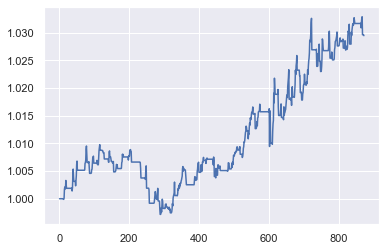

In [49]:
signal_df_all[signal_df_all['Ticker']=='NQ=F']['equity_curve'].plot()

<AxesSubplot:>

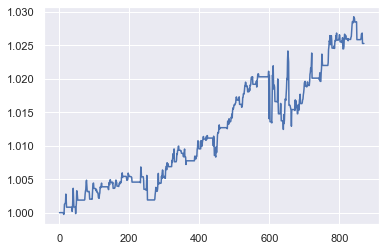

In [50]:
signal_df_all[signal_df_all['Ticker']=='ES=F']['equity_curve'].plot()

In [14]:
signal_list_all[signal_df_all['Ticker']=='YM=F']['equity_curve'].plot()

NameError: name 'signal_list_all' is not defined

In [24]:
# CN_mutual_funds_df = pd.DataFrame()
# CN_mutual_funds_df['Ticker'] = list(CN_mutual_funds_dict.keys())
# CN_mutual_funds_df['CN_Name'] = list(CN_mutual_funds_dict.values())
# signal_df_all = signal_df_all.merge(CN_mutual_funds_df, on = "Ticker")
# CN_mutual_funds_dict

In [26]:
# signal_df_all['CN_Name'].unique()

In [48]:
signal_df_all[signal_df_all['datetime']=='2021-03-24']

,datetime,signal,market_value,cash,commission,total,returns,equity_curve,drawdown,Ticker,daily_PL
872,2021-03-24,持仓中,156603.0,1.387547e+06,274,1.544150e+06,-0.000146,1.029434,0.003415,NQ=F,-225.0
870,2021-03-24,无仓位,0.0,1.537936e+06,264,1.537936e+06,0.000000,1.025291,0.003994,ES=F,0.0
867,2021-03-24,无仓位,0.0,1.531967e+06,252,1.531967e+06,0.000000,1.021311,0.000648,YM=F,0.0
872,2021-03-24,清仓,0.0,1.487419e+06,280,1.487419e+06,-0.000001,0.991613,0.018107,GC=F,-2.0
873,2021-03-24,无仓位,0.0,1.487419e+06,280,1.487419e+06,-0.000001,0.991613,0.018107,GC=F,-2.0
873,2021-03-24,无仓位,0.0,1.535028e+06,276,1.535028e+06,0.000000,1.023352,0.008455,CL=F,0.0
882,2021-03-24,无仓位,0.0,1.486405e+06,312,1.486405e+06,0.000000,0.990937,0.010659,XAU=F,0.0
863,2021-03-24,无仓位,0.0,1.633015e+06,236,1.633015e+06,0.000000,1.088676,0.003336,RB=F,0.0
875,2021-03-24,无仓位,0.0,1.518157e+06,284,1.518157e+06,0.000000,1.012105,0.009041,CT=F,0.0
840,2021-03-24,清仓,0.0,1.508247e+06,152,1.508247e+06,-0.000001,1.005498,0.005786,ALI=F,-2.0


In [34]:
perf_df = pd.DataFrame(ticker_performances).T
perf_df.sort_values("overall_score", ascending=False, inplace = True)

perf_df.reset_index(inplace = True)
perf_df.columns = ['Ticker', 'total_commission', 'gross_profit', 'net_profit',
       'commission_impact', 'win %', 'PL Ratio', 'overall_score', 'strat_name',
       'commission', 'backtest_memo']
# perf_df = perf_df.merge(CN_mutual_funds_df, on = "Ticker")

KeyError: 'Ticker'

In [35]:
perf_df

,Ticker,total_commission,gross_profit,net_profit,commission_impact,win %,PL Ratio,overall_score,strat_name,commission,backtest_memo
0,ES=F,3.51,US_ALL,2,0.02%,1.31012e+06,1.30986e+06,2.55,MACD,264,78.79


In [29]:
to_csv_folder = "C:/Users/Administrator/CE_github_2/data_pipeline/Performance/"
perf_df.to_csv(to_csv_folder+"CN_mutual_funds_MACD_UPDOWN_MA_SLOPE_W_COMM.csv")

In [53]:
df_equity_copy

,datetime,market_value,cash,commission,total,returns,equity_curve,drawdown,Ticker,daily_PL
0,2018-01-01,0.0,1.500000e+06,0,1.500000e+06,NaN,NaN,NaN,161005,NaN
1,2019-01-02,0.0,1.500000e+06,0,1.500000e+06,0.0,1.00000,0.000000,161005,0.0
2,2019-01-03,0.0,1.500000e+06,0,1.500000e+06,0.0,1.00000,0.000000,161005,0.0
3,2019-01-04,0.0,1.500000e+06,0,1.500000e+06,0.0,1.00000,0.000000,161005,0.0
4,2019-01-07,0.0,1.500000e+06,0,1.500000e+06,0.0,1.00000,0.000000,161005,0.0
...,...,...,...,...,...,...,...,...,...,...
528,2021-03-05,0.0,1.539314e+06,188,1.539314e+06,0.0,1.02621,0.003027,161005,0.0
529,2021-03-08,0.0,1.539314e+06,188,1.539314e+06,0.0,1.02621,0.003027,161005,0.0
530,2021-03-09,0.0,1.539314e+06,188,1.539314e+06,0.0,1.02621,0.003027,161005,0.0
531,2021-03-10,0.0,1.539314e+06,188,1.539314e+06,0.0,1.02621,0.003027,161005,0.0


In [60]:
df_list_data[df_list_data['Ticker']=="001508"]

,market_value,cash,commission,total,returns,equity_curve,drawdown,Ticker,daily_PL
datetime,,,,,,,,,
2018-01-01,0.0,1500000.000,0,1500000.000,NaN,NaN,NaN,001508,NaN
2019-01-02,0.0,1500000.000,0,1500000.000,0.0,1.000000,0.000000,001508,0.0
2019-01-03,0.0,1500000.000,0,1500000.000,0.0,1.000000,0.000000,001508,0.0
2019-01-04,0.0,1500000.000,0,1500000.000,0.0,1.000000,0.000000,001508,0.0
2019-01-07,0.0,1500000.000,0,1500000.000,0.0,1.000000,0.000000,001508,0.0
...,...,...,...,...,...,...,...,...,...
2021-03-05,0.0,1578695.053,168,1578695.053,0.0,1.052463,0.002035,001508,0.0
2021-03-08,0.0,1578695.053,168,1578695.053,0.0,1.052463,0.002035,001508,0.0
2021-03-09,0.0,1578695.053,168,1578695.053,0.0,1.052463,0.002035,001508,0.0


<AxesSubplot:xlabel='datetime'>

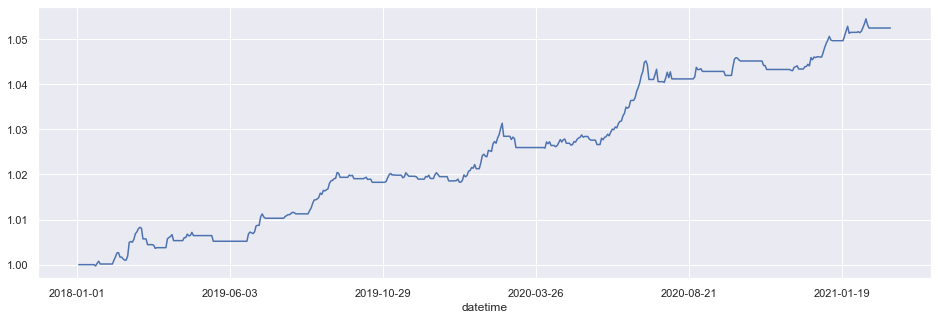

In [61]:
ticker_to_check = "001508"
df_to_check_curve = df_list_data[df_list_data['Ticker']==ticker_to_check]

<AxesSubplot:xlabel='datetime'>

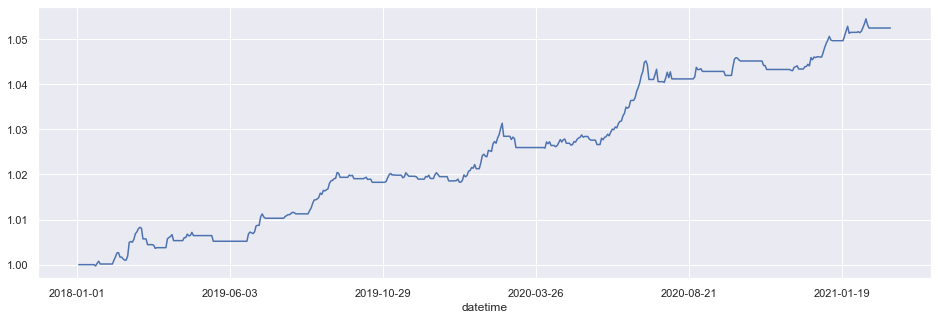

In [62]:
df_to_check_curve['equity_curve'].plot(figsize = (16,5))

In [65]:
data = pd.concat(LOAD_DATA.read_data_from_Sina(['001508'], "2018-01-01", "2021-03-12"))

Loading from SinaFinance: No.1 / 1: 001508
All Data Loaded


In [67]:
data.set_index("Date", inplace = True)

<AxesSubplot:xlabel='Date'>

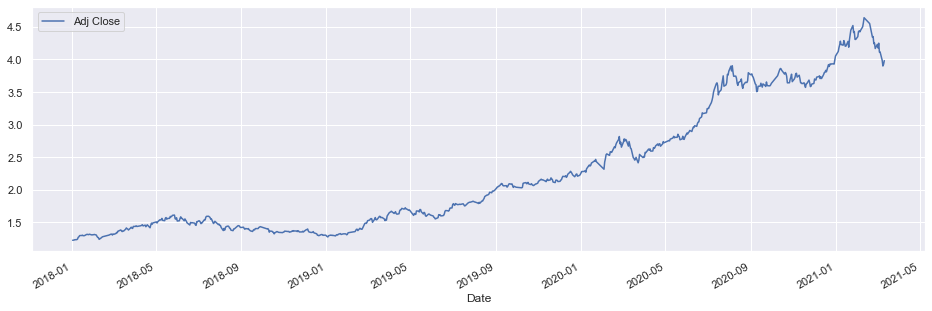

In [69]:
data[['Adj Close']].plot(figsize = (16,5))

# 可视化验证信号

In [6]:
def MACD(df, price_col, n_fast, n_slow, n_ema): # n_fast = 12, n_slow = 26
    """
    http://stockcharts.com/docs/doku.php?id=scans:indicators
    MACD, MACD Signal and MACD difference, rationale CHECKED, code CHECKED, updated
    # Conventional look-back window for calculating MACDsign is 9
    """
    EMAfast = df[price_col].ewm(span = n_fast, min_periods = n_fast - 1).mean()
    EMAslow = df[price_col].ewm(span = n_slow, min_periods = n_slow - 1).mean()
    diff = pd.Series(EMAfast - EMAslow)
    dea = diff.ewm(span = n_ema, min_periods = n_ema-1).mean()
    macd = (pd.Series(diff - dea))*2
    df["DIFF"] = diff
    df["DEA"] = dea
    df["MACD"] = macd
    return df

In [7]:
data = LOAD_DATA.read_data_from_Sina(['003096'], "2018-01-01", "2021-03-26")

Loading from SinaFinance: No.1 / 1: 003096
All Data Loaded


In [11]:
price_col = "Adj Close"
df = pd.concat(data)
df_macd = MACD(df, price_col, 12, 26, 9)

df_macd['MA5'] = pd.Series(df_macd[price_col]).rolling(window=5).mean()
df_macd['MA10'] = pd.Series(df_macd[price_col]).rolling(window=10).mean()

<AxesSubplot:xlabel='Date'>

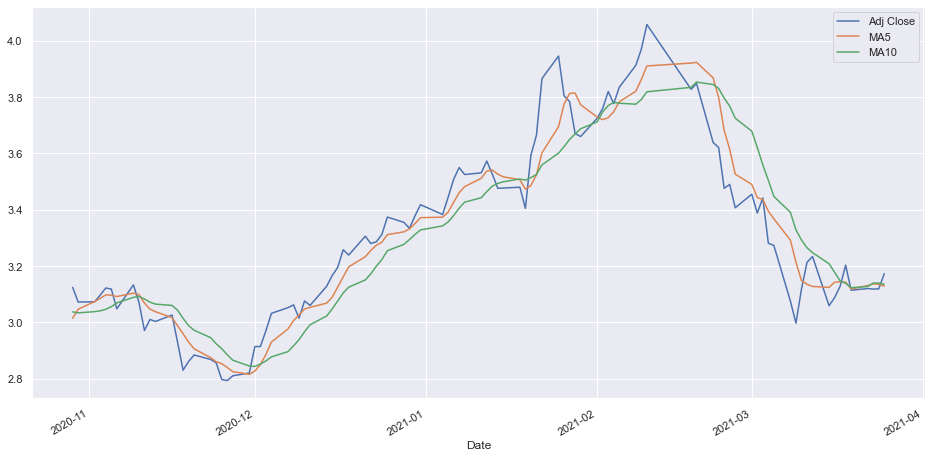

In [12]:
df_macd.set_index("Date", inplace = True)
df_macd[[ 'Adj Close', 'MA5', 'MA10']].tail(100).plot(figsize = (16, 8))

In [13]:
df_macd

,Open,High,Low,Close,Adj Close,Volume,Ticker,DIFF,DEA,MACD,MA5,MA10
Date,,,,,,,,,,,,
2018-01-02,1.229,1.229,1.229,1.229,1.229,1.229,003096,NaN,NaN,NaN,NaN,NaN
2018-01-03,1.234,1.234,1.234,1.234,1.234,1.234,003096,NaN,NaN,NaN,NaN,NaN
2018-01-04,1.246,1.246,1.246,1.246,1.246,1.246,003096,NaN,NaN,NaN,NaN,NaN
2018-01-05,1.245,1.245,1.245,1.245,1.245,1.245,003096,NaN,NaN,NaN,NaN,NaN
2018-01-08,1.247,1.247,1.247,1.247,1.247,1.247,003096,NaN,NaN,NaN,1.2402,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
2021-03-19,3.114,3.114,3.114,3.114,3.114,3.114,003096,-0.130477,-0.122614,-0.015727,3.1184,3.1229
2021-03-22,3.120,3.120,3.120,3.120,3.120,3.120,003096,-0.126972,-0.123485,-0.006974,3.1306,3.1274
2021-03-23,3.118,3.118,3.118,3.118,3.118,3.118,003096,-0.122939,-0.123376,0.000875,3.1366,3.1395
